#بِسْمِ اللهِ الرَّحْمٰنِ الرَّحِيْمِ

## Importing Libraries

In [1]:
#Importing all the Required Librarires

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.metrics import Accuracy, Recall, Precision
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.regularizers import l2
from keras.applications import InceptionV3
import os
import cv2
from PIL import Image
import numpy as np


In [2]:
#Obtaining the Data shape and Label
image_directory = '/content/drive/MyDrive/ML_WCE_BleedGen'

# Define the image size
SIZE = 224

# Initialize lists to store the dataset and labels
dataset = []
labels = []

# Function to read and preprocess images
def process_images(image_dir, label_value):
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.png'):
            image_path = os.path.join(image_dir, image_name)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (SIZE, SIZE))
                    dataset.append(image)
                    labels.append(label_value)
                else:
                    print(f"Unable to load image: {image_path}")
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")

In [3]:
# Process bleeding images
bleeding_directory = os.path.join(image_directory, '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/bleeding')
process_images(bleeding_directory, label_value=1)

# Process non-bleeding images
non_bleeding_directory = os.path.join(image_directory, '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/non-bleeding')
process_images(non_bleeding_directory, label_value=0)

# Convert dataset and labels to numpy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Print dataset and label shapes for verification
print('Dataset shape:', dataset.shape)
print('Label shape:', labels.shape)


Dataset shape: (2618, 224, 224, 3)
Label shape: (2618,)


In [4]:
# Print dataset and label shapes for verification
print('Dataset shape:', dataset.shape)
print('Label shape:', labels.shape)


Dataset shape: (2618, 224, 224, 3)
Label shape: (2618,)


In [5]:
import tensorflow as tf
import albumentations as alb

# Define the custom augmentation pipeline
custom_augmentation = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.Rotate(),
    alb.Resize(height=224, width=224, p=1)
])

def augment_dataset(images, labels, augmentation_factor=3):
    augmented_images = []
    augmented_labels = []

    # Iterate through the original images and apply augmentation
    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)
        for _ in range(augmentation_factor):
            augmented_image = custom_augmentation(image=image)['image']
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return tf.convert_to_tensor(augmented_images), tf.convert_to_tensor(augmented_labels)



In [6]:
aug_dataset, aug_labels = augment_dataset(dataset, labels)

In [7]:
print(aug_dataset.shape)
print(aug_labels.shape)

(10472, 224, 224, 3)
(10472,)


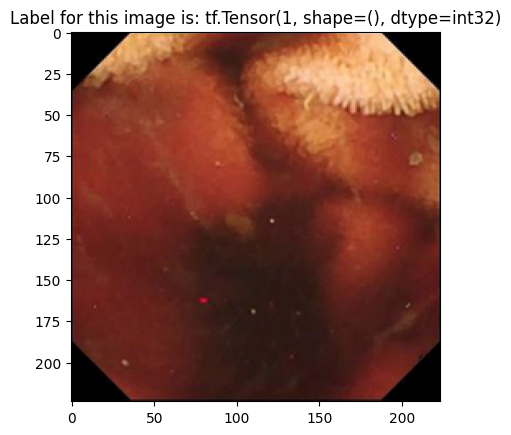

In [8]:
"""**Random image from the dataset and its label**"""

import random
import matplotlib.pyplot as plt

# Generate a random image number
image_number = random.randint(0, len(aug_dataset) - 1)

# Display the image and its label
plt.imshow(aug_dataset[image_number])
plt.title("Label for this image is: " + str(aug_labels[image_number]))  # Use 'labels' instead of 'label'
plt.show()

# Using Augmented images for training

In [9]:
# import os
# import cv2
# import numpy as np
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.densenet import preprocess_input
# from tqdm import tqdm

# # Define the image directories
# image_directory = '/content/drive/MyDrive/final/WCEBleedGen/'
# output_directory = '/content/drive/MyDrive/final/extracted_features/'

# # Create output directory if it doesn't exist
# os.makedirs(output_directory, exist_ok=True)

# # Load the DenseNet-121 model with pre-trained weights
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Remove the top classification layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)

# # Create a model for feature extraction
# model = Model(inputs=base_model.input, outputs=x)

# # Function to extract features from an image
# def extract_features_from_augmented_dataset(augmented_images):
#     features_list = []
#     for augmented_image in tqdm(augmented_images):
#         img = np.expand_dims(augmented_image, axis=0)
#         img = preprocess_input(img)
#         features = model.predict(img)
#         features_list.append(features)
#     return np.vstack(features_list)

# # Extract features from the augmented dataset
# augmented_features = extract_features_from_augmented_dataset(aug_dataset)

# # Save the extracted features
# np.save(os.path.join(output_directory, 'augmented_features.npy'), augmented_features)

# # print("Feature extraction from the augmented dataset completed.")


In [10]:
# # Save the extracted features and aug_labels
# np.save(os.path.join(output_directory, 'augmented_features.npy'), augmented_features)
# augmented_labels = np.vstack(aug_labels)
# np.save(os.path.join(output_directory, 'augmented_labels.npy') , augmented_labels)

In [11]:
# # Load your extracted features (10472, 1, 1024)
# features_array = np.load('/content/drive/MyDrive/ML_WCE_BleedGen/extracted_features/augmented_features.npy')
# labels_array = np.load('/content/drive/MyDrive/ML_WCE_BleedGen/extracted_features/augmented_labels.npy')
# print(features_array.shape , labels_array.shape)

In [12]:
# import os
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.utils import to_categorical

# # Load your extracted features (2618, 1, 1024)
# features_array = np.load('/content/drive/MyDrive/ML_WCE_BleedGen/extracted_features/augmented_features.npy')
# labels_array = np.load('/content/drive/MyDrive/ML_WCE_BleedGen/extracted_features/augmented_labels.npy')

# # Reshape the features into (10472, 32,32,1)
# features_array_2d = features_array.reshape((10472, 32,32,1))

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     features_array_2d, labels_array, test_size=0.2, random_state=42)

# # Convert labels to one-hot encoding
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)

# # Define the 2D CNN model
# model = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(len(np.unique(labels_array)), activation='softmax')
# ])

# # # Define the model
# # model = Sequential([
# #     Dense(512, activation='relu', input_shape=(1024,)),
# #     Dropout(0.5),
# #     Dense(256, activation='relu'),
# #     Dropout(0.5),
# #     Dense(len(np.unique(labels_array)), activation='softmax')
# # ])

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [13]:
# # Train the model
# history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


In [14]:

# # Evaluate the model
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

## Uaing DenseNet 121 Architecture

In [15]:
#Using DenseNet 121 Architecture to Extract Features
# import os
# import cv2
# import numpy as np
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.densenet import preprocess_input
# from tqdm import tqdm

# Define the image directories
# image_directory = '/content/drive/MyDrive/ML_WCE_BleedGen'
# output_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/extracted_features/'
# Define the image size
# SIZE = (224, 224)

# Create output directory if it doesn't exist
# os.makedirs(output_directory, exist_ok=True)

# Load the DenseNet-121 model with pre-trained weights
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Remove the top classification layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# Create a model for feature extraction
# model = Model(inputs=base_model.input, outputs=x)

#Summary of model
# model.summary()
import os
import cv2
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tqdm import tqdm
import tensorflow as tf
import albumentations as alb

# Define the custom augmentation pipeline with specific operations and parameters
custom_augmentation = alb.Compose([
    alb.HorizontalFlip(p=0.5),  # Apply horizontal flip with a probability of 0.5
    alb.VerticalFlip(p=0.5),  # Apply vertical flip with a probability of 0.5
    alb.Rotate(limit=30, p=0.5),  # Apply rotation with a limit of 30 degrees and a probability of 0.5
    alb.Resize(height=224, width=224, p=1)  # Resize the image to 224x224
])

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Create the feature extraction model
model = Model(inputs=base_model.input, outputs=x)

# # Function to extract features from an image
# def extract_features(img):
#     img = cv2.resize(img, (224, 224))  # Resize the input image
#     img = np.expand_dims(img, axis=0)  # Add a batch dimension
#     img = preprocess_input(img)
#     features = model.predict(img)
#     return features

from tensorflow.keras.layers import Dropout, BatchNormalization

# Updated function to extract features from an image with regularization and data augmentation
def extract_features(img, training=False):
    if training:
        augmented_img = custom_augmentation(image=img)['image']  # Apply data augmentation
        img = augmented_img

    img = cv2.resize(img, (224, 224))  # Resize the input image
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = preprocess_input(img)

    # Add regularization layers to the model architecture
    x = model.layers[-2].output  # Get the output of the GlobalAveragePooling2D layer
    x = Dropout(0.5)(x)  # Apply dropout with a rate of 0.5
    x = BatchNormalization()(x)  # Apply batch normalization

    features = model.predict(img)
    return features


# # Process bleeding images with augmentation
# bleeding_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/bleeding'  # Update the directory path
# augmented_images_list =[]
# for image_name in tqdm(os.listdir(bleeding_directory)):
#     if image_name.endswith('.png'):
#         image_path = os.path.join(bleeding_directory, image_name)
#         img = cv2.imread(image_path)  # Load the image using OpenCV
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
#         augmented_img = custom_augmentation(image=img)['image']  # Apply custom augmentation
#         features = extract_features(augmented_img)  # Extract features
#         features_list.append(features)
#         labels_list.append(1)  # Assuming the label for bleeding images is 1
#         # Append the augmented image to a separate list for verification
#         augmented_images_list.append(augmented_img)  # Create a list to store augmented images for verification

# # Verify the number of images before and after augmentation
# print("Number of original images:", len(os.listdir(bleeding_directory)))
# print("Number of augmented images:", len(augmented_images_list))







29084464/29084464 [==============================] - 0s 0us/step


In [16]:
# Initialize lists to store features and labels
features_list = []
labels_list = []

# Process bleeding images with augmentation
bleeding_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/bleeding'  # Update the directory path

for image_name in tqdm(os.listdir(bleeding_directory)):
    if image_name.endswith('.png'):
        image_path = os.path.join(bleeding_directory, image_name)
        img = cv2.imread(image_path)  # Load the image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        augmented_img = custom_augmentation(image=img)['image']  # Apply custom augmentation
        features = extract_features(augmented_img)  # Extract features
        features_list.append(features)
        labels_list.append(1)  # Assuming the label for bleeding images is 1


  0%|          | 0/1309 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 1/1309 [00:02<57:09,  2.62s/it]

1/1 [==============================] - 0s 160ms/step


  0%|          | 2/1309 [00:02<26:55,  1.24s/it]

1/1 [==============================] - 0s 159ms/step


  0%|          | 3/1309 [00:03<17:13,  1.26it/s]

1/1 [==============================] - 0s 155ms/step


  0%|          | 4/1309 [00:03<12:38,  1.72it/s]

1/1 [==============================] - 0s 171ms/step


  0%|          | 5/1309 [00:03<11:24,  1.91it/s]

1/1 [==============================] - 0s 151ms/step


  0%|          | 6/1309 [00:04<09:28,  2.29it/s]

1/1 [==============================] - 0s 155ms/step


  1%|          | 7/1309 [00:04<08:15,  2.63it/s]

1/1 [==============================] - 0s 147ms/step


  1%|          | 8/1309 [00:04<07:22,  2.94it/s]

1/1 [==============================] - 0s 168ms/step


  1%|          | 9/1309 [00:05<07:56,  2.73it/s]

1/1 [==============================] - 0s 150ms/step


  1%|          | 10/1309 [00:05<07:12,  3.00it/s]

1/1 [==============================] - 0s 147ms/step


  1%|          | 11/1309 [00:05<06:37,  3.27it/s]

1/1 [==============================] - 0s 160ms/step


  1%|          | 12/1309 [00:05<06:20,  3.41it/s]

1/1 [==============================] - 0s 147ms/step


  1%|          | 13/1309 [00:06<06:04,  3.55it/s]

1/1 [==============================] - 0s 388ms/step


  1%|          | 14/1309 [00:06<09:59,  2.16it/s]

1/1 [==============================] - 0s 157ms/step


  1%|          | 15/1309 [00:19<1:28:25,  4.10s/it]

1/1 [==============================] - 0s 147ms/step


  1%|          | 16/1309 [00:19<1:03:25,  2.94s/it]

1/1 [==============================] - 0s 151ms/step


  1%|▏         | 17/1309 [00:19<45:57,  2.13s/it]  

1/1 [==============================] - 0s 146ms/step


  1%|▏         | 18/1309 [00:20<33:49,  1.57s/it]

1/1 [==============================] - 0s 202ms/step


  1%|▏         | 19/1309 [00:20<25:37,  1.19s/it]

1/1 [==============================] - 0s 266ms/step


  2%|▏         | 20/1309 [00:20<20:32,  1.05it/s]

1/1 [==============================] - 0s 252ms/step


  2%|▏         | 21/1309 [00:21<16:54,  1.27it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 22/1309 [00:21<14:19,  1.50it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 23/1309 [00:22<12:36,  1.70it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 24/1309 [00:22<11:47,  1.82it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▏         | 25/1309 [00:22<10:40,  2.00it/s]

1/1 [==============================] - 0s 234ms/step


  2%|▏         | 26/1309 [00:23<09:48,  2.18it/s]

1/1 [==============================] - 0s 245ms/step


  2%|▏         | 27/1309 [00:23<09:23,  2.28it/s]

1/1 [==============================] - 0s 254ms/step


  2%|▏         | 28/1309 [00:24<09:31,  2.24it/s]

1/1 [==============================] - 0s 247ms/step


  2%|▏         | 29/1309 [00:24<09:07,  2.34it/s]

1/1 [==============================] - 0s 146ms/step


  2%|▏         | 30/1309 [00:24<08:05,  2.64it/s]

1/1 [==============================] - 0s 144ms/step


  2%|▏         | 31/1309 [00:25<07:10,  2.97it/s]

1/1 [==============================] - 0s 154ms/step


  2%|▏         | 32/1309 [00:25<06:49,  3.12it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 33/1309 [00:25<07:24,  2.87it/s]

1/1 [==============================] - 0s 146ms/step


  3%|▎         | 34/1309 [00:26<06:47,  3.13it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 35/1309 [00:26<06:24,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


  3%|▎         | 36/1309 [00:26<06:13,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 37/1309 [00:26<06:03,  3.50it/s]

1/1 [==============================] - 0s 146ms/step


  3%|▎         | 38/1309 [00:27<05:48,  3.65it/s]

1/1 [==============================] - 0s 147ms/step


  3%|▎         | 39/1309 [00:27<05:40,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


  3%|▎         | 40/1309 [00:27<05:35,  3.78it/s]

1/1 [==============================] - 0s 147ms/step


  3%|▎         | 41/1309 [00:27<05:31,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


  3%|▎         | 42/1309 [00:28<05:31,  3.83it/s]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 43/1309 [00:28<05:23,  3.92it/s]

1/1 [==============================] - 0s 144ms/step


  3%|▎         | 44/1309 [00:28<05:17,  3.98it/s]

1/1 [==============================] - 0s 147ms/step


  3%|▎         | 45/1309 [00:28<05:21,  3.93it/s]

1/1 [==============================] - 0s 145ms/step


  4%|▎         | 46/1309 [00:29<05:18,  3.96it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▎         | 47/1309 [00:29<05:12,  4.04it/s]

1/1 [==============================] - 0s 145ms/step


  4%|▎         | 48/1309 [00:29<05:12,  4.04it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▎         | 49/1309 [00:29<05:15,  3.99it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▍         | 50/1309 [00:30<05:17,  3.96it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 51/1309 [00:30<05:17,  3.96it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 52/1309 [00:30<05:14,  4.00it/s]

1/1 [==============================] - 0s 166ms/step


  4%|▍         | 53/1309 [00:30<05:21,  3.91it/s]

1/1 [==============================] - 0s 149ms/step


  4%|▍         | 54/1309 [00:31<05:26,  3.84it/s]

1/1 [==============================] - 0s 150ms/step


  4%|▍         | 55/1309 [00:31<05:22,  3.88it/s]

1/1 [==============================] - 0s 151ms/step


  4%|▍         | 56/1309 [00:31<05:18,  3.93it/s]

1/1 [==============================] - 0s 154ms/step


  4%|▍         | 57/1309 [00:31<05:21,  3.89it/s]

1/1 [==============================] - 0s 150ms/step


  4%|▍         | 58/1309 [00:32<05:23,  3.87it/s]

1/1 [==============================] - 0s 144ms/step


  5%|▍         | 59/1309 [00:32<05:19,  3.91it/s]

1/1 [==============================] - 0s 148ms/step


  5%|▍         | 60/1309 [00:32<05:26,  3.83it/s]

1/1 [==============================] - 0s 150ms/step


  5%|▍         | 61/1309 [00:32<05:29,  3.79it/s]

1/1 [==============================] - 0s 148ms/step


  5%|▍         | 62/1309 [00:33<05:22,  3.87it/s]

1/1 [==============================] - 0s 147ms/step


  5%|▍         | 63/1309 [00:33<05:20,  3.89it/s]

1/1 [==============================] - 0s 143ms/step


  5%|▍         | 64/1309 [00:33<05:14,  3.96it/s]

1/1 [==============================] - 0s 156ms/step


  5%|▍         | 65/1309 [00:33<05:17,  3.92it/s]

1/1 [==============================] - 0s 143ms/step


  5%|▌         | 66/1309 [00:34<05:18,  3.91it/s]

1/1 [==============================] - 0s 149ms/step


  5%|▌         | 67/1309 [00:34<05:13,  3.96it/s]

1/1 [==============================] - 0s 183ms/step


  5%|▌         | 68/1309 [00:34<05:21,  3.85it/s]

1/1 [==============================] - 0s 234ms/step


  5%|▌         | 69/1309 [00:35<06:06,  3.38it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▌         | 70/1309 [00:35<06:30,  3.17it/s]

1/1 [==============================] - 0s 237ms/step


  5%|▌         | 71/1309 [00:35<06:49,  3.02it/s]

1/1 [==============================] - 0s 247ms/step


  6%|▌         | 72/1309 [00:36<07:48,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


  6%|▌         | 73/1309 [00:36<07:57,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▌         | 74/1309 [00:37<08:02,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


  6%|▌         | 75/1309 [00:37<07:59,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


  6%|▌         | 76/1309 [00:38<08:33,  2.40it/s]

1/1 [==============================] - 0s 247ms/step


  6%|▌         | 77/1309 [00:38<08:57,  2.29it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▌         | 78/1309 [00:38<09:19,  2.20it/s]

1/1 [==============================] - 0s 146ms/step


  6%|▌         | 79/1309 [00:39<08:09,  2.51it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 80/1309 [00:39<07:15,  2.83it/s]

1/1 [==============================] - 0s 147ms/step


  6%|▌         | 81/1309 [00:39<06:32,  3.13it/s]

1/1 [==============================] - 0s 153ms/step


  6%|▋         | 82/1309 [00:40<06:10,  3.31it/s]

1/1 [==============================] - 0s 142ms/step


  6%|▋         | 83/1309 [00:40<05:55,  3.45it/s]

1/1 [==============================] - 0s 147ms/step


  6%|▋         | 84/1309 [00:40<05:41,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


  6%|▋         | 85/1309 [00:40<06:31,  3.13it/s]

1/1 [==============================] - 0s 160ms/step


  7%|▋         | 86/1309 [00:41<06:07,  3.33it/s]

1/1 [==============================] - 0s 143ms/step


  7%|▋         | 87/1309 [00:41<05:49,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


  7%|▋         | 88/1309 [00:41<05:36,  3.63it/s]

1/1 [==============================] - 0s 144ms/step


  7%|▋         | 89/1309 [00:41<05:26,  3.73it/s]

1/1 [==============================] - 0s 159ms/step


  7%|▋         | 90/1309 [00:42<05:23,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


  7%|▋         | 91/1309 [00:42<05:19,  3.81it/s]

1/1 [==============================] - 0s 145ms/step


  7%|▋         | 92/1309 [00:42<05:17,  3.84it/s]

1/1 [==============================] - 0s 150ms/step


  7%|▋         | 93/1309 [00:42<05:15,  3.85it/s]

1/1 [==============================] - 0s 160ms/step


  7%|▋         | 94/1309 [00:43<05:14,  3.87it/s]

1/1 [==============================] - 0s 149ms/step


  7%|▋         | 95/1309 [00:43<05:12,  3.88it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 96/1309 [00:43<05:22,  3.76it/s]

1/1 [==============================] - 0s 152ms/step


  7%|▋         | 97/1309 [00:44<05:18,  3.80it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 98/1309 [00:44<05:23,  3.74it/s]

1/1 [==============================] - 0s 161ms/step


  8%|▊         | 99/1309 [00:44<06:18,  3.19it/s]

1/1 [==============================] - 0s 151ms/step


  8%|▊         | 100/1309 [00:44<05:57,  3.38it/s]

1/1 [==============================] - 0s 167ms/step


  8%|▊         | 101/1309 [00:45<05:45,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


  8%|▊         | 102/1309 [00:45<05:39,  3.55it/s]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 103/1309 [00:45<05:49,  3.45it/s]

1/1 [==============================] - 0s 252ms/step


  8%|▊         | 104/1309 [00:46<06:54,  2.91it/s]

1/1 [==============================] - 0s 249ms/step


  8%|▊         | 105/1309 [00:46<07:06,  2.82it/s]

1/1 [==============================] - 0s 236ms/step


  8%|▊         | 106/1309 [00:47<07:11,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


  8%|▊         | 107/1309 [00:47<07:25,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


  8%|▊         | 108/1309 [00:47<08:07,  2.46it/s]

1/1 [==============================] - 0s 240ms/step


  8%|▊         | 109/1309 [00:48<08:25,  2.37it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 110/1309 [00:48<08:16,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


  8%|▊         | 111/1309 [00:49<08:38,  2.31it/s]

1/1 [==============================] - 0s 298ms/step


  9%|▊         | 112/1309 [00:49<08:50,  2.26it/s]

1/1 [==============================] - 0s 303ms/step


  9%|▊         | 113/1309 [00:50<09:03,  2.20it/s]

1/1 [==============================] - 0s 305ms/step


  9%|▊         | 114/1309 [00:50<09:19,  2.13it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 115/1309 [00:51<09:36,  2.07it/s]

1/1 [==============================] - 0s 250ms/step


  9%|▉         | 116/1309 [00:51<09:01,  2.20it/s]

1/1 [==============================] - 0s 246ms/step


  9%|▉         | 117/1309 [00:52<08:36,  2.31it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▉         | 118/1309 [00:52<08:17,  2.39it/s]

1/1 [==============================] - 0s 255ms/step


  9%|▉         | 119/1309 [00:52<08:34,  2.31it/s]

1/1 [==============================] - 0s 251ms/step


  9%|▉         | 120/1309 [00:53<08:53,  2.23it/s]

1/1 [==============================] - 0s 258ms/step


  9%|▉         | 121/1309 [00:53<09:07,  2.17it/s]

1/1 [==============================] - 0s 146ms/step


  9%|▉         | 122/1309 [00:54<07:59,  2.48it/s]

1/1 [==============================] - 0s 147ms/step


  9%|▉         | 123/1309 [00:54<07:01,  2.81it/s]

1/1 [==============================] - 0s 141ms/step


  9%|▉         | 124/1309 [00:54<06:20,  3.12it/s]

1/1 [==============================] - 0s 161ms/step


 10%|▉         | 125/1309 [00:54<05:59,  3.30it/s]

1/1 [==============================] - 0s 149ms/step


 10%|▉         | 126/1309 [00:55<05:48,  3.40it/s]

1/1 [==============================] - 0s 149ms/step


 10%|▉         | 127/1309 [00:55<05:29,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 10%|▉         | 128/1309 [00:55<05:22,  3.66it/s]

1/1 [==============================] - 0s 162ms/step


 10%|▉         | 129/1309 [00:55<05:18,  3.70it/s]

1/1 [==============================] - 0s 146ms/step


 10%|▉         | 130/1309 [00:56<05:09,  3.81it/s]

1/1 [==============================] - 0s 142ms/step


 10%|█         | 131/1309 [00:56<05:05,  3.86it/s]

1/1 [==============================] - 0s 152ms/step


 10%|█         | 132/1309 [00:56<05:06,  3.84it/s]

1/1 [==============================] - 0s 158ms/step


 10%|█         | 133/1309 [00:56<05:06,  3.84it/s]

1/1 [==============================] - 0s 145ms/step


 10%|█         | 134/1309 [00:57<05:03,  3.87it/s]

1/1 [==============================] - 0s 142ms/step


 10%|█         | 135/1309 [00:57<04:58,  3.93it/s]

1/1 [==============================] - 0s 149ms/step


 10%|█         | 136/1309 [00:57<04:56,  3.96it/s]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 137/1309 [00:57<04:57,  3.94it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 138/1309 [00:58<04:59,  3.91it/s]

1/1 [==============================] - 0s 148ms/step


 11%|█         | 139/1309 [00:58<04:54,  3.97it/s]

1/1 [==============================] - 0s 154ms/step


 11%|█         | 140/1309 [00:58<04:53,  3.98it/s]

1/1 [==============================] - 0s 161ms/step


 11%|█         | 141/1309 [00:59<05:49,  3.34it/s]

1/1 [==============================] - 0s 146ms/step


 11%|█         | 142/1309 [00:59<05:30,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 11%|█         | 143/1309 [00:59<05:18,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


 11%|█         | 144/1309 [00:59<05:15,  3.70it/s]

1/1 [==============================] - 0s 155ms/step


 11%|█         | 145/1309 [01:00<05:13,  3.72it/s]

1/1 [==============================] - 0s 145ms/step


 11%|█         | 146/1309 [01:00<05:06,  3.79it/s]

1/1 [==============================] - 0s 147ms/step


 11%|█         | 147/1309 [01:00<05:01,  3.86it/s]

1/1 [==============================] - 0s 152ms/step


 11%|█▏        | 148/1309 [01:00<05:00,  3.86it/s]

1/1 [==============================] - 0s 152ms/step


 11%|█▏        | 149/1309 [01:01<05:00,  3.86it/s]

1/1 [==============================] - 0s 145ms/step


 11%|█▏        | 150/1309 [01:01<04:59,  3.87it/s]

1/1 [==============================] - 0s 149ms/step


 12%|█▏        | 151/1309 [01:01<04:56,  3.90it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 152/1309 [01:01<04:57,  3.89it/s]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 153/1309 [01:02<04:57,  3.88it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█▏        | 154/1309 [01:02<04:50,  3.97it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█▏        | 155/1309 [01:02<04:58,  3.87it/s]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 156/1309 [01:03<06:44,  2.85it/s]

1/1 [==============================] - 0s 146ms/step


 12%|█▏        | 157/1309 [01:03<06:09,  3.12it/s]

1/1 [==============================] - 0s 149ms/step


 12%|█▏        | 158/1309 [01:03<05:49,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 159/1309 [01:04<06:27,  2.97it/s]

1/1 [==============================] - 0s 249ms/step


 12%|█▏        | 160/1309 [01:04<07:11,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 161/1309 [01:04<07:10,  2.67it/s]

1/1 [==============================] - 0s 230ms/step


 12%|█▏        | 162/1309 [01:05<07:21,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 163/1309 [01:05<07:27,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 164/1309 [01:06<07:58,  2.39it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 165/1309 [01:06<08:13,  2.32it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 166/1309 [01:07<07:58,  2.39it/s]

1/1 [==============================] - 0s 244ms/step


 13%|█▎        | 167/1309 [01:07<07:51,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 168/1309 [01:07<07:59,  2.38it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 169/1309 [01:08<07:10,  2.65it/s]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 170/1309 [01:08<06:28,  2.93it/s]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 171/1309 [01:08<05:53,  3.22it/s]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 172/1309 [01:08<05:30,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


 13%|█▎        | 173/1309 [01:09<05:14,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 13%|█▎        | 174/1309 [01:09<05:13,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 175/1309 [01:09<05:10,  3.66it/s]

1/1 [==============================] - 0s 145ms/step


 13%|█▎        | 176/1309 [01:10<05:02,  3.74it/s]

1/1 [==============================] - 0s 143ms/step


 14%|█▎        | 177/1309 [01:10<04:56,  3.82it/s]

1/1 [==============================] - 0s 147ms/step


 14%|█▎        | 178/1309 [01:10<04:50,  3.89it/s]

1/1 [==============================] - 0s 148ms/step


 14%|█▎        | 179/1309 [01:10<04:47,  3.94it/s]

1/1 [==============================] - 0s 148ms/step


 14%|█▍        | 180/1309 [01:11<04:51,  3.87it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 181/1309 [01:11<04:54,  3.83it/s]

1/1 [==============================] - 0s 151ms/step


 14%|█▍        | 182/1309 [01:11<04:52,  3.85it/s]

1/1 [==============================] - 0s 164ms/step


 14%|█▍        | 183/1309 [01:11<05:46,  3.25it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 184/1309 [01:12<05:28,  3.42it/s]

1/1 [==============================] - 0s 164ms/step


 14%|█▍        | 185/1309 [01:12<05:17,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 14%|█▍        | 186/1309 [01:12<05:16,  3.54it/s]

1/1 [==============================] - 0s 146ms/step


 14%|█▍        | 187/1309 [01:13<05:09,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 188/1309 [01:13<05:03,  3.69it/s]

1/1 [==============================] - 0s 151ms/step


 14%|█▍        | 189/1309 [01:13<05:00,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 15%|█▍        | 190/1309 [01:13<04:56,  3.77it/s]

1/1 [==============================] - 0s 145ms/step


 15%|█▍        | 191/1309 [01:14<04:52,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


 15%|█▍        | 192/1309 [01:14<04:49,  3.85it/s]

1/1 [==============================] - 0s 148ms/step


 15%|█▍        | 193/1309 [01:14<04:54,  3.79it/s]

1/1 [==============================] - 0s 152ms/step


 15%|█▍        | 194/1309 [01:14<04:53,  3.80it/s]

1/1 [==============================] - 0s 146ms/step


 15%|█▍        | 195/1309 [01:15<04:48,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


 15%|█▍        | 196/1309 [01:15<04:50,  3.83it/s]

1/1 [==============================] - 0s 149ms/step


 15%|█▌        | 197/1309 [01:15<04:50,  3.83it/s]

1/1 [==============================] - 0s 150ms/step


 15%|█▌        | 198/1309 [01:15<04:52,  3.80it/s]

1/1 [==============================] - 0s 149ms/step


 15%|█▌        | 199/1309 [01:16<04:49,  3.83it/s]

1/1 [==============================] - 0s 144ms/step


 15%|█▌        | 200/1309 [01:16<04:44,  3.90it/s]

1/1 [==============================] - 0s 152ms/step


 15%|█▌        | 201/1309 [01:16<04:47,  3.85it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▌        | 202/1309 [01:16<04:46,  3.87it/s]

1/1 [==============================] - 0s 150ms/step


 16%|█▌        | 203/1309 [01:17<04:44,  3.89it/s]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 204/1309 [01:17<04:48,  3.82it/s]

1/1 [==============================] - 0s 147ms/step


 16%|█▌        | 205/1309 [01:17<04:52,  3.78it/s]

1/1 [==============================] - 0s 153ms/step


 16%|█▌        | 206/1309 [01:17<04:47,  3.84it/s]

1/1 [==============================] - 0s 241ms/step


 16%|█▌        | 207/1309 [01:18<05:21,  3.43it/s]

1/1 [==============================] - 0s 265ms/step


 16%|█▌        | 208/1309 [01:18<05:57,  3.08it/s]

1/1 [==============================] - 0s 247ms/step


 16%|█▌        | 209/1309 [01:19<06:48,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▌        | 210/1309 [01:19<07:26,  2.46it/s]

1/1 [==============================] - 0s 257ms/step


 16%|█▌        | 211/1309 [01:20<07:25,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▌        | 212/1309 [01:20<07:19,  2.49it/s]

1/1 [==============================] - 0s 225ms/step


 16%|█▋        | 213/1309 [01:20<07:41,  2.37it/s]

1/1 [==============================] - 0s 244ms/step


 16%|█▋        | 214/1309 [01:21<07:31,  2.43it/s]

1/1 [==============================] - 0s 234ms/step


 16%|█▋        | 215/1309 [01:21<07:28,  2.44it/s]

1/1 [==============================] - 0s 255ms/step


 17%|█▋        | 216/1309 [01:22<07:29,  2.43it/s]

1/1 [==============================] - 0s 150ms/step


 17%|█▋        | 217/1309 [01:22<06:49,  2.66it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█▋        | 218/1309 [01:22<06:09,  2.95it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█▋        | 219/1309 [01:22<05:42,  3.18it/s]

1/1 [==============================] - 0s 151ms/step


 17%|█▋        | 220/1309 [01:23<05:22,  3.38it/s]

1/1 [==============================] - 0s 148ms/step


 17%|█▋        | 221/1309 [01:23<05:05,  3.57it/s]

1/1 [==============================] - 0s 147ms/step


 17%|█▋        | 222/1309 [01:23<05:04,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 17%|█▋        | 223/1309 [01:24<05:04,  3.56it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█▋        | 224/1309 [01:24<04:54,  3.69it/s]

1/1 [==============================] - 0s 147ms/step


 17%|█▋        | 225/1309 [01:24<04:47,  3.78it/s]

1/1 [==============================] - 0s 148ms/step


 17%|█▋        | 226/1309 [01:24<04:43,  3.81it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█▋        | 227/1309 [01:25<04:42,  3.83it/s]

1/1 [==============================] - 0s 151ms/step


 17%|█▋        | 228/1309 [01:25<04:44,  3.81it/s]

1/1 [==============================] - 0s 155ms/step


 17%|█▋        | 229/1309 [01:25<04:42,  3.82it/s]

1/1 [==============================] - 0s 148ms/step


 18%|█▊        | 230/1309 [01:25<04:41,  3.84it/s]

1/1 [==============================] - 0s 150ms/step


 18%|█▊        | 231/1309 [01:26<04:41,  3.83it/s]

1/1 [==============================] - 0s 142ms/step


 18%|█▊        | 232/1309 [01:26<04:32,  3.95it/s]

1/1 [==============================] - 0s 148ms/step


 18%|█▊        | 233/1309 [01:26<04:30,  3.99it/s]

1/1 [==============================] - 0s 148ms/step


 18%|█▊        | 234/1309 [01:26<04:30,  3.97it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 235/1309 [01:27<04:36,  3.88it/s]

1/1 [==============================] - 0s 146ms/step


 18%|█▊        | 236/1309 [01:27<04:36,  3.88it/s]

1/1 [==============================] - 0s 149ms/step


 18%|█▊        | 237/1309 [01:27<04:41,  3.81it/s]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 238/1309 [01:27<04:37,  3.86it/s]

1/1 [==============================] - 0s 151ms/step


 18%|█▊        | 239/1309 [01:28<04:39,  3.83it/s]

1/1 [==============================] - 0s 148ms/step


 18%|█▊        | 240/1309 [01:28<04:38,  3.84it/s]

1/1 [==============================] - 0s 155ms/step


 18%|█▊        | 241/1309 [01:28<04:37,  3.85it/s]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 242/1309 [01:28<04:37,  3.84it/s]

1/1 [==============================] - 0s 146ms/step


 19%|█▊        | 243/1309 [01:29<04:36,  3.86it/s]

1/1 [==============================] - 0s 142ms/step


 19%|█▊        | 244/1309 [01:29<04:33,  3.90it/s]

1/1 [==============================] - 0s 150ms/step


 19%|█▊        | 245/1309 [01:29<04:30,  3.93it/s]

1/1 [==============================] - 0s 151ms/step


 19%|█▉        | 246/1309 [01:29<04:35,  3.85it/s]

1/1 [==============================] - 0s 151ms/step


 19%|█▉        | 247/1309 [01:30<04:36,  3.84it/s]

1/1 [==============================] - 0s 144ms/step


 19%|█▉        | 248/1309 [01:30<04:32,  3.89it/s]

1/1 [==============================] - 0s 150ms/step


 19%|█▉        | 249/1309 [01:30<04:30,  3.93it/s]

1/1 [==============================] - 0s 154ms/step


 19%|█▉        | 250/1309 [01:30<04:32,  3.88it/s]

1/1 [==============================] - 0s 147ms/step


 19%|█▉        | 251/1309 [01:31<04:35,  3.83it/s]

1/1 [==============================] - 0s 149ms/step


 19%|█▉        | 252/1309 [01:31<04:38,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


 19%|█▉        | 253/1309 [01:31<04:34,  3.85it/s]

1/1 [==============================] - 0s 143ms/step


 19%|█▉        | 254/1309 [01:32<04:29,  3.92it/s]

1/1 [==============================] - 0s 154ms/step


 19%|█▉        | 255/1309 [01:32<05:23,  3.26it/s]

1/1 [==============================] - 0s 250ms/step


 20%|█▉        | 256/1309 [01:32<06:11,  2.83it/s]

1/1 [==============================] - 0s 249ms/step


 20%|█▉        | 257/1309 [01:33<06:21,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


 20%|█▉        | 258/1309 [01:33<06:55,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 20%|█▉        | 259/1309 [01:34<06:58,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 20%|█▉        | 260/1309 [01:34<06:52,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 20%|█▉        | 261/1309 [01:34<06:50,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 20%|██        | 262/1309 [01:35<06:48,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 263/1309 [01:35<06:53,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 20%|██        | 264/1309 [01:36<07:25,  2.35it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 265/1309 [01:36<06:48,  2.56it/s]

1/1 [==============================] - 0s 144ms/step


 20%|██        | 266/1309 [01:36<06:01,  2.89it/s]

1/1 [==============================] - 0s 146ms/step


 20%|██        | 267/1309 [01:37<05:32,  3.13it/s]

1/1 [==============================] - 0s 147ms/step


 20%|██        | 268/1309 [01:37<05:11,  3.34it/s]

1/1 [==============================] - 0s 144ms/step


 21%|██        | 269/1309 [01:37<04:55,  3.52it/s]

1/1 [==============================] - 0s 146ms/step


 21%|██        | 270/1309 [01:37<04:44,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 21%|██        | 271/1309 [01:38<04:38,  3.73it/s]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 272/1309 [01:38<04:31,  3.82it/s]

1/1 [==============================] - 0s 140ms/step


 21%|██        | 273/1309 [01:38<04:29,  3.84it/s]

1/1 [==============================] - 0s 146ms/step


 21%|██        | 274/1309 [01:38<04:22,  3.94it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██        | 275/1309 [01:39<04:25,  3.90it/s]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 276/1309 [01:39<04:26,  3.88it/s]

1/1 [==============================] - 0s 147ms/step


 21%|██        | 277/1309 [01:39<04:29,  3.84it/s]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 278/1309 [01:39<04:30,  3.81it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██▏       | 279/1309 [01:40<04:30,  3.80it/s]

1/1 [==============================] - 0s 142ms/step


 21%|██▏       | 280/1309 [01:40<04:23,  3.90it/s]

1/1 [==============================] - 0s 148ms/step


 21%|██▏       | 281/1309 [01:40<04:22,  3.91it/s]

1/1 [==============================] - 0s 145ms/step


 22%|██▏       | 282/1309 [01:40<04:20,  3.94it/s]

1/1 [==============================] - 0s 144ms/step


 22%|██▏       | 283/1309 [01:41<04:23,  3.89it/s]

1/1 [==============================] - 0s 148ms/step


 22%|██▏       | 284/1309 [01:41<04:19,  3.94it/s]

1/1 [==============================] - 0s 155ms/step


 22%|██▏       | 285/1309 [01:41<04:22,  3.90it/s]

1/1 [==============================] - 0s 143ms/step


 22%|██▏       | 286/1309 [01:41<04:18,  3.96it/s]

1/1 [==============================] - 0s 149ms/step


 22%|██▏       | 287/1309 [01:42<04:16,  3.99it/s]

1/1 [==============================] - 0s 145ms/step


 22%|██▏       | 288/1309 [01:42<04:18,  3.95it/s]

1/1 [==============================] - 0s 152ms/step


 22%|██▏       | 289/1309 [01:42<04:22,  3.88it/s]

1/1 [==============================] - 0s 147ms/step


 22%|██▏       | 290/1309 [01:42<04:22,  3.89it/s]

1/1 [==============================] - 0s 149ms/step


 22%|██▏       | 291/1309 [01:43<04:18,  3.93it/s]

1/1 [==============================] - 0s 146ms/step


 22%|██▏       | 292/1309 [01:43<04:17,  3.95it/s]

1/1 [==============================] - 0s 150ms/step


 22%|██▏       | 293/1309 [01:43<04:20,  3.89it/s]

1/1 [==============================] - 0s 149ms/step


 22%|██▏       | 294/1309 [01:43<04:22,  3.87it/s]

1/1 [==============================] - 0s 150ms/step


 23%|██▎       | 295/1309 [01:44<04:19,  3.91it/s]

1/1 [==============================] - 0s 159ms/step


 23%|██▎       | 296/1309 [01:44<05:08,  3.29it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██▎       | 297/1309 [01:44<04:53,  3.44it/s]

1/1 [==============================] - 0s 145ms/step


 23%|██▎       | 298/1309 [01:45<04:41,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 23%|██▎       | 299/1309 [01:45<04:31,  3.72it/s]

1/1 [==============================] - 0s 167ms/step


 23%|██▎       | 300/1309 [01:45<04:36,  3.65it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██▎       | 301/1309 [01:45<04:30,  3.72it/s]

1/1 [==============================] - 0s 146ms/step


 23%|██▎       | 302/1309 [01:46<04:26,  3.78it/s]

1/1 [==============================] - 0s 143ms/step


 23%|██▎       | 303/1309 [01:46<04:19,  3.88it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 304/1309 [01:46<05:22,  3.11it/s]

1/1 [==============================] - 0s 238ms/step


 23%|██▎       | 305/1309 [01:47<05:38,  2.97it/s]

1/1 [==============================] - 0s 248ms/step


 23%|██▎       | 306/1309 [01:47<05:54,  2.83it/s]

1/1 [==============================] - 0s 243ms/step


 23%|██▎       | 307/1309 [01:48<06:06,  2.74it/s]

1/1 [==============================] - 0s 244ms/step


 24%|██▎       | 308/1309 [01:48<06:37,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▎       | 309/1309 [01:48<06:58,  2.39it/s]

1/1 [==============================] - 0s 239ms/step


 24%|██▎       | 310/1309 [01:49<06:44,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 24%|██▍       | 311/1309 [01:49<06:43,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 24%|██▍       | 312/1309 [01:50<06:54,  2.41it/s]

1/1 [==============================] - 0s 237ms/step


 24%|██▍       | 313/1309 [01:50<06:44,  2.46it/s]

1/1 [==============================] - 0s 158ms/step


 24%|██▍       | 314/1309 [01:50<06:14,  2.66it/s]

1/1 [==============================] - 0s 144ms/step


 24%|██▍       | 315/1309 [01:51<05:33,  2.98it/s]

1/1 [==============================] - 0s 145ms/step


 24%|██▍       | 316/1309 [01:51<05:07,  3.23it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▍       | 317/1309 [01:51<04:49,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 24%|██▍       | 318/1309 [01:51<04:42,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 24%|██▍       | 319/1309 [01:52<04:34,  3.61it/s]

1/1 [==============================] - 0s 147ms/step


 24%|██▍       | 320/1309 [01:52<04:34,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


 25%|██▍       | 321/1309 [01:52<04:23,  3.75it/s]

1/1 [==============================] - 0s 158ms/step


 25%|██▍       | 322/1309 [01:53<05:07,  3.21it/s]

1/1 [==============================] - 0s 144ms/step


 25%|██▍       | 323/1309 [01:53<04:46,  3.44it/s]

1/1 [==============================] - 0s 147ms/step


 25%|██▍       | 324/1309 [01:53<04:37,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▍       | 325/1309 [01:53<04:26,  3.69it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▍       | 326/1309 [01:54<04:23,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 25%|██▍       | 327/1309 [01:54<04:14,  3.86it/s]

1/1 [==============================] - 0s 146ms/step


 25%|██▌       | 328/1309 [01:54<04:12,  3.88it/s]

1/1 [==============================] - 0s 147ms/step


 25%|██▌       | 329/1309 [01:54<04:11,  3.90it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▌       | 330/1309 [01:55<04:14,  3.84it/s]

1/1 [==============================] - 0s 146ms/step


 25%|██▌       | 331/1309 [01:55<04:13,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▌       | 332/1309 [01:55<04:09,  3.92it/s]

1/1 [==============================] - 0s 144ms/step


 25%|██▌       | 333/1309 [01:55<04:10,  3.90it/s]

1/1 [==============================] - 0s 166ms/step


 26%|██▌       | 334/1309 [01:56<04:10,  3.88it/s]

1/1 [==============================] - 0s 142ms/step


 26%|██▌       | 335/1309 [01:56<04:05,  3.97it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▌       | 336/1309 [01:56<04:11,  3.88it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 337/1309 [01:56<04:10,  3.89it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▌       | 338/1309 [01:57<04:13,  3.83it/s]

1/1 [==============================] - 0s 147ms/step


 26%|██▌       | 339/1309 [01:57<04:10,  3.88it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 340/1309 [01:57<04:10,  3.87it/s]

1/1 [==============================] - 0s 145ms/step


 26%|██▌       | 341/1309 [01:57<04:05,  3.94it/s]

1/1 [==============================] - 0s 162ms/step


 26%|██▌       | 342/1309 [01:58<04:14,  3.81it/s]

1/1 [==============================] - 0s 145ms/step


 26%|██▌       | 343/1309 [01:58<04:09,  3.87it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▋       | 344/1309 [01:58<04:07,  3.91it/s]

1/1 [==============================] - 0s 142ms/step


 26%|██▋       | 345/1309 [01:58<04:02,  3.97it/s]

1/1 [==============================] - 0s 163ms/step


 26%|██▋       | 346/1309 [01:59<04:49,  3.32it/s]

1/1 [==============================] - 0s 143ms/step


 27%|██▋       | 347/1309 [01:59<04:30,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 27%|██▋       | 348/1309 [01:59<04:23,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 27%|██▋       | 349/1309 [02:00<04:16,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 27%|██▋       | 350/1309 [02:00<04:12,  3.80it/s]

1/1 [==============================] - 0s 143ms/step


 27%|██▋       | 351/1309 [02:00<04:04,  3.92it/s]

1/1 [==============================] - 0s 218ms/step


 27%|██▋       | 352/1309 [02:00<04:22,  3.64it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 353/1309 [02:01<05:00,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


 27%|██▋       | 354/1309 [02:01<05:21,  2.97it/s]

1/1 [==============================] - 0s 250ms/step


 27%|██▋       | 355/1309 [02:02<05:33,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 27%|██▋       | 356/1309 [02:02<06:15,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 357/1309 [02:03<06:36,  2.40it/s]

1/1 [==============================] - 0s 251ms/step


 27%|██▋       | 358/1309 [02:03<06:53,  2.30it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 359/1309 [02:04<07:06,  2.23it/s]

1/1 [==============================] - 0s 250ms/step


 28%|██▊       | 360/1309 [02:04<07:20,  2.16it/s]

1/1 [==============================] - 0s 229ms/step


 28%|██▊       | 361/1309 [02:04<07:02,  2.24it/s]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 362/1309 [02:05<06:06,  2.58it/s]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 363/1309 [02:05<05:27,  2.88it/s]

1/1 [==============================] - 0s 147ms/step


 28%|██▊       | 364/1309 [02:05<05:01,  3.13it/s]

1/1 [==============================] - 0s 147ms/step


 28%|██▊       | 365/1309 [02:05<04:41,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 28%|██▊       | 366/1309 [02:06<04:33,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██▊       | 367/1309 [02:06<04:23,  3.57it/s]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 368/1309 [02:06<04:14,  3.70it/s]

1/1 [==============================] - 0s 143ms/step


 28%|██▊       | 369/1309 [02:06<04:09,  3.76it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 370/1309 [02:07<04:11,  3.73it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 371/1309 [02:07<04:50,  3.23it/s]

1/1 [==============================] - 0s 148ms/step


 28%|██▊       | 372/1309 [02:07<04:35,  3.40it/s]

1/1 [==============================] - 0s 150ms/step


 28%|██▊       | 373/1309 [02:08<04:26,  3.51it/s]

1/1 [==============================] - 0s 149ms/step


 29%|██▊       | 374/1309 [02:08<04:16,  3.65it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▊       | 375/1309 [02:08<04:17,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██▊       | 376/1309 [02:08<04:11,  3.71it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██▉       | 377/1309 [02:09<04:09,  3.73it/s]

1/1 [==============================] - 0s 153ms/step


 29%|██▉       | 378/1309 [02:09<04:09,  3.74it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 379/1309 [02:09<04:09,  3.73it/s]

1/1 [==============================] - 0s 148ms/step


 29%|██▉       | 380/1309 [02:09<04:06,  3.76it/s]

1/1 [==============================] - 0s 150ms/step


 29%|██▉       | 381/1309 [02:10<04:04,  3.80it/s]

1/1 [==============================] - 0s 142ms/step


 29%|██▉       | 382/1309 [02:10<04:00,  3.85it/s]

1/1 [==============================] - 0s 146ms/step


 29%|██▉       | 383/1309 [02:10<04:02,  3.82it/s]

1/1 [==============================] - 0s 146ms/step


 29%|██▉       | 384/1309 [02:11<03:59,  3.87it/s]

1/1 [==============================] - 0s 146ms/step


 29%|██▉       | 385/1309 [02:11<03:58,  3.87it/s]

1/1 [==============================] - 0s 141ms/step


 29%|██▉       | 386/1309 [02:11<03:55,  3.91it/s]

1/1 [==============================] - 0s 148ms/step


 30%|██▉       | 387/1309 [02:11<03:56,  3.89it/s]

1/1 [==============================] - 0s 144ms/step


 30%|██▉       | 388/1309 [02:12<03:53,  3.95it/s]

1/1 [==============================] - 0s 149ms/step


 30%|██▉       | 389/1309 [02:12<03:53,  3.94it/s]

1/1 [==============================] - 0s 146ms/step


 30%|██▉       | 390/1309 [02:12<03:54,  3.92it/s]

1/1 [==============================] - 0s 153ms/step


 30%|██▉       | 391/1309 [02:12<03:57,  3.87it/s]

1/1 [==============================] - 0s 148ms/step


 30%|██▉       | 392/1309 [02:13<03:55,  3.89it/s]

1/1 [==============================] - 0s 142ms/step


 30%|███       | 393/1309 [02:13<03:49,  3.99it/s]

1/1 [==============================] - 0s 147ms/step


 30%|███       | 394/1309 [02:13<03:47,  4.02it/s]

1/1 [==============================] - 0s 145ms/step


 30%|███       | 395/1309 [02:13<03:52,  3.93it/s]

1/1 [==============================] - 0s 146ms/step


 30%|███       | 396/1309 [02:14<03:52,  3.93it/s]

1/1 [==============================] - 0s 144ms/step


 30%|███       | 397/1309 [02:14<03:51,  3.94it/s]

1/1 [==============================] - 0s 152ms/step


 30%|███       | 398/1309 [02:14<03:50,  3.95it/s]

1/1 [==============================] - 0s 152ms/step


 30%|███       | 399/1309 [02:14<03:54,  3.88it/s]

1/1 [==============================] - 0s 239ms/step


 31%|███       | 400/1309 [02:15<04:30,  3.36it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 401/1309 [02:15<05:16,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 31%|███       | 402/1309 [02:16<05:38,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 31%|███       | 403/1309 [02:16<06:07,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███       | 404/1309 [02:17<06:27,  2.34it/s]

1/1 [==============================] - 0s 245ms/step


 31%|███       | 405/1309 [02:17<06:40,  2.26it/s]

1/1 [==============================] - 0s 265ms/step


 31%|███       | 406/1309 [02:17<06:30,  2.31it/s]

1/1 [==============================] - 0s 261ms/step


 31%|███       | 407/1309 [02:18<06:23,  2.35it/s]

1/1 [==============================] - 0s 237ms/step


 31%|███       | 408/1309 [02:18<06:42,  2.24it/s]

1/1 [==============================] - 0s 198ms/step


 31%|███       | 409/1309 [02:19<06:16,  2.39it/s]

1/1 [==============================] - 0s 148ms/step


 31%|███▏      | 410/1309 [02:19<05:31,  2.71it/s]

1/1 [==============================] - 0s 152ms/step


 31%|███▏      | 411/1309 [02:19<05:01,  2.98it/s]

1/1 [==============================] - 0s 157ms/step


 31%|███▏      | 412/1309 [02:20<05:30,  2.71it/s]

1/1 [==============================] - 0s 147ms/step


 32%|███▏      | 413/1309 [02:20<05:00,  2.98it/s]

1/1 [==============================] - 0s 150ms/step


 32%|███▏      | 414/1309 [02:20<04:42,  3.17it/s]

1/1 [==============================] - 0s 160ms/step


 32%|███▏      | 415/1309 [02:21<05:11,  2.87it/s]

1/1 [==============================] - 0s 146ms/step


 32%|███▏      | 416/1309 [02:21<04:47,  3.10it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███▏      | 417/1309 [02:21<04:30,  3.29it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 418/1309 [02:21<04:17,  3.47it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 419/1309 [02:22<04:50,  3.06it/s]

1/1 [==============================] - 0s 148ms/step


 32%|███▏      | 420/1309 [02:22<04:30,  3.29it/s]

1/1 [==============================] - 0s 144ms/step


 32%|███▏      | 421/1309 [02:22<04:14,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 32%|███▏      | 422/1309 [02:23<04:06,  3.60it/s]

1/1 [==============================] - 0s 145ms/step


 32%|███▏      | 423/1309 [02:23<04:02,  3.66it/s]

1/1 [==============================] - 0s 152ms/step


 32%|███▏      | 424/1309 [02:23<03:58,  3.71it/s]

1/1 [==============================] - 0s 143ms/step


 32%|███▏      | 425/1309 [02:23<03:55,  3.76it/s]

1/1 [==============================] - 0s 148ms/step


 33%|███▎      | 426/1309 [02:24<03:55,  3.75it/s]

1/1 [==============================] - 0s 143ms/step


 33%|███▎      | 427/1309 [02:24<03:52,  3.80it/s]

1/1 [==============================] - 0s 148ms/step


 33%|███▎      | 428/1309 [02:24<03:47,  3.88it/s]

1/1 [==============================] - 0s 149ms/step


 33%|███▎      | 429/1309 [02:24<03:44,  3.92it/s]

1/1 [==============================] - 0s 155ms/step


 33%|███▎      | 430/1309 [02:25<03:46,  3.88it/s]

1/1 [==============================] - 0s 141ms/step


 33%|███▎      | 431/1309 [02:25<03:45,  3.90it/s]

1/1 [==============================] - 0s 147ms/step


 33%|███▎      | 432/1309 [02:25<03:45,  3.88it/s]

1/1 [==============================] - 0s 144ms/step


 33%|███▎      | 433/1309 [02:25<03:45,  3.89it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 434/1309 [02:26<03:47,  3.84it/s]

1/1 [==============================] - 0s 147ms/step


 33%|███▎      | 435/1309 [02:26<03:46,  3.85it/s]

1/1 [==============================] - 0s 147ms/step


 33%|███▎      | 436/1309 [02:26<03:45,  3.87it/s]

1/1 [==============================] - 0s 148ms/step


 33%|███▎      | 437/1309 [02:26<03:44,  3.88it/s]

1/1 [==============================] - 0s 154ms/step


 33%|███▎      | 438/1309 [02:27<03:50,  3.78it/s]

1/1 [==============================] - 0s 143ms/step


 34%|███▎      | 439/1309 [02:27<03:48,  3.80it/s]

1/1 [==============================] - 0s 146ms/step


 34%|███▎      | 440/1309 [02:27<03:46,  3.83it/s]

1/1 [==============================] - 0s 144ms/step


 34%|███▎      | 441/1309 [02:28<03:44,  3.87it/s]

1/1 [==============================] - 0s 147ms/step


 34%|███▍      | 442/1309 [02:28<03:44,  3.86it/s]

1/1 [==============================] - 0s 151ms/step


 34%|███▍      | 443/1309 [02:28<03:52,  3.72it/s]

1/1 [==============================] - 0s 153ms/step


 34%|███▍      | 444/1309 [02:28<03:53,  3.71it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▍      | 445/1309 [02:29<03:49,  3.76it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███▍      | 446/1309 [02:29<04:25,  3.25it/s]

1/1 [==============================] - 0s 261ms/step


 34%|███▍      | 447/1309 [02:29<05:09,  2.79it/s]

1/1 [==============================] - 0s 253ms/step


 34%|███▍      | 448/1309 [02:30<05:35,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 34%|███▍      | 449/1309 [02:30<05:56,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 34%|███▍      | 450/1309 [02:31<05:58,  2.40it/s]

1/1 [==============================] - 0s 240ms/step


 34%|███▍      | 451/1309 [02:31<06:15,  2.28it/s]

1/1 [==============================] - 0s 245ms/step


 35%|███▍      | 452/1309 [02:32<06:20,  2.25it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▍      | 453/1309 [02:32<06:13,  2.29it/s]

1/1 [==============================] - 0s 237ms/step


 35%|███▍      | 454/1309 [02:33<06:01,  2.37it/s]

1/1 [==============================] - 0s 239ms/step


 35%|███▍      | 455/1309 [02:33<05:57,  2.39it/s]

1/1 [==============================] - 0s 145ms/step


 35%|███▍      | 456/1309 [02:33<05:17,  2.68it/s]

1/1 [==============================] - 0s 149ms/step


 35%|███▍      | 457/1309 [02:34<04:51,  2.92it/s]

1/1 [==============================] - 0s 154ms/step


 35%|███▍      | 458/1309 [02:34<04:29,  3.15it/s]

1/1 [==============================] - 0s 143ms/step


 35%|███▌      | 459/1309 [02:34<04:16,  3.31it/s]

1/1 [==============================] - 0s 145ms/step


 35%|███▌      | 460/1309 [02:34<04:02,  3.50it/s]

1/1 [==============================] - 0s 147ms/step


 35%|███▌      | 461/1309 [02:35<03:51,  3.66it/s]

1/1 [==============================] - 0s 149ms/step


 35%|███▌      | 462/1309 [02:35<03:48,  3.71it/s]

1/1 [==============================] - 0s 155ms/step


 35%|███▌      | 463/1309 [02:35<03:47,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 35%|███▌      | 464/1309 [02:35<03:44,  3.76it/s]

1/1 [==============================] - 0s 149ms/step


 36%|███▌      | 465/1309 [02:36<03:41,  3.81it/s]

1/1 [==============================] - 0s 146ms/step


 36%|███▌      | 466/1309 [02:36<03:35,  3.91it/s]

1/1 [==============================] - 0s 154ms/step


 36%|███▌      | 467/1309 [02:36<03:37,  3.86it/s]

1/1 [==============================] - 0s 147ms/step


 36%|███▌      | 468/1309 [02:36<03:40,  3.81it/s]

1/1 [==============================] - 0s 145ms/step


 36%|███▌      | 469/1309 [02:37<03:35,  3.90it/s]

1/1 [==============================] - 0s 148ms/step


 36%|███▌      | 470/1309 [02:37<03:36,  3.88it/s]

1/1 [==============================] - 0s 146ms/step


 36%|███▌      | 471/1309 [02:37<03:42,  3.77it/s]

1/1 [==============================] - 0s 147ms/step


 36%|███▌      | 472/1309 [02:37<03:39,  3.81it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 473/1309 [02:38<03:37,  3.85it/s]

1/1 [==============================] - 0s 149ms/step


 36%|███▌      | 474/1309 [02:38<03:37,  3.84it/s]

1/1 [==============================] - 0s 149ms/step


 36%|███▋      | 475/1309 [02:38<03:38,  3.82it/s]

1/1 [==============================] - 0s 144ms/step


 36%|███▋      | 476/1309 [02:38<03:39,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


 36%|███▋      | 477/1309 [02:39<03:34,  3.88it/s]

1/1 [==============================] - 0s 145ms/step


 37%|███▋      | 478/1309 [02:39<03:35,  3.86it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 479/1309 [02:39<03:37,  3.82it/s]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 480/1309 [02:39<03:38,  3.80it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 481/1309 [02:40<03:38,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


 37%|███▋      | 482/1309 [02:40<03:37,  3.80it/s]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 483/1309 [02:40<03:38,  3.78it/s]

1/1 [==============================] - 0s 148ms/step


 37%|███▋      | 484/1309 [02:41<03:43,  3.69it/s]

1/1 [==============================] - 0s 148ms/step


 37%|███▋      | 485/1309 [02:41<03:40,  3.74it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 486/1309 [02:41<03:40,  3.73it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 487/1309 [02:41<03:39,  3.74it/s]

1/1 [==============================] - 0s 147ms/step


 37%|███▋      | 488/1309 [02:42<03:33,  3.84it/s]

1/1 [==============================] - 0s 151ms/step


 37%|███▋      | 489/1309 [02:42<03:33,  3.84it/s]

1/1 [==============================] - 0s 167ms/step


 37%|███▋      | 490/1309 [02:42<03:36,  3.79it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 491/1309 [02:42<03:38,  3.75it/s]

1/1 [==============================] - 0s 154ms/step


 38%|███▊      | 492/1309 [02:43<03:37,  3.76it/s]

1/1 [==============================] - 0s 148ms/step


 38%|███▊      | 493/1309 [02:43<03:34,  3.80it/s]

1/1 [==============================] - 0s 248ms/step


 38%|███▊      | 494/1309 [02:43<04:10,  3.26it/s]

1/1 [==============================] - 0s 265ms/step


 38%|███▊      | 495/1309 [02:44<04:48,  2.82it/s]

1/1 [==============================] - 0s 250ms/step


 38%|███▊      | 496/1309 [02:44<04:57,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 497/1309 [02:45<05:13,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 498/1309 [02:45<05:27,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 499/1309 [02:46<05:54,  2.28it/s]

1/1 [==============================] - 0s 244ms/step


 38%|███▊      | 500/1309 [02:46<05:40,  2.38it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 501/1309 [02:46<05:54,  2.28it/s]

1/1 [==============================] - 0s 249ms/step


 38%|███▊      | 502/1309 [02:47<05:44,  2.34it/s]

1/1 [==============================] - 0s 243ms/step


 38%|███▊      | 503/1309 [02:47<05:59,  2.24it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▊      | 504/1309 [02:48<05:18,  2.53it/s]

1/1 [==============================] - 0s 148ms/step


 39%|███▊      | 505/1309 [02:48<04:44,  2.83it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▊      | 506/1309 [02:48<04:20,  3.09it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▊      | 507/1309 [02:48<04:03,  3.29it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 508/1309 [02:49<03:56,  3.39it/s]

1/1 [==============================] - 0s 151ms/step


 39%|███▉      | 509/1309 [02:49<03:46,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███▉      | 510/1309 [02:49<03:43,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 39%|███▉      | 511/1309 [02:49<03:39,  3.63it/s]

1/1 [==============================] - 0s 146ms/step


 39%|███▉      | 512/1309 [02:50<03:38,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▉      | 513/1309 [02:50<03:33,  3.72it/s]

1/1 [==============================] - 0s 146ms/step


 39%|███▉      | 514/1309 [02:50<03:31,  3.77it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 515/1309 [02:51<03:28,  3.81it/s]

1/1 [==============================] - 0s 148ms/step


 39%|███▉      | 516/1309 [02:51<03:31,  3.74it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 517/1309 [02:51<03:30,  3.76it/s]

1/1 [==============================] - 0s 149ms/step


 40%|███▉      | 518/1309 [02:51<03:28,  3.79it/s]

1/1 [==============================] - 0s 152ms/step


 40%|███▉      | 519/1309 [02:52<03:26,  3.82it/s]

1/1 [==============================] - 0s 164ms/step


 40%|███▉      | 520/1309 [02:52<03:32,  3.71it/s]

1/1 [==============================] - 0s 149ms/step


 40%|███▉      | 521/1309 [02:52<03:29,  3.76it/s]

1/1 [==============================] - 0s 154ms/step


 40%|███▉      | 522/1309 [02:52<03:30,  3.74it/s]

1/1 [==============================] - 0s 166ms/step


 40%|███▉      | 523/1309 [02:53<04:07,  3.18it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 524/1309 [02:53<03:52,  3.38it/s]

1/1 [==============================] - 0s 146ms/step


 40%|████      | 525/1309 [02:53<03:43,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 526/1309 [02:54<03:41,  3.54it/s]

1/1 [==============================] - 0s 146ms/step


 40%|████      | 527/1309 [02:54<03:37,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 528/1309 [02:54<03:34,  3.63it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 529/1309 [02:54<03:31,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 530/1309 [02:55<03:27,  3.75it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████      | 531/1309 [02:55<03:28,  3.73it/s]

1/1 [==============================] - 0s 167ms/step


 41%|████      | 532/1309 [02:55<04:03,  3.20it/s]

1/1 [==============================] - 0s 145ms/step


 41%|████      | 533/1309 [02:56<03:48,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 534/1309 [02:56<03:45,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████      | 535/1309 [02:56<03:36,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 536/1309 [02:56<03:31,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████      | 537/1309 [02:57<03:29,  3.69it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████      | 538/1309 [02:57<03:30,  3.66it/s]

1/1 [==============================] - 0s 153ms/step


 41%|████      | 539/1309 [02:57<03:27,  3.72it/s]

1/1 [==============================] - 0s 228ms/step


 41%|████▏     | 540/1309 [02:58<04:09,  3.09it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████▏     | 541/1309 [02:58<04:29,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 41%|████▏     | 542/1309 [02:59<04:58,  2.57it/s]

1/1 [==============================] - 0s 237ms/step


 41%|████▏     | 543/1309 [02:59<05:18,  2.40it/s]

1/1 [==============================] - 0s 256ms/step


 42%|████▏     | 544/1309 [02:59<05:27,  2.33it/s]

1/1 [==============================] - 0s 241ms/step


 42%|████▏     | 545/1309 [03:00<05:14,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 42%|████▏     | 546/1309 [03:00<05:11,  2.45it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████▏     | 547/1309 [03:01<05:31,  2.30it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 548/1309 [03:01<05:23,  2.35it/s]

1/1 [==============================] - 0s 237ms/step


 42%|████▏     | 549/1309 [03:02<05:15,  2.41it/s]

1/1 [==============================] - 0s 145ms/step


 42%|████▏     | 550/1309 [03:02<04:40,  2.71it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 551/1309 [03:02<04:50,  2.61it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 552/1309 [03:02<04:22,  2.89it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████▏     | 553/1309 [03:03<04:00,  3.15it/s]

1/1 [==============================] - 0s 148ms/step


 42%|████▏     | 554/1309 [03:03<03:47,  3.32it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████▏     | 555/1309 [03:03<03:41,  3.41it/s]

1/1 [==============================] - 0s 145ms/step


 42%|████▏     | 556/1309 [03:04<03:31,  3.56it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 557/1309 [03:04<03:24,  3.67it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 558/1309 [03:04<03:25,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 559/1309 [03:04<03:23,  3.68it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 560/1309 [03:05<03:19,  3.76it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 561/1309 [03:05<03:15,  3.82it/s]

1/1 [==============================] - 0s 156ms/step


 43%|████▎     | 562/1309 [03:05<03:12,  3.88it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 563/1309 [03:05<03:12,  3.87it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 564/1309 [03:06<03:13,  3.84it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 565/1309 [03:06<03:12,  3.87it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 566/1309 [03:06<03:16,  3.78it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 567/1309 [03:06<03:17,  3.76it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 568/1309 [03:07<03:14,  3.80it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 569/1309 [03:07<03:12,  3.85it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▎     | 570/1309 [03:07<03:12,  3.84it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▎     | 571/1309 [03:07<03:15,  3.78it/s]

1/1 [==============================] - 0s 146ms/step


 44%|████▎     | 572/1309 [03:08<03:12,  3.82it/s]

1/1 [==============================] - 0s 141ms/step


 44%|████▍     | 573/1309 [03:08<03:10,  3.86it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 574/1309 [03:08<03:08,  3.89it/s]

1/1 [==============================] - 0s 151ms/step


 44%|████▍     | 575/1309 [03:08<03:11,  3.83it/s]

1/1 [==============================] - 0s 146ms/step


 44%|████▍     | 576/1309 [03:09<03:13,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▍     | 577/1309 [03:09<03:10,  3.83it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 578/1309 [03:09<03:11,  3.82it/s]

1/1 [==============================] - 0s 145ms/step


 44%|████▍     | 579/1309 [03:10<03:12,  3.79it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 580/1309 [03:10<03:10,  3.83it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 581/1309 [03:10<03:08,  3.86it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 582/1309 [03:10<03:10,  3.82it/s]

1/1 [==============================] - 0s 144ms/step


 45%|████▍     | 583/1309 [03:11<03:09,  3.83it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 584/1309 [03:11<03:08,  3.85it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▍     | 585/1309 [03:11<03:06,  3.88it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▍     | 586/1309 [03:11<03:05,  3.89it/s]

1/1 [==============================] - 0s 143ms/step


 45%|████▍     | 587/1309 [03:12<03:04,  3.92it/s]

1/1 [==============================] - 0s 245ms/step


 45%|████▍     | 588/1309 [03:12<03:37,  3.31it/s]

1/1 [==============================] - 0s 265ms/step


 45%|████▍     | 589/1309 [03:12<04:04,  2.95it/s]

1/1 [==============================] - 0s 237ms/step


 45%|████▌     | 590/1309 [03:13<04:17,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


 45%|████▌     | 591/1309 [03:13<04:46,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 45%|████▌     | 592/1309 [03:14<04:41,  2.55it/s]

1/1 [==============================] - 0s 240ms/step


 45%|████▌     | 593/1309 [03:14<04:40,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 45%|████▌     | 594/1309 [03:14<04:46,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 45%|████▌     | 595/1309 [03:15<04:48,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


 46%|████▌     | 596/1309 [03:15<05:07,  2.32it/s]

1/1 [==============================] - 0s 250ms/step


 46%|████▌     | 597/1309 [03:16<04:59,  2.38it/s]

1/1 [==============================] - 0s 171ms/step


 46%|████▌     | 598/1309 [03:16<05:10,  2.29it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 599/1309 [03:17<04:31,  2.62it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████▌     | 600/1309 [03:17<04:13,  2.80it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████▌     | 601/1309 [03:17<03:50,  3.07it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████▌     | 602/1309 [03:17<03:35,  3.28it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 603/1309 [03:18<03:25,  3.43it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 604/1309 [03:18<03:20,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████▌     | 605/1309 [03:18<03:12,  3.66it/s]

1/1 [==============================] - 0s 145ms/step


 46%|████▋     | 606/1309 [03:18<03:09,  3.71it/s]

1/1 [==============================] - 0s 145ms/step


 46%|████▋     | 607/1309 [03:19<03:10,  3.68it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████▋     | 608/1309 [03:19<03:09,  3.70it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████▋     | 609/1309 [03:19<03:05,  3.77it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 610/1309 [03:20<03:38,  3.20it/s]

1/1 [==============================] - 0s 159ms/step


 47%|████▋     | 611/1309 [03:20<03:27,  3.37it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 612/1309 [03:20<03:22,  3.44it/s]

1/1 [==============================] - 0s 148ms/step


 47%|████▋     | 613/1309 [03:20<03:15,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████▋     | 614/1309 [03:21<03:08,  3.69it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 615/1309 [03:21<03:39,  3.16it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████▋     | 616/1309 [03:21<03:25,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 617/1309 [03:22<03:18,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████▋     | 618/1309 [03:22<03:53,  2.96it/s]

1/1 [==============================] - 0s 143ms/step


 47%|████▋     | 619/1309 [03:22<03:34,  3.22it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████▋     | 620/1309 [03:23<03:22,  3.40it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████▋     | 621/1309 [03:23<03:15,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 48%|████▊     | 622/1309 [03:23<03:12,  3.58it/s]

1/1 [==============================] - 0s 147ms/step


 48%|████▊     | 623/1309 [03:23<03:08,  3.65it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 624/1309 [03:24<03:05,  3.70it/s]

1/1 [==============================] - 0s 147ms/step


 48%|████▊     | 625/1309 [03:24<03:04,  3.70it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 626/1309 [03:24<03:05,  3.69it/s]

1/1 [==============================] - 0s 148ms/step


 48%|████▊     | 627/1309 [03:24<03:02,  3.74it/s]

1/1 [==============================] - 0s 151ms/step


 48%|████▊     | 628/1309 [03:25<02:59,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 48%|████▊     | 629/1309 [03:25<02:59,  3.79it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 630/1309 [03:25<03:00,  3.76it/s]

1/1 [==============================] - 0s 146ms/step


 48%|████▊     | 631/1309 [03:25<02:59,  3.78it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 632/1309 [03:26<02:56,  3.83it/s]

1/1 [==============================] - 0s 144ms/step


 48%|████▊     | 633/1309 [03:26<02:56,  3.83it/s]

1/1 [==============================] - 0s 251ms/step


 48%|████▊     | 634/1309 [03:26<03:25,  3.29it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▊     | 635/1309 [03:27<03:45,  2.99it/s]

1/1 [==============================] - 0s 243ms/step


 49%|████▊     | 636/1309 [03:27<04:16,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▊     | 637/1309 [03:28<04:16,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 49%|████▊     | 638/1309 [03:28<04:35,  2.44it/s]

1/1 [==============================] - 0s 247ms/step


 49%|████▉     | 639/1309 [03:29<04:44,  2.36it/s]

1/1 [==============================] - 0s 244ms/step


 49%|████▉     | 640/1309 [03:29<04:35,  2.43it/s]

1/1 [==============================] - 0s 257ms/step


 49%|████▉     | 641/1309 [03:29<04:51,  2.29it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▉     | 642/1309 [03:30<04:43,  2.35it/s]

1/1 [==============================] - 0s 146ms/step


 49%|████▉     | 643/1309 [03:30<04:11,  2.64it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 644/1309 [03:30<03:50,  2.88it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 645/1309 [03:31<03:32,  3.12it/s]

1/1 [==============================] - 0s 144ms/step


 49%|████▉     | 646/1309 [03:31<03:18,  3.33it/s]

1/1 [==============================] - 0s 146ms/step


 49%|████▉     | 647/1309 [03:31<03:06,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 50%|████▉     | 648/1309 [03:31<03:09,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 50%|████▉     | 649/1309 [03:32<03:05,  3.57it/s]

1/1 [==============================] - 0s 148ms/step


 50%|████▉     | 650/1309 [03:32<02:58,  3.68it/s]

1/1 [==============================] - 0s 148ms/step


 50%|████▉     | 651/1309 [03:32<02:57,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


 50%|████▉     | 652/1309 [03:32<02:55,  3.75it/s]

1/1 [==============================] - 0s 146ms/step


 50%|████▉     | 653/1309 [03:33<02:53,  3.79it/s]

1/1 [==============================] - 0s 145ms/step


 50%|████▉     | 654/1309 [03:33<02:54,  3.75it/s]

1/1 [==============================] - 0s 152ms/step


 50%|█████     | 655/1309 [03:34<04:13,  2.58it/s]

1/1 [==============================] - 0s 156ms/step


 50%|█████     | 656/1309 [03:34<03:50,  2.83it/s]

1/1 [==============================] - 0s 158ms/step


 50%|█████     | 657/1309 [03:34<03:36,  3.01it/s]

1/1 [==============================] - 0s 152ms/step


 50%|█████     | 658/1309 [03:35<03:25,  3.17it/s]

1/1 [==============================] - 0s 158ms/step


 50%|█████     | 659/1309 [03:35<03:18,  3.27it/s]

1/1 [==============================] - 0s 154ms/step


 50%|█████     | 660/1309 [03:35<03:15,  3.32it/s]

1/1 [==============================] - 0s 167ms/step


 50%|█████     | 661/1309 [03:36<03:41,  2.93it/s]

1/1 [==============================] - 0s 149ms/step


 51%|█████     | 662/1309 [03:36<03:27,  3.12it/s]

1/1 [==============================] - 0s 150ms/step


 51%|█████     | 663/1309 [03:36<03:16,  3.29it/s]

1/1 [==============================] - 0s 155ms/step


 51%|█████     | 664/1309 [03:36<03:10,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 665/1309 [03:37<03:07,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 666/1309 [03:37<03:07,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 51%|█████     | 667/1309 [03:37<03:02,  3.52it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████     | 668/1309 [03:38<03:29,  3.06it/s]

1/1 [==============================] - 0s 150ms/step


 51%|█████     | 669/1309 [03:38<03:16,  3.25it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████     | 670/1309 [03:38<03:42,  2.88it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████▏    | 671/1309 [03:39<03:29,  3.05it/s]

1/1 [==============================] - 0s 151ms/step


 51%|█████▏    | 672/1309 [03:39<03:20,  3.18it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████▏    | 673/1309 [03:39<03:13,  3.28it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████▏    | 674/1309 [03:39<03:09,  3.35it/s]

1/1 [==============================] - 0s 150ms/step


 52%|█████▏    | 675/1309 [03:40<03:10,  3.33it/s]

1/1 [==============================] - 0s 233ms/step


 52%|█████▏    | 676/1309 [03:40<03:33,  2.96it/s]

1/1 [==============================] - 0s 270ms/step


 52%|█████▏    | 677/1309 [03:41<03:49,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


 52%|█████▏    | 678/1309 [03:41<04:19,  2.43it/s]

1/1 [==============================] - 0s 252ms/step


 52%|█████▏    | 679/1309 [03:42<04:20,  2.42it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 680/1309 [03:42<04:23,  2.39it/s]

1/1 [==============================] - 0s 252ms/step


 52%|█████▏    | 681/1309 [03:42<04:26,  2.36it/s]

1/1 [==============================] - 0s 260ms/step


 52%|█████▏    | 682/1309 [03:43<04:25,  2.36it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 683/1309 [03:43<04:24,  2.37it/s]

1/1 [==============================] - 0s 250ms/step


 52%|█████▏    | 684/1309 [03:44<04:47,  2.18it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▏    | 685/1309 [03:44<04:12,  2.47it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████▏    | 686/1309 [03:44<03:47,  2.74it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▏    | 687/1309 [03:45<03:32,  2.92it/s]

1/1 [==============================] - 0s 158ms/step


 53%|█████▎    | 688/1309 [03:45<03:26,  3.01it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 689/1309 [03:45<03:16,  3.15it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████▎    | 690/1309 [03:45<03:11,  3.23it/s]

1/1 [==============================] - 0s 162ms/step


 53%|█████▎    | 691/1309 [03:46<03:06,  3.31it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 692/1309 [03:46<03:03,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████▎    | 693/1309 [03:46<02:58,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 694/1309 [03:47<02:53,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 53%|█████▎    | 695/1309 [03:47<02:51,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 696/1309 [03:47<02:51,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 53%|█████▎    | 697/1309 [03:47<02:49,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


 53%|█████▎    | 698/1309 [03:48<02:47,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████▎    | 699/1309 [03:48<02:47,  3.64it/s]

1/1 [==============================] - 0s 147ms/step


 53%|█████▎    | 700/1309 [03:48<02:45,  3.68it/s]

1/1 [==============================] - 0s 147ms/step


 54%|█████▎    | 701/1309 [03:49<02:43,  3.72it/s]

1/1 [==============================] - 0s 158ms/step


 54%|█████▎    | 702/1309 [03:49<02:45,  3.67it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▎    | 703/1309 [03:49<02:46,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▍    | 704/1309 [03:49<02:46,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


 54%|█████▍    | 705/1309 [03:50<02:43,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████▍    | 706/1309 [03:50<02:39,  3.78it/s]

1/1 [==============================] - 0s 159ms/step


 54%|█████▍    | 707/1309 [03:50<02:42,  3.71it/s]

1/1 [==============================] - 0s 157ms/step


 54%|█████▍    | 708/1309 [03:50<02:43,  3.67it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▍    | 709/1309 [03:51<02:44,  3.66it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▍    | 710/1309 [03:51<02:41,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████▍    | 711/1309 [03:51<02:42,  3.67it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████▍    | 712/1309 [03:51<02:38,  3.76it/s]

1/1 [==============================] - 0s 148ms/step


 54%|█████▍    | 713/1309 [03:52<02:37,  3.78it/s]

1/1 [==============================] - 0s 169ms/step


 55%|█████▍    | 714/1309 [03:52<03:08,  3.15it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▍    | 715/1309 [03:52<02:56,  3.36it/s]

1/1 [==============================] - 0s 144ms/step


 55%|█████▍    | 716/1309 [03:53<02:50,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 55%|█████▍    | 717/1309 [03:53<02:44,  3.61it/s]

1/1 [==============================] - 0s 147ms/step


 55%|█████▍    | 718/1309 [03:53<02:43,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 719/1309 [03:53<02:38,  3.72it/s]

1/1 [==============================] - 0s 147ms/step


 55%|█████▌    | 720/1309 [03:54<02:39,  3.70it/s]

1/1 [==============================] - 0s 255ms/step


 55%|█████▌    | 721/1309 [03:54<03:17,  2.98it/s]

1/1 [==============================] - 0s 235ms/step


 55%|█████▌    | 722/1309 [03:55<03:40,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 55%|█████▌    | 723/1309 [03:55<03:42,  2.64it/s]

1/1 [==============================] - 0s 225ms/step


 55%|█████▌    | 724/1309 [03:56<04:04,  2.39it/s]

1/1 [==============================] - 0s 247ms/step


 55%|█████▌    | 725/1309 [03:56<04:11,  2.32it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▌    | 726/1309 [03:56<04:07,  2.36it/s]

1/1 [==============================] - 0s 257ms/step


 56%|█████▌    | 727/1309 [03:57<04:21,  2.22it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▌    | 728/1309 [03:57<04:11,  2.31it/s]

1/1 [==============================] - 0s 178ms/step


 56%|█████▌    | 729/1309 [03:58<04:24,  2.19it/s]

1/1 [==============================] - 0s 150ms/step


 56%|█████▌    | 730/1309 [03:58<03:50,  2.51it/s]

1/1 [==============================] - 0s 164ms/step


 56%|█████▌    | 731/1309 [03:59<03:54,  2.46it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▌    | 732/1309 [03:59<03:29,  2.76it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 733/1309 [03:59<03:12,  3.00it/s]

1/1 [==============================] - 0s 161ms/step


 56%|█████▌    | 734/1309 [04:00<03:27,  2.77it/s]

1/1 [==============================] - 0s 143ms/step


 56%|█████▌    | 735/1309 [04:00<03:09,  3.04it/s]

1/1 [==============================] - 0s 146ms/step


 56%|█████▌    | 736/1309 [04:00<02:53,  3.30it/s]

1/1 [==============================] - 0s 146ms/step


 56%|█████▋    | 737/1309 [04:00<02:46,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 56%|█████▋    | 738/1309 [04:01<02:45,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


 56%|█████▋    | 739/1309 [04:01<02:41,  3.53it/s]

1/1 [==============================] - 0s 148ms/step


 57%|█████▋    | 740/1309 [04:01<02:36,  3.64it/s]

1/1 [==============================] - 0s 146ms/step


 57%|█████▋    | 741/1309 [04:01<02:35,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 57%|█████▋    | 742/1309 [04:02<02:34,  3.67it/s]

1/1 [==============================] - 0s 145ms/step


 57%|█████▋    | 743/1309 [04:02<02:33,  3.69it/s]

1/1 [==============================] - 0s 160ms/step


 57%|█████▋    | 744/1309 [04:02<02:34,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████▋    | 745/1309 [04:02<02:32,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 746/1309 [04:03<02:32,  3.68it/s]

1/1 [==============================] - 0s 147ms/step


 57%|█████▋    | 747/1309 [04:03<02:29,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


 57%|█████▋    | 748/1309 [04:03<02:30,  3.74it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 749/1309 [04:03<02:27,  3.79it/s]

1/1 [==============================] - 0s 144ms/step


 57%|█████▋    | 750/1309 [04:04<02:28,  3.76it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 751/1309 [04:04<02:28,  3.76it/s]

1/1 [==============================] - 0s 148ms/step


 57%|█████▋    | 752/1309 [04:04<02:27,  3.78it/s]

1/1 [==============================] - 0s 160ms/step


 58%|█████▊    | 753/1309 [04:05<02:26,  3.78it/s]

1/1 [==============================] - 0s 144ms/step


 58%|█████▊    | 754/1309 [04:05<02:26,  3.78it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 755/1309 [04:05<02:25,  3.82it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████▊    | 756/1309 [04:05<02:25,  3.80it/s]

1/1 [==============================] - 0s 171ms/step


 58%|█████▊    | 757/1309 [04:06<02:28,  3.71it/s]

1/1 [==============================] - 0s 144ms/step


 58%|█████▊    | 758/1309 [04:06<02:26,  3.76it/s]

1/1 [==============================] - 0s 147ms/step


 58%|█████▊    | 759/1309 [04:06<02:23,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████▊    | 760/1309 [04:06<02:22,  3.85it/s]

1/1 [==============================] - 0s 163ms/step


 58%|█████▊    | 761/1309 [04:07<02:49,  3.24it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 762/1309 [04:07<02:40,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 58%|█████▊    | 763/1309 [04:07<02:35,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 764/1309 [04:08<02:32,  3.59it/s]

1/1 [==============================] - 0s 250ms/step


 58%|█████▊    | 765/1309 [04:08<02:54,  3.12it/s]

1/1 [==============================] - 0s 260ms/step


 59%|█████▊    | 766/1309 [04:09<03:22,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▊    | 767/1309 [04:09<03:46,  2.39it/s]

1/1 [==============================] - 0s 261ms/step


 59%|█████▊    | 768/1309 [04:10<03:59,  2.25it/s]

1/1 [==============================] - 0s 263ms/step


 59%|█████▊    | 769/1309 [04:10<03:53,  2.32it/s]

1/1 [==============================] - 0s 260ms/step


 59%|█████▉    | 770/1309 [04:10<03:51,  2.33it/s]

1/1 [==============================] - 0s 241ms/step


 59%|█████▉    | 771/1309 [04:11<03:59,  2.24it/s]

1/1 [==============================] - 0s 249ms/step


 59%|█████▉    | 772/1309 [04:11<03:52,  2.31it/s]

1/1 [==============================] - 0s 222ms/step


 59%|█████▉    | 773/1309 [04:12<04:00,  2.23it/s]

1/1 [==============================] - 0s 160ms/step


 59%|█████▉    | 774/1309 [04:12<03:30,  2.55it/s]

1/1 [==============================] - 0s 145ms/step


 59%|█████▉    | 775/1309 [04:12<03:09,  2.82it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 776/1309 [04:13<02:55,  3.04it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 777/1309 [04:13<02:44,  3.23it/s]

1/1 [==============================] - 0s 160ms/step


 59%|█████▉    | 778/1309 [04:13<03:04,  2.88it/s]

1/1 [==============================] - 0s 145ms/step


 60%|█████▉    | 779/1309 [04:13<02:49,  3.14it/s]

1/1 [==============================] - 0s 150ms/step


 60%|█████▉    | 780/1309 [04:14<02:41,  3.27it/s]

1/1 [==============================] - 0s 160ms/step


 60%|█████▉    | 781/1309 [04:14<02:34,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 60%|█████▉    | 782/1309 [04:14<02:31,  3.48it/s]

1/1 [==============================] - 0s 148ms/step


 60%|█████▉    | 783/1309 [04:15<02:26,  3.58it/s]

1/1 [==============================] - 0s 148ms/step


 60%|█████▉    | 784/1309 [04:15<02:21,  3.70it/s]

1/1 [==============================] - 0s 166ms/step


 60%|█████▉    | 785/1309 [04:15<02:45,  3.16it/s]

1/1 [==============================] - 0s 145ms/step


 60%|██████    | 786/1309 [04:15<02:35,  3.37it/s]

1/1 [==============================] - 0s 143ms/step


 60%|██████    | 787/1309 [04:16<02:29,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 60%|██████    | 788/1309 [04:16<02:50,  3.06it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 789/1309 [04:16<02:38,  3.27it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 790/1309 [04:17<02:30,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 791/1309 [04:17<02:25,  3.56it/s]

1/1 [==============================] - 0s 144ms/step


 61%|██████    | 792/1309 [04:17<02:25,  3.56it/s]

1/1 [==============================] - 0s 145ms/step


 61%|██████    | 793/1309 [04:17<02:21,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 61%|██████    | 794/1309 [04:18<02:18,  3.71it/s]

1/1 [==============================] - 0s 145ms/step


 61%|██████    | 795/1309 [04:18<02:17,  3.74it/s]

1/1 [==============================] - 0s 161ms/step


 61%|██████    | 796/1309 [04:18<02:44,  3.11it/s]

1/1 [==============================] - 0s 150ms/step


 61%|██████    | 797/1309 [04:19<02:35,  3.29it/s]

1/1 [==============================] - 0s 149ms/step


 61%|██████    | 798/1309 [04:19<02:29,  3.43it/s]

1/1 [==============================] - 0s 146ms/step


 61%|██████    | 799/1309 [04:19<02:26,  3.49it/s]

1/1 [==============================] - 0s 145ms/step


 61%|██████    | 800/1309 [04:20<02:21,  3.60it/s]

1/1 [==============================] - 0s 144ms/step


 61%|██████    | 801/1309 [04:20<02:18,  3.67it/s]

1/1 [==============================] - 0s 150ms/step


 61%|██████▏   | 802/1309 [04:20<02:16,  3.73it/s]

1/1 [==============================] - 0s 154ms/step


 61%|██████▏   | 803/1309 [04:20<02:17,  3.69it/s]

1/1 [==============================] - 0s 159ms/step


 61%|██████▏   | 804/1309 [04:21<02:18,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 61%|██████▏   | 805/1309 [04:21<02:15,  3.73it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 806/1309 [04:21<02:15,  3.71it/s]

1/1 [==============================] - 0s 144ms/step


 62%|██████▏   | 807/1309 [04:21<02:17,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


 62%|██████▏   | 808/1309 [04:22<02:38,  3.16it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 809/1309 [04:22<03:01,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 62%|██████▏   | 810/1309 [04:23<03:17,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 62%|██████▏   | 811/1309 [04:23<03:30,  2.37it/s]

1/1 [==============================] - 0s 253ms/step


 62%|██████▏   | 812/1309 [04:24<03:24,  2.43it/s]

1/1 [==============================] - 0s 238ms/step


 62%|██████▏   | 813/1309 [04:24<03:19,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 814/1309 [04:24<03:22,  2.44it/s]

1/1 [==============================] - 0s 257ms/step


 62%|██████▏   | 815/1309 [04:25<03:24,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 62%|██████▏   | 816/1309 [04:25<03:38,  2.26it/s]

1/1 [==============================] - 0s 156ms/step


 62%|██████▏   | 817/1309 [04:26<03:18,  2.48it/s]

1/1 [==============================] - 0s 143ms/step


 62%|██████▏   | 818/1309 [04:26<02:54,  2.82it/s]

1/1 [==============================] - 0s 145ms/step


 63%|██████▎   | 819/1309 [04:26<02:40,  3.06it/s]

1/1 [==============================] - 0s 147ms/step


 63%|██████▎   | 820/1309 [04:26<02:30,  3.26it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 821/1309 [04:27<02:26,  3.34it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 822/1309 [04:27<02:19,  3.49it/s]

1/1 [==============================] - 0s 145ms/step


 63%|██████▎   | 823/1309 [04:27<02:14,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 824/1309 [04:27<02:11,  3.68it/s]

1/1 [==============================] - 0s 142ms/step


 63%|██████▎   | 825/1309 [04:28<02:12,  3.66it/s]

1/1 [==============================] - 0s 147ms/step


 63%|██████▎   | 826/1309 [04:28<02:09,  3.72it/s]

1/1 [==============================] - 0s 145ms/step


 63%|██████▎   | 827/1309 [04:28<02:08,  3.76it/s]

1/1 [==============================] - 0s 142ms/step


 63%|██████▎   | 828/1309 [04:29<02:07,  3.77it/s]

1/1 [==============================] - 0s 145ms/step


 63%|██████▎   | 829/1309 [04:29<02:07,  3.76it/s]

1/1 [==============================] - 0s 148ms/step


 63%|██████▎   | 830/1309 [04:29<02:05,  3.80it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 831/1309 [04:29<02:05,  3.81it/s]

1/1 [==============================] - 0s 148ms/step


 64%|██████▎   | 832/1309 [04:30<02:03,  3.85it/s]

1/1 [==============================] - 0s 140ms/step


 64%|██████▎   | 833/1309 [04:30<02:04,  3.83it/s]

1/1 [==============================] - 0s 147ms/step


 64%|██████▎   | 834/1309 [04:30<02:03,  3.84it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 835/1309 [04:30<02:04,  3.80it/s]

1/1 [==============================] - 0s 148ms/step


 64%|██████▍   | 836/1309 [04:31<02:03,  3.84it/s]

1/1 [==============================] - 0s 150ms/step


 64%|██████▍   | 837/1309 [04:31<02:05,  3.76it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████▍   | 838/1309 [04:31<02:05,  3.77it/s]

1/1 [==============================] - 0s 148ms/step


 64%|██████▍   | 839/1309 [04:31<02:04,  3.78it/s]

1/1 [==============================] - 0s 154ms/step


 64%|██████▍   | 840/1309 [04:32<02:04,  3.76it/s]

1/1 [==============================] - 0s 151ms/step


 64%|██████▍   | 841/1309 [04:32<02:05,  3.73it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 842/1309 [04:32<02:05,  3.73it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████▍   | 843/1309 [04:33<02:05,  3.72it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████▍   | 844/1309 [04:33<02:04,  3.73it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 845/1309 [04:33<02:03,  3.76it/s]

1/1 [==============================] - 0s 153ms/step


 65%|██████▍   | 846/1309 [04:33<02:02,  3.77it/s]

1/1 [==============================] - 0s 153ms/step


 65%|██████▍   | 847/1309 [04:34<02:01,  3.79it/s]

1/1 [==============================] - 0s 166ms/step


 65%|██████▍   | 848/1309 [04:34<02:24,  3.19it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████▍   | 849/1309 [04:34<02:15,  3.39it/s]

1/1 [==============================] - 0s 146ms/step


 65%|██████▍   | 850/1309 [04:35<02:10,  3.52it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████▌   | 851/1309 [04:35<02:07,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████▌   | 852/1309 [04:35<02:28,  3.08it/s]

1/1 [==============================] - 0s 150ms/step


 65%|██████▌   | 853/1309 [04:35<02:17,  3.31it/s]

1/1 [==============================] - 0s 246ms/step


 65%|██████▌   | 854/1309 [04:36<02:29,  3.05it/s]

1/1 [==============================] - 0s 268ms/step


 65%|██████▌   | 855/1309 [04:36<02:51,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 65%|██████▌   | 856/1309 [04:37<02:51,  2.64it/s]

1/1 [==============================] - 0s 255ms/step


 65%|██████▌   | 857/1309 [04:37<03:01,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 66%|██████▌   | 858/1309 [04:38<03:09,  2.38it/s]

1/1 [==============================] - 0s 248ms/step


 66%|██████▌   | 859/1309 [04:38<03:14,  2.32it/s]

1/1 [==============================] - 0s 237ms/step


 66%|██████▌   | 860/1309 [04:38<03:06,  2.41it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▌   | 861/1309 [04:39<03:15,  2.29it/s]

1/1 [==============================] - 0s 243ms/step


 66%|██████▌   | 862/1309 [04:39<03:08,  2.37it/s]

1/1 [==============================] - 0s 147ms/step


 66%|██████▌   | 863/1309 [04:40<02:51,  2.60it/s]

1/1 [==============================] - 0s 146ms/step


 66%|██████▌   | 864/1309 [04:40<02:35,  2.87it/s]

1/1 [==============================] - 0s 167ms/step


 66%|██████▌   | 865/1309 [04:40<02:44,  2.70it/s]

1/1 [==============================] - 0s 144ms/step


 66%|██████▌   | 866/1309 [04:41<02:28,  2.98it/s]

1/1 [==============================] - 0s 146ms/step


 66%|██████▌   | 867/1309 [04:41<02:18,  3.20it/s]

1/1 [==============================] - 0s 151ms/step


 66%|██████▋   | 868/1309 [04:41<02:09,  3.41it/s]

1/1 [==============================] - 0s 142ms/step


 66%|██████▋   | 869/1309 [04:41<02:06,  3.48it/s]

1/1 [==============================] - 0s 145ms/step


 66%|██████▋   | 870/1309 [04:42<02:00,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 67%|██████▋   | 871/1309 [04:42<01:57,  3.73it/s]

1/1 [==============================] - 0s 156ms/step


 67%|██████▋   | 872/1309 [04:42<01:56,  3.75it/s]

1/1 [==============================] - 0s 146ms/step


 67%|██████▋   | 873/1309 [04:42<01:55,  3.77it/s]

1/1 [==============================] - 0s 146ms/step


 67%|██████▋   | 874/1309 [04:43<01:53,  3.82it/s]

1/1 [==============================] - 0s 143ms/step


 67%|██████▋   | 875/1309 [04:43<01:52,  3.86it/s]

1/1 [==============================] - 0s 152ms/step


 67%|██████▋   | 876/1309 [04:43<01:53,  3.82it/s]

1/1 [==============================] - 0s 141ms/step


 67%|██████▋   | 877/1309 [04:43<01:54,  3.79it/s]

1/1 [==============================] - 0s 148ms/step


 67%|██████▋   | 878/1309 [04:44<01:52,  3.83it/s]

1/1 [==============================] - 0s 148ms/step


 67%|██████▋   | 879/1309 [04:44<01:50,  3.88it/s]

1/1 [==============================] - 0s 154ms/step


 67%|██████▋   | 880/1309 [04:44<01:52,  3.83it/s]

1/1 [==============================] - 0s 147ms/step


 67%|██████▋   | 881/1309 [04:44<01:53,  3.77it/s]

1/1 [==============================] - 0s 147ms/step


 67%|██████▋   | 882/1309 [04:45<01:54,  3.74it/s]

1/1 [==============================] - 0s 147ms/step


 67%|██████▋   | 883/1309 [04:45<01:53,  3.76it/s]

1/1 [==============================] - 0s 146ms/step


 68%|██████▊   | 884/1309 [04:45<01:52,  3.78it/s]

1/1 [==============================] - 0s 143ms/step


 68%|██████▊   | 885/1309 [04:46<01:52,  3.76it/s]

1/1 [==============================] - 0s 149ms/step


 68%|██████▊   | 886/1309 [04:46<01:50,  3.82it/s]

1/1 [==============================] - 0s 145ms/step


 68%|██████▊   | 887/1309 [04:46<01:49,  3.86it/s]

1/1 [==============================] - 0s 153ms/step


 68%|██████▊   | 888/1309 [04:46<01:50,  3.83it/s]

1/1 [==============================] - 0s 146ms/step


 68%|██████▊   | 889/1309 [04:47<01:53,  3.71it/s]

1/1 [==============================] - 0s 158ms/step


 68%|██████▊   | 890/1309 [04:47<02:12,  3.17it/s]

1/1 [==============================] - 0s 150ms/step


 68%|██████▊   | 891/1309 [04:47<02:06,  3.31it/s]

1/1 [==============================] - 0s 148ms/step


 68%|██████▊   | 892/1309 [04:48<02:02,  3.41it/s]

1/1 [==============================] - 0s 150ms/step


 68%|██████▊   | 893/1309 [04:48<01:58,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 68%|██████▊   | 894/1309 [04:48<01:57,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 68%|██████▊   | 895/1309 [04:48<01:56,  3.57it/s]

1/1 [==============================] - 0s 149ms/step


 68%|██████▊   | 896/1309 [04:49<01:55,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 69%|██████▊   | 897/1309 [04:49<01:52,  3.67it/s]

1/1 [==============================] - 0s 144ms/step


 69%|██████▊   | 898/1309 [04:49<01:50,  3.71it/s]

1/1 [==============================] - 0s 145ms/step


 69%|██████▊   | 899/1309 [04:49<01:48,  3.76it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▉   | 900/1309 [04:50<02:16,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


 69%|██████▉   | 901/1309 [04:50<02:31,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 69%|██████▉   | 902/1309 [04:51<02:43,  2.49it/s]

1/1 [==============================] - 0s 241ms/step


 69%|██████▉   | 903/1309 [04:51<02:39,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 69%|██████▉   | 904/1309 [04:52<02:44,  2.47it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▉   | 905/1309 [04:52<02:41,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▉   | 906/1309 [04:53<02:54,  2.31it/s]

1/1 [==============================] - 0s 253ms/step


 69%|██████▉   | 907/1309 [04:53<02:51,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 69%|██████▉   | 908/1309 [04:53<02:50,  2.35it/s]

1/1 [==============================] - 0s 148ms/step


 69%|██████▉   | 909/1309 [04:54<02:31,  2.64it/s]

1/1 [==============================] - 0s 149ms/step


 70%|██████▉   | 910/1309 [04:54<02:18,  2.87it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████▉   | 911/1309 [04:54<02:09,  3.08it/s]

1/1 [==============================] - 0s 160ms/step


 70%|██████▉   | 912/1309 [04:55<02:03,  3.21it/s]

1/1 [==============================] - 0s 166ms/step


 70%|██████▉   | 913/1309 [04:55<01:59,  3.33it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████▉   | 914/1309 [04:55<01:53,  3.48it/s]

1/1 [==============================] - 0s 145ms/step


 70%|██████▉   | 915/1309 [04:55<01:50,  3.57it/s]

1/1 [==============================] - 0s 149ms/step


 70%|██████▉   | 916/1309 [04:56<01:47,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 70%|███████   | 917/1309 [04:56<01:46,  3.70it/s]

1/1 [==============================] - 0s 147ms/step


 70%|███████   | 918/1309 [04:56<01:44,  3.72it/s]

1/1 [==============================] - 0s 145ms/step


 70%|███████   | 919/1309 [04:56<01:44,  3.73it/s]

1/1 [==============================] - 0s 142ms/step


 70%|███████   | 920/1309 [04:57<01:41,  3.84it/s]

1/1 [==============================] - 0s 157ms/step


 70%|███████   | 921/1309 [04:57<01:41,  3.81it/s]

1/1 [==============================] - 0s 150ms/step


 70%|███████   | 922/1309 [04:57<01:41,  3.83it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████   | 923/1309 [04:57<01:40,  3.83it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████   | 924/1309 [04:58<01:41,  3.80it/s]

1/1 [==============================] - 0s 160ms/step


 71%|███████   | 925/1309 [04:58<01:58,  3.23it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████   | 926/1309 [04:58<01:52,  3.40it/s]

1/1 [==============================] - 0s 158ms/step


 71%|███████   | 927/1309 [04:59<02:07,  2.99it/s]

1/1 [==============================] - 0s 166ms/step


 71%|███████   | 928/1309 [04:59<02:00,  3.16it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 929/1309 [04:59<01:57,  3.23it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████   | 930/1309 [05:00<01:55,  3.28it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████   | 931/1309 [05:00<01:50,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 932/1309 [05:00<01:49,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████▏  | 933/1309 [05:00<01:46,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████▏  | 934/1309 [05:01<01:43,  3.62it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████▏  | 935/1309 [05:01<01:40,  3.71it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 936/1309 [05:01<01:42,  3.64it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 937/1309 [05:01<01:39,  3.75it/s]

1/1 [==============================] - 0s 145ms/step


 72%|███████▏  | 938/1309 [05:02<01:37,  3.80it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 939/1309 [05:02<01:36,  3.81it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 940/1309 [05:02<01:37,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 941/1309 [05:03<01:37,  3.79it/s]

1/1 [==============================] - 0s 148ms/step


 72%|███████▏  | 942/1309 [05:03<01:36,  3.82it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 943/1309 [05:03<01:36,  3.79it/s]

1/1 [==============================] - 0s 148ms/step


 72%|███████▏  | 944/1309 [05:03<01:37,  3.76it/s]

1/1 [==============================] - 0s 236ms/step


 72%|███████▏  | 945/1309 [05:04<01:46,  3.42it/s]

1/1 [==============================] - 0s 265ms/step


 72%|███████▏  | 946/1309 [05:04<02:07,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


 72%|███████▏  | 947/1309 [05:05<02:19,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 72%|███████▏  | 948/1309 [05:05<02:28,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 72%|███████▏  | 949/1309 [05:06<02:28,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 950/1309 [05:06<02:32,  2.35it/s]

1/1 [==============================] - 0s 256ms/step


 73%|███████▎  | 951/1309 [05:06<02:41,  2.22it/s]

1/1 [==============================] - 0s 254ms/step


 73%|███████▎  | 952/1309 [05:07<02:43,  2.18it/s]

1/1 [==============================] - 0s 226ms/step


 73%|███████▎  | 953/1309 [05:07<02:33,  2.31it/s]

1/1 [==============================] - 0s 142ms/step


 73%|███████▎  | 954/1309 [05:08<02:14,  2.63it/s]

1/1 [==============================] - 0s 146ms/step


 73%|███████▎  | 955/1309 [05:08<02:01,  2.92it/s]

1/1 [==============================] - 0s 150ms/step


 73%|███████▎  | 956/1309 [05:08<01:53,  3.11it/s]

1/1 [==============================] - 0s 157ms/step


 73%|███████▎  | 957/1309 [05:08<01:47,  3.28it/s]

1/1 [==============================] - 0s 148ms/step


 73%|███████▎  | 958/1309 [05:09<01:43,  3.39it/s]

1/1 [==============================] - 0s 143ms/step


 73%|███████▎  | 959/1309 [05:09<01:39,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 73%|███████▎  | 960/1309 [05:09<01:37,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 73%|███████▎  | 961/1309 [05:09<01:36,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


 73%|███████▎  | 962/1309 [05:10<01:34,  3.67it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▎  | 963/1309 [05:10<01:33,  3.69it/s]

1/1 [==============================] - 0s 151ms/step


 74%|███████▎  | 964/1309 [05:10<01:33,  3.70it/s]

1/1 [==============================] - 0s 158ms/step


 74%|███████▎  | 965/1309 [05:11<01:33,  3.67it/s]

1/1 [==============================] - 0s 150ms/step


 74%|███████▍  | 966/1309 [05:11<01:33,  3.67it/s]

1/1 [==============================] - 0s 161ms/step


 74%|███████▍  | 967/1309 [05:11<01:32,  3.69it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 968/1309 [05:11<01:32,  3.68it/s]

1/1 [==============================] - 0s 145ms/step


 74%|███████▍  | 969/1309 [05:12<01:31,  3.72it/s]

1/1 [==============================] - 0s 145ms/step


 74%|███████▍  | 970/1309 [05:12<01:31,  3.71it/s]

1/1 [==============================] - 0s 151ms/step


 74%|███████▍  | 971/1309 [05:12<01:30,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▍  | 972/1309 [05:12<01:30,  3.71it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 973/1309 [05:13<01:30,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▍  | 974/1309 [05:13<01:28,  3.78it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▍  | 975/1309 [05:13<01:28,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


 75%|███████▍  | 976/1309 [05:13<01:27,  3.80it/s]

1/1 [==============================] - 0s 143ms/step


 75%|███████▍  | 977/1309 [05:14<01:26,  3.82it/s]

1/1 [==============================] - 0s 146ms/step


 75%|███████▍  | 978/1309 [05:14<01:26,  3.84it/s]

1/1 [==============================] - 0s 157ms/step


 75%|███████▍  | 979/1309 [05:14<01:27,  3.79it/s]

1/1 [==============================] - 0s 145ms/step


 75%|███████▍  | 980/1309 [05:15<01:27,  3.77it/s]

1/1 [==============================] - 0s 146ms/step


 75%|███████▍  | 981/1309 [05:15<01:27,  3.73it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 982/1309 [05:15<01:26,  3.78it/s]

1/1 [==============================] - 0s 148ms/step


 75%|███████▌  | 983/1309 [05:15<01:27,  3.74it/s]

1/1 [==============================] - 0s 159ms/step


 75%|███████▌  | 984/1309 [05:16<01:27,  3.70it/s]

1/1 [==============================] - 0s 155ms/step


 75%|███████▌  | 985/1309 [05:16<01:27,  3.72it/s]

1/1 [==============================] - 0s 165ms/step


 75%|███████▌  | 986/1309 [05:16<01:26,  3.71it/s]

1/1 [==============================] - 0s 145ms/step


 75%|███████▌  | 987/1309 [05:16<01:26,  3.72it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▌  | 988/1309 [05:17<01:40,  3.18it/s]

1/1 [==============================] - 0s 155ms/step


 76%|███████▌  | 989/1309 [05:17<01:35,  3.36it/s]

1/1 [==============================] - 0s 195ms/step


 76%|███████▌  | 990/1309 [05:17<01:37,  3.28it/s]

1/1 [==============================] - 0s 269ms/step


 76%|███████▌  | 991/1309 [05:18<01:54,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 76%|███████▌  | 992/1309 [05:18<02:04,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 76%|███████▌  | 993/1309 [05:19<02:04,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████▌  | 994/1309 [05:19<02:07,  2.46it/s]

1/1 [==============================] - 0s 255ms/step


 76%|███████▌  | 995/1309 [05:20<02:05,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 76%|███████▌  | 996/1309 [05:20<02:12,  2.35it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████▌  | 997/1309 [05:20<02:09,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████▌  | 998/1309 [05:21<02:09,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 76%|███████▋  | 999/1309 [05:21<02:10,  2.38it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▋  | 1000/1309 [05:22<01:59,  2.59it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████▋  | 1001/1309 [05:22<01:47,  2.85it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 1002/1309 [05:22<01:42,  3.00it/s]

1/1 [==============================] - 0s 164ms/step


 77%|███████▋  | 1003/1309 [05:23<01:51,  2.76it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 1004/1309 [05:23<01:40,  3.02it/s]

1/1 [==============================] - 0s 150ms/step


 77%|███████▋  | 1005/1309 [05:23<01:35,  3.18it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████▋  | 1006/1309 [05:23<01:29,  3.37it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 1007/1309 [05:24<01:25,  3.53it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 1008/1309 [05:24<01:23,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 77%|███████▋  | 1009/1309 [05:24<01:23,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████▋  | 1010/1309 [05:24<01:23,  3.59it/s]

1/1 [==============================] - 0s 147ms/step


 77%|███████▋  | 1011/1309 [05:25<01:21,  3.66it/s]

1/1 [==============================] - 0s 151ms/step


 77%|███████▋  | 1012/1309 [05:25<01:20,  3.68it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 1013/1309 [05:25<01:21,  3.65it/s]

1/1 [==============================] - 0s 141ms/step


 77%|███████▋  | 1014/1309 [05:26<01:19,  3.72it/s]

1/1 [==============================] - 0s 146ms/step


 78%|███████▊  | 1015/1309 [05:26<01:18,  3.77it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 1016/1309 [05:26<01:17,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


 78%|███████▊  | 1017/1309 [05:26<01:18,  3.71it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 1018/1309 [05:27<01:17,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 78%|███████▊  | 1019/1309 [05:27<01:17,  3.74it/s]

1/1 [==============================] - 0s 168ms/step


 78%|███████▊  | 1020/1309 [05:27<01:18,  3.69it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 1021/1309 [05:27<01:17,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


 78%|███████▊  | 1022/1309 [05:28<01:18,  3.67it/s]

1/1 [==============================] - 0s 144ms/step


 78%|███████▊  | 1023/1309 [05:28<01:16,  3.72it/s]

1/1 [==============================] - 0s 167ms/step


 78%|███████▊  | 1024/1309 [05:28<01:17,  3.69it/s]

1/1 [==============================] - 0s 147ms/step


 78%|███████▊  | 1025/1309 [05:28<01:16,  3.72it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 1026/1309 [05:29<01:16,  3.68it/s]

1/1 [==============================] - 0s 157ms/step


 78%|███████▊  | 1027/1309 [05:29<01:30,  3.13it/s]

1/1 [==============================] - 0s 151ms/step


 79%|███████▊  | 1028/1309 [05:29<01:24,  3.32it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████▊  | 1029/1309 [05:30<01:20,  3.46it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████▊  | 1030/1309 [05:30<01:18,  3.57it/s]

1/1 [==============================] - 0s 164ms/step


 79%|███████▉  | 1031/1309 [05:30<01:17,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 1032/1309 [05:31<01:18,  3.55it/s]

1/1 [==============================] - 0s 147ms/step


 79%|███████▉  | 1033/1309 [05:31<01:16,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


 79%|███████▉  | 1034/1309 [05:31<01:15,  3.66it/s]

1/1 [==============================] - 0s 162ms/step


 79%|███████▉  | 1035/1309 [05:31<01:15,  3.64it/s]

1/1 [==============================] - 0s 224ms/step


 79%|███████▉  | 1036/1309 [05:32<01:20,  3.41it/s]

1/1 [==============================] - 0s 245ms/step


 79%|███████▉  | 1037/1309 [05:32<01:29,  3.02it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▉  | 1038/1309 [05:33<01:44,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 1039/1309 [05:33<01:45,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 1040/1309 [05:33<01:49,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 80%|███████▉  | 1041/1309 [05:34<01:49,  2.45it/s]

1/1 [==============================] - 0s 250ms/step


 80%|███████▉  | 1042/1309 [05:34<01:50,  2.41it/s]

1/1 [==============================] - 0s 273ms/step


 80%|███████▉  | 1043/1309 [05:35<01:53,  2.35it/s]

1/1 [==============================] - 0s 297ms/step


 80%|███████▉  | 1044/1309 [05:35<02:00,  2.21it/s]

1/1 [==============================] - 0s 289ms/step


 80%|███████▉  | 1045/1309 [05:36<02:01,  2.18it/s]

1/1 [==============================] - 0s 280ms/step


 80%|███████▉  | 1046/1309 [05:36<02:05,  2.10it/s]

1/1 [==============================] - 0s 259ms/step


 80%|███████▉  | 1047/1309 [05:37<02:04,  2.10it/s]

1/1 [==============================] - 0s 248ms/step


 80%|████████  | 1048/1309 [05:37<02:03,  2.11it/s]

1/1 [==============================] - 0s 254ms/step


 80%|████████  | 1049/1309 [05:38<02:02,  2.12it/s]

1/1 [==============================] - 0s 243ms/step


 80%|████████  | 1050/1309 [05:38<01:57,  2.20it/s]

1/1 [==============================] - 0s 245ms/step


 80%|████████  | 1051/1309 [05:39<01:54,  2.26it/s]

1/1 [==============================] - 0s 257ms/step


 80%|████████  | 1052/1309 [05:39<01:54,  2.24it/s]

1/1 [==============================] - 0s 249ms/step


 80%|████████  | 1053/1309 [05:39<01:51,  2.30it/s]

1/1 [==============================] - 0s 197ms/step


 81%|████████  | 1054/1309 [05:40<01:44,  2.43it/s]

1/1 [==============================] - 0s 144ms/step


 81%|████████  | 1055/1309 [05:40<01:33,  2.73it/s]

1/1 [==============================] - 0s 149ms/step


 81%|████████  | 1056/1309 [05:40<01:25,  2.97it/s]

1/1 [==============================] - 0s 143ms/step


 81%|████████  | 1057/1309 [05:41<01:18,  3.22it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████  | 1058/1309 [05:41<01:15,  3.35it/s]

1/1 [==============================] - 0s 146ms/step


 81%|████████  | 1059/1309 [05:41<01:12,  3.46it/s]

1/1 [==============================] - 0s 148ms/step


 81%|████████  | 1060/1309 [05:41<01:09,  3.59it/s]

1/1 [==============================] - 0s 142ms/step


 81%|████████  | 1061/1309 [05:42<01:08,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


 81%|████████  | 1062/1309 [05:42<01:07,  3.65it/s]

1/1 [==============================] - 0s 160ms/step


 81%|████████  | 1063/1309 [05:42<01:18,  3.12it/s]

1/1 [==============================] - 0s 147ms/step


 81%|████████▏ | 1064/1309 [05:43<01:13,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████▏ | 1065/1309 [05:43<01:11,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████▏ | 1066/1309 [05:43<01:09,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 82%|████████▏ | 1067/1309 [05:43<01:07,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 82%|████████▏ | 1068/1309 [05:44<01:06,  3.64it/s]

1/1 [==============================] - 0s 158ms/step


 82%|████████▏ | 1069/1309 [05:44<01:16,  3.12it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 1070/1309 [05:44<01:12,  3.31it/s]

1/1 [==============================] - 0s 148ms/step


 82%|████████▏ | 1071/1309 [05:45<01:09,  3.44it/s]

1/1 [==============================] - 0s 146ms/step


 82%|████████▏ | 1072/1309 [05:45<01:06,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 1073/1309 [05:45<01:06,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 1074/1309 [05:45<01:05,  3.57it/s]

1/1 [==============================] - 0s 144ms/step


 82%|████████▏ | 1075/1309 [05:46<01:04,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 82%|████████▏ | 1076/1309 [05:46<01:02,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 1077/1309 [05:46<01:02,  3.70it/s]

1/1 [==============================] - 0s 236ms/step


 82%|████████▏ | 1078/1309 [05:47<01:15,  3.07it/s]

1/1 [==============================] - 0s 260ms/step


 82%|████████▏ | 1079/1309 [05:47<01:19,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


 83%|████████▎ | 1080/1309 [05:47<01:23,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 83%|████████▎ | 1081/1309 [05:48<01:25,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████▎ | 1082/1309 [05:48<01:32,  2.46it/s]

1/1 [==============================] - 0s 243ms/step


 83%|████████▎ | 1083/1309 [05:49<01:30,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 83%|████████▎ | 1084/1309 [05:49<01:31,  2.47it/s]

1/1 [==============================] - 0s 250ms/step


 83%|████████▎ | 1085/1309 [05:50<01:37,  2.30it/s]

1/1 [==============================] - 0s 241ms/step


 83%|████████▎ | 1086/1309 [05:50<01:34,  2.36it/s]

1/1 [==============================] - 0s 223ms/step


 83%|████████▎ | 1087/1309 [05:51<01:39,  2.22it/s]

1/1 [==============================] - 0s 149ms/step


 83%|████████▎ | 1088/1309 [05:51<01:27,  2.54it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████▎ | 1089/1309 [05:51<01:17,  2.83it/s]

1/1 [==============================] - 0s 160ms/step


 83%|████████▎ | 1090/1309 [05:51<01:13,  3.00it/s]

1/1 [==============================] - 0s 149ms/step


 83%|████████▎ | 1091/1309 [05:52<01:08,  3.20it/s]

1/1 [==============================] - 0s 150ms/step


 83%|████████▎ | 1092/1309 [05:52<01:04,  3.35it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████▎ | 1093/1309 [05:52<01:02,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 84%|████████▎ | 1094/1309 [05:52<01:01,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 84%|████████▎ | 1095/1309 [05:53<01:00,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▎ | 1096/1309 [05:53<00:58,  3.64it/s]

1/1 [==============================] - 0s 144ms/step


 84%|████████▍ | 1097/1309 [05:53<00:57,  3.71it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▍ | 1098/1309 [05:53<00:58,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▍ | 1099/1309 [05:54<00:57,  3.67it/s]

1/1 [==============================] - 0s 146ms/step


 84%|████████▍ | 1100/1309 [05:54<00:56,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


 84%|████████▍ | 1101/1309 [05:54<00:55,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▍ | 1102/1309 [05:55<00:57,  3.61it/s]

1/1 [==============================] - 0s 143ms/step


 84%|████████▍ | 1103/1309 [05:55<00:55,  3.69it/s]

1/1 [==============================] - 0s 150ms/step


 84%|████████▍ | 1104/1309 [05:55<00:55,  3.67it/s]

1/1 [==============================] - 0s 151ms/step


 84%|████████▍ | 1105/1309 [05:55<00:54,  3.71it/s]

1/1 [==============================] - 0s 153ms/step


 84%|████████▍ | 1106/1309 [05:56<00:56,  3.61it/s]

1/1 [==============================] - 0s 147ms/step


 85%|████████▍ | 1107/1309 [05:56<00:55,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 85%|████████▍ | 1108/1309 [05:56<00:54,  3.67it/s]

1/1 [==============================] - 0s 162ms/step


 85%|████████▍ | 1109/1309 [05:57<01:04,  3.10it/s]

1/1 [==============================] - 0s 149ms/step


 85%|████████▍ | 1110/1309 [05:57<01:00,  3.29it/s]

1/1 [==============================] - 0s 148ms/step


 85%|████████▍ | 1111/1309 [05:57<00:57,  3.43it/s]

1/1 [==============================] - 0s 146ms/step


 85%|████████▍ | 1112/1309 [05:57<00:55,  3.53it/s]

1/1 [==============================] - 0s 147ms/step


 85%|████████▌ | 1113/1309 [05:58<00:54,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 85%|████████▌ | 1114/1309 [05:58<00:54,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 85%|████████▌ | 1115/1309 [05:58<00:54,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 85%|████████▌ | 1116/1309 [05:59<00:54,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 85%|████████▌ | 1117/1309 [05:59<00:53,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 85%|████████▌ | 1118/1309 [05:59<00:52,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 85%|████████▌ | 1119/1309 [05:59<00:51,  3.68it/s]

1/1 [==============================] - 0s 170ms/step


 86%|████████▌ | 1120/1309 [06:00<01:00,  3.15it/s]

1/1 [==============================] - 0s 141ms/step


 86%|████████▌ | 1121/1309 [06:00<00:55,  3.39it/s]

1/1 [==============================] - 0s 149ms/step


 86%|████████▌ | 1122/1309 [06:00<00:54,  3.41it/s]

1/1 [==============================] - 0s 252ms/step


 86%|████████▌ | 1123/1309 [06:01<01:43,  1.80it/s]

1/1 [==============================] - 0s 266ms/step


 86%|████████▌ | 1124/1309 [06:02<01:37,  1.90it/s]

1/1 [==============================] - 0s 250ms/step


 86%|████████▌ | 1125/1309 [06:02<01:36,  1.90it/s]

1/1 [==============================] - 0s 267ms/step


 86%|████████▌ | 1126/1309 [06:03<01:35,  1.92it/s]

1/1 [==============================] - 0s 258ms/step


 86%|████████▌ | 1127/1309 [06:03<01:29,  2.03it/s]

1/1 [==============================] - 0s 263ms/step


 86%|████████▌ | 1128/1309 [06:04<01:32,  1.95it/s]

1/1 [==============================] - 0s 181ms/step


 86%|████████▌ | 1129/1309 [06:04<01:23,  2.16it/s]

1/1 [==============================] - 0s 159ms/step


 86%|████████▋ | 1130/1309 [06:05<01:13,  2.45it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▋ | 1131/1309 [06:05<01:06,  2.66it/s]

1/1 [==============================] - 0s 159ms/step


 86%|████████▋ | 1132/1309 [06:05<01:02,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 1133/1309 [06:05<00:58,  2.99it/s]

1/1 [==============================] - 0s 164ms/step


 87%|████████▋ | 1134/1309 [06:06<00:57,  3.06it/s]

1/1 [==============================] - 0s 165ms/step


 87%|████████▋ | 1135/1309 [06:06<00:54,  3.17it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 1136/1309 [06:06<00:53,  3.25it/s]

1/1 [==============================] - 0s 169ms/step


 87%|████████▋ | 1137/1309 [06:07<01:00,  2.85it/s]

1/1 [==============================] - 0s 174ms/step


 87%|████████▋ | 1138/1309 [06:07<01:04,  2.64it/s]

1/1 [==============================] - 0s 161ms/step


 87%|████████▋ | 1139/1309 [06:08<00:59,  2.85it/s]

1/1 [==============================] - 0s 161ms/step


 87%|████████▋ | 1140/1309 [06:08<00:57,  2.96it/s]

1/1 [==============================] - 0s 167ms/step


 87%|████████▋ | 1141/1309 [06:08<00:54,  3.10it/s]

1/1 [==============================] - 0s 165ms/step


 87%|████████▋ | 1142/1309 [06:08<00:52,  3.17it/s]

1/1 [==============================] - 0s 164ms/step


 87%|████████▋ | 1143/1309 [06:09<00:51,  3.25it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 1144/1309 [06:09<00:49,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 1145/1309 [06:09<00:48,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 1146/1309 [06:10<00:48,  3.35it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████▊ | 1147/1309 [06:10<00:48,  3.35it/s]

1/1 [==============================] - 0s 165ms/step


 88%|████████▊ | 1148/1309 [06:10<00:47,  3.40it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████▊ | 1149/1309 [06:10<00:46,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████▊ | 1150/1309 [06:11<00:46,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████▊ | 1151/1309 [06:11<00:45,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████▊ | 1152/1309 [06:11<00:45,  3.42it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████▊ | 1153/1309 [06:12<00:45,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████▊ | 1154/1309 [06:12<00:44,  3.47it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████▊ | 1155/1309 [06:12<00:44,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████▊ | 1156/1309 [06:12<00:43,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 1157/1309 [06:13<00:43,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 1158/1309 [06:13<00:43,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▊ | 1159/1309 [06:13<00:43,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 89%|████████▊ | 1160/1309 [06:14<00:42,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 89%|████████▊ | 1161/1309 [06:14<00:42,  3.50it/s]

1/1 [==============================] - 0s 172ms/step


 89%|████████▉ | 1162/1309 [06:14<00:49,  2.99it/s]

1/1 [==============================] - 0s 277ms/step


 89%|████████▉ | 1163/1309 [06:15<00:52,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


 89%|████████▉ | 1164/1309 [06:15<00:55,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 89%|████████▉ | 1165/1309 [06:16<00:57,  2.49it/s]

1/1 [==============================] - 0s 261ms/step


 89%|████████▉ | 1166/1309 [06:16<01:03,  2.27it/s]

1/1 [==============================] - 0s 259ms/step


 89%|████████▉ | 1167/1309 [06:17<01:05,  2.16it/s]

1/1 [==============================] - 0s 260ms/step


 89%|████████▉ | 1168/1309 [06:17<01:06,  2.11it/s]

1/1 [==============================] - 0s 285ms/step


 89%|████████▉ | 1169/1309 [06:18<01:08,  2.04it/s]

1/1 [==============================] - 0s 214ms/step


 89%|████████▉ | 1170/1309 [06:18<01:09,  1.99it/s]

1/1 [==============================] - 0s 170ms/step


 89%|████████▉ | 1171/1309 [06:19<01:00,  2.28it/s]

1/1 [==============================] - 0s 167ms/step


 90%|████████▉ | 1172/1309 [06:19<00:54,  2.53it/s]

1/1 [==============================] - 0s 160ms/step


 90%|████████▉ | 1173/1309 [06:19<00:49,  2.76it/s]

1/1 [==============================] - 0s 161ms/step


 90%|████████▉ | 1174/1309 [06:20<00:52,  2.55it/s]

1/1 [==============================] - 0s 152ms/step


 90%|████████▉ | 1175/1309 [06:20<00:47,  2.84it/s]

1/1 [==============================] - 0s 157ms/step


 90%|████████▉ | 1176/1309 [06:20<00:44,  2.99it/s]

1/1 [==============================] - 0s 153ms/step


 90%|████████▉ | 1177/1309 [06:20<00:42,  3.13it/s]

1/1 [==============================] - 0s 159ms/step


 90%|████████▉ | 1178/1309 [06:21<00:40,  3.21it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 1179/1309 [06:21<00:39,  3.29it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 1180/1309 [06:21<00:38,  3.34it/s]

1/1 [==============================] - 0s 164ms/step


 90%|█████████ | 1181/1309 [06:22<00:43,  2.94it/s]

1/1 [==============================] - 0s 153ms/step


 90%|█████████ | 1182/1309 [06:22<00:40,  3.10it/s]

1/1 [==============================] - 0s 156ms/step


 90%|█████████ | 1183/1309 [06:22<00:38,  3.24it/s]

1/1 [==============================] - 0s 158ms/step


 90%|█████████ | 1184/1309 [06:23<00:37,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 91%|█████████ | 1185/1309 [06:23<00:36,  3.39it/s]

1/1 [==============================] - 0s 150ms/step


 91%|█████████ | 1186/1309 [06:23<00:35,  3.45it/s]

1/1 [==============================] - 0s 149ms/step


 91%|█████████ | 1187/1309 [06:23<00:35,  3.47it/s]

1/1 [==============================] - 0s 168ms/step


 91%|█████████ | 1188/1309 [06:24<00:35,  3.42it/s]

1/1 [==============================] - 0s 148ms/step


 91%|█████████ | 1189/1309 [06:24<00:34,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 91%|█████████ | 1190/1309 [06:24<00:33,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████ | 1191/1309 [06:25<00:32,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████ | 1192/1309 [06:25<00:33,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 91%|█████████ | 1193/1309 [06:25<00:32,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 1194/1309 [06:25<00:32,  3.50it/s]

1/1 [==============================] - 0s 170ms/step


 91%|█████████▏| 1195/1309 [06:26<00:37,  3.01it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████▏| 1196/1309 [06:26<00:35,  3.16it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████▏| 1197/1309 [06:26<00:33,  3.32it/s]

1/1 [==============================] - 0s 149ms/step


 92%|█████████▏| 1198/1309 [06:27<00:32,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 92%|█████████▏| 1199/1309 [06:27<00:32,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████▏| 1200/1309 [06:27<00:32,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 1201/1309 [06:28<00:31,  3.40it/s]

1/1 [==============================] - 0s 165ms/step


 92%|█████████▏| 1202/1309 [06:28<00:31,  3.37it/s]

1/1 [==============================] - 0s 195ms/step


 92%|█████████▏| 1203/1309 [06:28<00:32,  3.29it/s]

1/1 [==============================] - 0s 254ms/step


 92%|█████████▏| 1204/1309 [06:29<00:35,  2.97it/s]

1/1 [==============================] - 0s 278ms/step


 92%|█████████▏| 1205/1309 [06:29<00:41,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 1206/1309 [06:30<00:41,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 1207/1309 [06:30<00:44,  2.28it/s]

1/1 [==============================] - 0s 260ms/step


 92%|█████████▏| 1208/1309 [06:31<00:46,  2.19it/s]

1/1 [==============================] - 0s 264ms/step


 92%|█████████▏| 1209/1309 [06:31<00:44,  2.23it/s]

1/1 [==============================] - 0s 231ms/step


 92%|█████████▏| 1210/1309 [06:31<00:46,  2.13it/s]

1/1 [==============================] - 0s 252ms/step


 93%|█████████▎| 1211/1309 [06:32<00:47,  2.07it/s]

1/1 [==============================] - 0s 156ms/step


 93%|█████████▎| 1212/1309 [06:32<00:41,  2.36it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████▎| 1213/1309 [06:33<00:36,  2.62it/s]

1/1 [==============================] - 0s 150ms/step


 93%|█████████▎| 1214/1309 [06:33<00:32,  2.88it/s]

1/1 [==============================] - 0s 163ms/step


 93%|█████████▎| 1215/1309 [06:33<00:31,  3.02it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████▎| 1216/1309 [06:33<00:29,  3.19it/s]

1/1 [==============================] - 0s 146ms/step


 93%|█████████▎| 1217/1309 [06:34<00:27,  3.34it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 1218/1309 [06:34<00:26,  3.41it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████▎| 1219/1309 [06:34<00:26,  3.41it/s]

1/1 [==============================] - 0s 147ms/step


 93%|█████████▎| 1220/1309 [06:35<00:25,  3.48it/s]

1/1 [==============================] - 0s 147ms/step


 93%|█████████▎| 1221/1309 [06:35<00:24,  3.54it/s]

1/1 [==============================] - 0s 147ms/step


 93%|█████████▎| 1222/1309 [06:35<00:24,  3.60it/s]

1/1 [==============================] - 0s 146ms/step


 93%|█████████▎| 1223/1309 [06:35<00:23,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 94%|█████████▎| 1224/1309 [06:36<00:23,  3.61it/s]

1/1 [==============================] - 0s 147ms/step


 94%|█████████▎| 1225/1309 [06:36<00:23,  3.65it/s]

1/1 [==============================] - 0s 162ms/step


 94%|█████████▎| 1226/1309 [06:36<00:26,  3.13it/s]

1/1 [==============================] - 0s 155ms/step


 94%|█████████▎| 1227/1309 [06:37<00:24,  3.30it/s]

1/1 [==============================] - 0s 149ms/step


 94%|█████████▍| 1228/1309 [06:37<00:23,  3.41it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 1229/1309 [06:37<00:23,  3.48it/s]

1/1 [==============================] - 0s 147ms/step


 94%|█████████▍| 1230/1309 [06:37<00:22,  3.49it/s]

1/1 [==============================] - 0s 146ms/step


 94%|█████████▍| 1231/1309 [06:38<00:21,  3.58it/s]

1/1 [==============================] - 0s 148ms/step


 94%|█████████▍| 1232/1309 [06:38<00:21,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 1233/1309 [06:38<00:20,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████▍| 1234/1309 [06:38<00:20,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


 94%|█████████▍| 1235/1309 [06:39<00:20,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████▍| 1236/1309 [06:39<00:20,  3.60it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████▍| 1237/1309 [06:39<00:23,  3.09it/s]

1/1 [==============================] - 0s 149ms/step


 95%|█████████▍| 1238/1309 [06:40<00:21,  3.27it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████▍| 1239/1309 [06:40<00:20,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 95%|█████████▍| 1240/1309 [06:40<00:23,  2.96it/s]

1/1 [==============================] - 0s 150ms/step


 95%|█████████▍| 1241/1309 [06:41<00:21,  3.15it/s]

1/1 [==============================] - 0s 150ms/step


 95%|█████████▍| 1242/1309 [06:41<00:20,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████▍| 1243/1309 [06:41<00:19,  3.37it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▌| 1244/1309 [06:42<00:19,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▌| 1245/1309 [06:42<00:18,  3.47it/s]

1/1 [==============================] - 0s 210ms/step


 95%|█████████▌| 1246/1309 [06:42<00:20,  3.03it/s]

1/1 [==============================] - 0s 263ms/step


 95%|█████████▌| 1247/1309 [06:43<00:22,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▌| 1248/1309 [06:43<00:24,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 95%|█████████▌| 1249/1309 [06:44<00:25,  2.38it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▌| 1250/1309 [06:44<00:24,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 96%|█████████▌| 1251/1309 [06:45<00:25,  2.25it/s]

1/1 [==============================] - 0s 241ms/step


 96%|█████████▌| 1252/1309 [06:45<00:25,  2.23it/s]

1/1 [==============================] - 0s 251ms/step


 96%|█████████▌| 1253/1309 [06:45<00:25,  2.18it/s]

1/1 [==============================] - 0s 249ms/step


 96%|█████████▌| 1254/1309 [06:46<00:26,  2.11it/s]

1/1 [==============================] - 0s 149ms/step


 96%|█████████▌| 1255/1309 [06:46<00:22,  2.44it/s]

1/1 [==============================] - 0s 152ms/step


 96%|█████████▌| 1256/1309 [06:47<00:19,  2.73it/s]

1/1 [==============================] - 0s 147ms/step


 96%|█████████▌| 1257/1309 [06:47<00:17,  2.93it/s]

1/1 [==============================] - 0s 152ms/step


 96%|█████████▌| 1258/1309 [06:47<00:16,  3.14it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▌| 1259/1309 [06:47<00:15,  3.27it/s]

1/1 [==============================] - 0s 160ms/step


 96%|█████████▋| 1260/1309 [06:48<00:14,  3.34it/s]

1/1 [==============================] - 0s 154ms/step


 96%|█████████▋| 1261/1309 [06:48<00:14,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 96%|█████████▋| 1262/1309 [06:48<00:15,  2.94it/s]

1/1 [==============================] - 0s 149ms/step


 96%|█████████▋| 1263/1309 [06:49<00:14,  3.15it/s]

1/1 [==============================] - 0s 148ms/step


 97%|█████████▋| 1264/1309 [06:49<00:13,  3.24it/s]

1/1 [==============================] - 0s 153ms/step


 97%|█████████▋| 1265/1309 [06:49<00:13,  3.36it/s]

1/1 [==============================] - 0s 150ms/step


 97%|█████████▋| 1266/1309 [06:49<00:12,  3.45it/s]

1/1 [==============================] - 0s 168ms/step


 97%|█████████▋| 1267/1309 [06:50<00:12,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


 97%|█████████▋| 1268/1309 [06:50<00:11,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 1269/1309 [06:50<00:11,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 97%|█████████▋| 1270/1309 [06:51<00:11,  3.54it/s]

1/1 [==============================] - 0s 167ms/step


 97%|█████████▋| 1271/1309 [06:51<00:12,  3.02it/s]

1/1 [==============================] - 0s 160ms/step


 97%|█████████▋| 1272/1309 [06:51<00:11,  3.16it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 1273/1309 [06:52<00:11,  3.26it/s]

1/1 [==============================] - 0s 164ms/step


 97%|█████████▋| 1274/1309 [06:52<00:12,  2.90it/s]

1/1 [==============================] - 0s 151ms/step


 97%|█████████▋| 1275/1309 [06:52<00:10,  3.13it/s]

1/1 [==============================] - 0s 150ms/step


 97%|█████████▋| 1276/1309 [06:53<00:09,  3.30it/s]

1/1 [==============================] - 0s 160ms/step


 98%|█████████▊| 1277/1309 [06:53<00:10,  2.91it/s]

1/1 [==============================] - 0s 171ms/step


 98%|█████████▊| 1278/1309 [06:53<00:10,  3.02it/s]

1/1 [==============================] - 0s 157ms/step


 98%|█████████▊| 1279/1309 [06:54<00:09,  3.17it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 1280/1309 [06:54<00:08,  3.30it/s]

1/1 [==============================] - 0s 150ms/step


 98%|█████████▊| 1281/1309 [06:54<00:08,  3.37it/s]

1/1 [==============================] - 0s 148ms/step


 98%|█████████▊| 1282/1309 [06:54<00:07,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 1283/1309 [06:55<00:07,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 98%|█████████▊| 1284/1309 [06:55<00:06,  3.59it/s]

1/1 [==============================] - 0s 146ms/step


 98%|█████████▊| 1285/1309 [06:55<00:06,  3.61it/s]

1/1 [==============================] - 0s 145ms/step


 98%|█████████▊| 1286/1309 [06:55<00:06,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 98%|█████████▊| 1287/1309 [06:56<00:05,  3.69it/s]

1/1 [==============================] - 0s 185ms/step


 98%|█████████▊| 1288/1309 [06:56<00:06,  3.12it/s]

1/1 [==============================] - 0s 260ms/step


 98%|█████████▊| 1289/1309 [06:57<00:07,  2.71it/s]

1/1 [==============================] - 0s 240ms/step


 99%|█████████▊| 1290/1309 [06:57<00:07,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 99%|█████████▊| 1291/1309 [06:58<00:07,  2.35it/s]

1/1 [==============================] - 0s 254ms/step


 99%|█████████▊| 1292/1309 [06:58<00:07,  2.37it/s]

1/1 [==============================] - 0s 240ms/step


 99%|█████████▉| 1293/1309 [06:59<00:07,  2.24it/s]

1/1 [==============================] - 0s 245ms/step


 99%|█████████▉| 1294/1309 [06:59<00:06,  2.32it/s]

1/1 [==============================] - 0s 259ms/step


 99%|█████████▉| 1295/1309 [06:59<00:06,  2.33it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▉| 1296/1309 [07:00<00:05,  2.32it/s]

1/1 [==============================] - 0s 150ms/step


 99%|█████████▉| 1297/1309 [07:00<00:04,  2.51it/s]

1/1 [==============================] - 0s 147ms/step


 99%|█████████▉| 1298/1309 [07:00<00:04,  2.75it/s]

1/1 [==============================] - 0s 147ms/step


 99%|█████████▉| 1299/1309 [07:01<00:03,  3.02it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████▉| 1300/1309 [07:01<00:02,  3.24it/s]

1/1 [==============================] - 0s 150ms/step


 99%|█████████▉| 1301/1309 [07:01<00:02,  3.36it/s]

1/1 [==============================] - 0s 143ms/step


 99%|█████████▉| 1302/1309 [07:01<00:02,  3.36it/s]

1/1 [==============================] - 0s 143ms/step


100%|█████████▉| 1303/1309 [07:02<00:01,  3.52it/s]

1/1 [==============================] - 0s 149ms/step


100%|█████████▉| 1304/1309 [07:02<00:01,  3.55it/s]

1/1 [==============================] - 0s 177ms/step


100%|█████████▉| 1305/1309 [07:02<00:01,  3.51it/s]

1/1 [==============================] - 0s 144ms/step


100%|█████████▉| 1306/1309 [07:03<00:00,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


100%|█████████▉| 1307/1309 [07:03<00:00,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████▉| 1308/1309 [07:03<00:00,  3.61it/s]

1/1 [==============================] - 0s 165ms/step


100%|██████████| 1309/1309 [07:03<00:00,  3.09it/s]


In [17]:
# Process non-bleeding images with augmentation
non_bleeding_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/non-bleeding'  # Update the directory path

for image_name in tqdm(os.listdir(non_bleeding_directory)):
    if image_name.endswith('.png'):
        image_path = os.path.join(non_bleeding_directory, image_name)
        img = cv2.imread(image_path)  # Load the image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        augmented_img = custom_augmentation(image=img)['image']  # Apply custom augmentation
        features = extract_features(augmented_img)  # Extract features
        features_list.append(features)
        labels_list.append(0)  # Assuming the label for non-bleeding images is 0
# Convert lists to NumPy arrays
features_array = np.vstack(features_list)
labels_array = np.array(labels_list)



  0%|          | 0/1309 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


  0%|          | 1/1309 [00:00<05:54,  3.69it/s]

1/1 [==============================] - 0s 144ms/step


  0%|          | 2/1309 [00:00<05:39,  3.85it/s]

1/1 [==============================] - 0s 148ms/step


  0%|          | 3/1309 [00:00<05:35,  3.89it/s]

1/1 [==============================] - 0s 146ms/step


  0%|          | 4/1309 [00:01<05:40,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


  0%|          | 5/1309 [00:01<05:38,  3.85it/s]

1/1 [==============================] - 0s 152ms/step


  0%|          | 6/1309 [00:01<05:37,  3.86it/s]

1/1 [==============================] - 0s 156ms/step


  1%|          | 7/1309 [00:01<05:36,  3.87it/s]

1/1 [==============================] - 0s 145ms/step


  1%|          | 8/1309 [00:02<05:33,  3.90it/s]

1/1 [==============================] - 0s 142ms/step


  1%|          | 9/1309 [00:02<05:34,  3.88it/s]

1/1 [==============================] - 0s 144ms/step


  1%|          | 10/1309 [00:02<05:26,  3.98it/s]

1/1 [==============================] - 0s 147ms/step


  1%|          | 11/1309 [00:02<05:26,  3.98it/s]

1/1 [==============================] - 0s 146ms/step


  1%|          | 12/1309 [00:03<05:28,  3.95it/s]

1/1 [==============================] - 0s 145ms/step


  1%|          | 13/1309 [00:03<05:30,  3.92it/s]

1/1 [==============================] - 0s 302ms/step


  1%|          | 14/1309 [00:03<07:53,  2.73it/s]

1/1 [==============================] - 0s 149ms/step


  1%|          | 15/1309 [00:17<1:31:35,  4.25s/it]

1/1 [==============================] - 0s 154ms/step


  1%|          | 16/1309 [00:17<1:05:37,  3.05s/it]

1/1 [==============================] - 0s 152ms/step


  1%|▏         | 17/1309 [00:17<47:30,  2.21s/it]  

1/1 [==============================] - 0s 143ms/step


  1%|▏         | 18/1309 [00:17<34:51,  1.62s/it]

1/1 [==============================] - 0s 154ms/step


  1%|▏         | 19/1309 [00:18<25:58,  1.21s/it]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 20/1309 [00:18<19:50,  1.08it/s]

1/1 [==============================] - 0s 155ms/step


  2%|▏         | 21/1309 [00:18<15:30,  1.38it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 22/1309 [00:18<12:27,  1.72it/s]

1/1 [==============================] - 0s 148ms/step


  2%|▏         | 23/1309 [00:19<10:22,  2.07it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 24/1309 [00:19<08:54,  2.40it/s]

1/1 [==============================] - 0s 158ms/step


  2%|▏         | 25/1309 [00:19<07:52,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


  2%|▏         | 26/1309 [00:20<08:31,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 27/1309 [00:20<08:53,  2.40it/s]

1/1 [==============================] - 0s 241ms/step


  2%|▏         | 28/1309 [00:21<08:44,  2.44it/s]

1/1 [==============================] - 0s 240ms/step


  2%|▏         | 29/1309 [00:21<08:40,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


  2%|▏         | 30/1309 [00:21<09:10,  2.32it/s]

1/1 [==============================] - 0s 253ms/step


  2%|▏         | 31/1309 [00:22<09:21,  2.27it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 32/1309 [00:22<09:03,  2.35it/s]

1/1 [==============================] - 0s 256ms/step


  3%|▎         | 33/1309 [00:23<09:00,  2.36it/s]

1/1 [==============================] - 0s 235ms/step


  3%|▎         | 34/1309 [00:23<09:16,  2.29it/s]

1/1 [==============================] - 0s 155ms/step


  3%|▎         | 35/1309 [00:23<08:09,  2.60it/s]

1/1 [==============================] - 0s 153ms/step


  3%|▎         | 36/1309 [00:24<07:18,  2.91it/s]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 37/1309 [00:24<06:40,  3.17it/s]

1/1 [==============================] - 0s 163ms/step


  3%|▎         | 38/1309 [00:24<06:19,  3.35it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 39/1309 [00:24<06:02,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 40/1309 [00:25<05:48,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


  3%|▎         | 41/1309 [00:25<05:37,  3.76it/s]

1/1 [==============================] - 0s 153ms/step


  3%|▎         | 42/1309 [00:25<05:29,  3.85it/s]

1/1 [==============================] - 0s 146ms/step


  3%|▎         | 43/1309 [00:25<05:27,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 44/1309 [00:26<05:22,  3.92it/s]

1/1 [==============================] - 0s 145ms/step


  3%|▎         | 45/1309 [00:26<05:18,  3.97it/s]

1/1 [==============================] - 0s 149ms/step


  4%|▎         | 46/1309 [00:26<05:18,  3.97it/s]

1/1 [==============================] - 0s 156ms/step


  4%|▎         | 47/1309 [00:26<05:26,  3.87it/s]

1/1 [==============================] - 0s 161ms/step


  4%|▎         | 48/1309 [00:27<05:27,  3.85it/s]

1/1 [==============================] - 0s 144ms/step


  4%|▎         | 49/1309 [00:27<05:25,  3.88it/s]

1/1 [==============================] - 0s 142ms/step


  4%|▍         | 50/1309 [00:27<05:17,  3.96it/s]

1/1 [==============================] - 0s 150ms/step


  4%|▍         | 51/1309 [00:28<05:20,  3.92it/s]

1/1 [==============================] - 0s 149ms/step


  4%|▍         | 52/1309 [00:28<05:18,  3.95it/s]

1/1 [==============================] - 0s 146ms/step


  4%|▍         | 53/1309 [00:28<05:20,  3.91it/s]

1/1 [==============================] - 0s 144ms/step


  4%|▍         | 54/1309 [00:28<05:15,  3.98it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 55/1309 [00:29<05:19,  3.93it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 56/1309 [00:29<05:17,  3.95it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 57/1309 [00:29<05:12,  4.01it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 58/1309 [00:29<05:14,  3.97it/s]

1/1 [==============================] - 0s 152ms/step


  5%|▍         | 59/1309 [00:30<05:22,  3.88it/s]

1/1 [==============================] - 0s 155ms/step


  5%|▍         | 60/1309 [00:30<05:21,  3.88it/s]

1/1 [==============================] - 0s 147ms/step


  5%|▍         | 61/1309 [00:30<05:16,  3.94it/s]

1/1 [==============================] - 0s 145ms/step


  5%|▍         | 62/1309 [00:30<05:17,  3.92it/s]

1/1 [==============================] - 0s 150ms/step


  5%|▍         | 63/1309 [00:31<05:23,  3.85it/s]

1/1 [==============================] - 0s 148ms/step


  5%|▍         | 64/1309 [00:31<05:20,  3.89it/s]

1/1 [==============================] - 0s 151ms/step


  5%|▍         | 65/1309 [00:31<05:20,  3.88it/s]

1/1 [==============================] - 0s 144ms/step


  5%|▌         | 66/1309 [00:31<05:18,  3.90it/s]

1/1 [==============================] - 0s 147ms/step


  5%|▌         | 67/1309 [00:32<05:18,  3.90it/s]

1/1 [==============================] - 0s 149ms/step


  5%|▌         | 68/1309 [00:32<05:17,  3.91it/s]

1/1 [==============================] - 0s 150ms/step


  5%|▌         | 69/1309 [00:32<05:14,  3.95it/s]

1/1 [==============================] - 0s 150ms/step


  5%|▌         | 70/1309 [00:32<05:13,  3.96it/s]

1/1 [==============================] - 0s 154ms/step


  5%|▌         | 71/1309 [00:33<05:32,  3.72it/s]

1/1 [==============================] - 0s 148ms/step


  6%|▌         | 72/1309 [00:33<05:26,  3.79it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 73/1309 [00:33<06:20,  3.25it/s]

1/1 [==============================] - 0s 260ms/step


  6%|▌         | 74/1309 [00:34<06:54,  2.98it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 75/1309 [00:34<07:44,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▌         | 76/1309 [00:35<07:57,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


  6%|▌         | 77/1309 [00:35<08:33,  2.40it/s]

1/1 [==============================] - 0s 259ms/step


  6%|▌         | 78/1309 [00:35<08:24,  2.44it/s]

1/1 [==============================] - 0s 245ms/step


  6%|▌         | 79/1309 [00:36<08:49,  2.32it/s]

1/1 [==============================] - 0s 243ms/step


  6%|▌         | 80/1309 [00:36<09:03,  2.26it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▌         | 81/1309 [00:37<09:15,  2.21it/s]

1/1 [==============================] - 0s 150ms/step


  6%|▋         | 82/1309 [00:37<07:59,  2.56it/s]

1/1 [==============================] - 0s 146ms/step


  6%|▋         | 83/1309 [00:37<07:04,  2.89it/s]

1/1 [==============================] - 0s 149ms/step


  6%|▋         | 84/1309 [00:38<06:31,  3.13it/s]

1/1 [==============================] - 0s 145ms/step


  6%|▋         | 85/1309 [00:38<06:07,  3.33it/s]

1/1 [==============================] - 0s 152ms/step


  7%|▋         | 86/1309 [00:38<05:48,  3.51it/s]

1/1 [==============================] - 0s 147ms/step


  7%|▋         | 87/1309 [00:38<05:36,  3.63it/s]

1/1 [==============================] - 0s 144ms/step


  7%|▋         | 88/1309 [00:39<05:29,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


  7%|▋         | 89/1309 [00:39<05:27,  3.73it/s]

1/1 [==============================] - 0s 154ms/step


  7%|▋         | 90/1309 [00:39<05:22,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


  7%|▋         | 91/1309 [00:39<05:13,  3.88it/s]

1/1 [==============================] - 0s 148ms/step


  7%|▋         | 92/1309 [00:40<05:09,  3.93it/s]

1/1 [==============================] - 0s 147ms/step


  7%|▋         | 93/1309 [00:40<05:13,  3.88it/s]

1/1 [==============================] - 0s 152ms/step


  7%|▋         | 94/1309 [00:40<05:09,  3.92it/s]

1/1 [==============================] - 0s 151ms/step


  7%|▋         | 95/1309 [00:40<05:12,  3.89it/s]

1/1 [==============================] - 0s 154ms/step


  7%|▋         | 96/1309 [00:41<05:11,  3.90it/s]

1/1 [==============================] - 0s 150ms/step


  7%|▋         | 97/1309 [00:41<05:14,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


  7%|▋         | 98/1309 [00:41<05:10,  3.90it/s]

1/1 [==============================] - 0s 154ms/step


  8%|▊         | 99/1309 [00:41<05:10,  3.90it/s]

1/1 [==============================] - 0s 144ms/step


  8%|▊         | 100/1309 [00:42<05:03,  3.98it/s]

1/1 [==============================] - 0s 160ms/step


  8%|▊         | 101/1309 [00:42<05:10,  3.89it/s]

1/1 [==============================] - 0s 146ms/step


  8%|▊         | 102/1309 [00:42<05:04,  3.96it/s]

1/1 [==============================] - 0s 143ms/step


  8%|▊         | 103/1309 [00:42<05:00,  4.01it/s]

1/1 [==============================] - 0s 148ms/step


  8%|▊         | 104/1309 [00:43<05:01,  4.00it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 105/1309 [00:43<05:03,  3.96it/s]

1/1 [==============================] - 0s 148ms/step


  8%|▊         | 106/1309 [00:43<05:00,  4.00it/s]

1/1 [==============================] - 0s 145ms/step


  8%|▊         | 107/1309 [00:43<04:59,  4.01it/s]

1/1 [==============================] - 0s 153ms/step


  8%|▊         | 108/1309 [00:44<05:01,  3.98it/s]

1/1 [==============================] - 0s 159ms/step


  8%|▊         | 109/1309 [00:44<06:00,  3.33it/s]

1/1 [==============================] - 0s 148ms/step


  8%|▊         | 110/1309 [00:44<05:42,  3.50it/s]

1/1 [==============================] - 0s 147ms/step


  8%|▊         | 111/1309 [00:45<05:30,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


  9%|▊         | 112/1309 [00:45<05:26,  3.67it/s]

1/1 [==============================] - 0s 153ms/step


  9%|▊         | 113/1309 [00:45<05:23,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


  9%|▊         | 114/1309 [00:45<05:19,  3.75it/s]

1/1 [==============================] - 0s 148ms/step


  9%|▉         | 115/1309 [00:46<05:12,  3.82it/s]

1/1 [==============================] - 0s 146ms/step


  9%|▉         | 116/1309 [00:46<05:08,  3.86it/s]

1/1 [==============================] - 0s 157ms/step


  9%|▉         | 117/1309 [00:46<05:12,  3.82it/s]

1/1 [==============================] - 0s 147ms/step


  9%|▉         | 118/1309 [00:46<05:07,  3.88it/s]

1/1 [==============================] - 0s 150ms/step


  9%|▉         | 119/1309 [00:47<05:09,  3.84it/s]

1/1 [==============================] - 0s 257ms/step


  9%|▉         | 120/1309 [00:47<05:51,  3.38it/s]

1/1 [==============================] - 0s 254ms/step


  9%|▉         | 121/1309 [00:48<06:56,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


  9%|▉         | 122/1309 [00:48<07:04,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


  9%|▉         | 123/1309 [00:48<07:49,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 124/1309 [00:49<07:49,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 10%|▉         | 125/1309 [00:49<07:53,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


 10%|▉         | 126/1309 [00:50<08:15,  2.39it/s]

1/1 [==============================] - 0s 240ms/step


 10%|▉         | 127/1309 [00:50<08:35,  2.29it/s]

1/1 [==============================] - 0s 249ms/step


 10%|▉         | 128/1309 [00:51<08:50,  2.23it/s]

1/1 [==============================] - 0s 150ms/step


 10%|▉         | 129/1309 [00:51<07:39,  2.57it/s]

1/1 [==============================] - 0s 156ms/step


 10%|▉         | 130/1309 [00:51<06:50,  2.87it/s]

1/1 [==============================] - 0s 149ms/step


 10%|█         | 131/1309 [00:51<06:23,  3.08it/s]

1/1 [==============================] - 0s 147ms/step


 10%|█         | 132/1309 [00:52<05:58,  3.29it/s]

1/1 [==============================] - 0s 146ms/step


 10%|█         | 133/1309 [00:52<05:37,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 10%|█         | 134/1309 [00:52<05:24,  3.62it/s]

1/1 [==============================] - 0s 148ms/step


 10%|█         | 135/1309 [00:52<05:18,  3.68it/s]

1/1 [==============================] - 0s 155ms/step


 10%|█         | 136/1309 [00:53<05:13,  3.75it/s]

1/1 [==============================] - 0s 148ms/step


 10%|█         | 137/1309 [00:53<05:06,  3.82it/s]

1/1 [==============================] - 0s 151ms/step


 11%|█         | 138/1309 [00:53<05:00,  3.90it/s]

1/1 [==============================] - 0s 147ms/step


 11%|█         | 139/1309 [00:53<05:02,  3.87it/s]

1/1 [==============================] - 0s 147ms/step


 11%|█         | 140/1309 [00:54<05:00,  3.89it/s]

1/1 [==============================] - 0s 145ms/step


 11%|█         | 141/1309 [00:54<04:55,  3.95it/s]

1/1 [==============================] - 0s 147ms/step


 11%|█         | 142/1309 [00:54<04:53,  3.98it/s]

1/1 [==============================] - 0s 145ms/step


 11%|█         | 143/1309 [00:54<05:02,  3.85it/s]

1/1 [==============================] - 0s 150ms/step


 11%|█         | 144/1309 [00:55<05:01,  3.86it/s]

1/1 [==============================] - 0s 148ms/step


 11%|█         | 145/1309 [00:55<04:58,  3.90it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 146/1309 [00:55<04:58,  3.89it/s]

1/1 [==============================] - 0s 148ms/step


 11%|█         | 147/1309 [00:56<05:03,  3.83it/s]

1/1 [==============================] - 0s 147ms/step


 11%|█▏        | 148/1309 [00:56<04:59,  3.88it/s]

1/1 [==============================] - 0s 146ms/step


 11%|█▏        | 149/1309 [00:56<05:02,  3.84it/s]

1/1 [==============================] - 0s 145ms/step


 11%|█▏        | 150/1309 [00:56<04:59,  3.87it/s]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 151/1309 [00:57<05:04,  3.80it/s]

1/1 [==============================] - 0s 148ms/step


 12%|█▏        | 152/1309 [00:57<05:01,  3.84it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█▏        | 153/1309 [00:57<04:54,  3.92it/s]

1/1 [==============================] - 0s 146ms/step


 12%|█▏        | 154/1309 [00:57<05:03,  3.81it/s]

1/1 [==============================] - 0s 150ms/step


 12%|█▏        | 155/1309 [00:58<05:03,  3.80it/s]

1/1 [==============================] - 0s 154ms/step


 12%|█▏        | 156/1309 [00:58<05:01,  3.83it/s]

1/1 [==============================] - 0s 150ms/step


 12%|█▏        | 157/1309 [00:58<04:55,  3.89it/s]

1/1 [==============================] - 0s 149ms/step


 12%|█▏        | 158/1309 [00:58<04:55,  3.90it/s]

1/1 [==============================] - 0s 149ms/step


 12%|█▏        | 159/1309 [00:59<04:56,  3.88it/s]

1/1 [==============================] - 0s 150ms/step


 12%|█▏        | 160/1309 [00:59<04:52,  3.93it/s]

1/1 [==============================] - 0s 148ms/step


 12%|█▏        | 161/1309 [00:59<04:52,  3.93it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█▏        | 162/1309 [00:59<04:50,  3.95it/s]

1/1 [==============================] - 0s 150ms/step


 12%|█▏        | 163/1309 [01:00<04:54,  3.90it/s]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 164/1309 [01:00<04:53,  3.91it/s]

1/1 [==============================] - 0s 147ms/step


 13%|█▎        | 165/1309 [01:00<04:46,  3.99it/s]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 166/1309 [01:00<04:48,  3.96it/s]

1/1 [==============================] - 0s 185ms/step


 13%|█▎        | 167/1309 [01:01<05:54,  3.22it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 168/1309 [01:01<06:43,  2.82it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 169/1309 [01:02<06:59,  2.72it/s]

1/1 [==============================] - 0s 238ms/step


 13%|█▎        | 170/1309 [01:02<06:58,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 171/1309 [01:03<07:36,  2.49it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 172/1309 [01:03<07:56,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 13%|█▎        | 173/1309 [01:03<07:40,  2.47it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 174/1309 [01:04<07:42,  2.46it/s]

1/1 [==============================] - 0s 242ms/step


 13%|█▎        | 175/1309 [01:04<08:08,  2.32it/s]

1/1 [==============================] - 0s 143ms/step


 13%|█▎        | 176/1309 [01:05<07:08,  2.64it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▎        | 177/1309 [01:05<06:26,  2.93it/s]

1/1 [==============================] - 0s 145ms/step


 14%|█▎        | 178/1309 [01:05<05:55,  3.18it/s]

1/1 [==============================] - 0s 149ms/step


 14%|█▎        | 179/1309 [01:05<05:35,  3.37it/s]

1/1 [==============================] - 0s 150ms/step


 14%|█▍        | 180/1309 [01:06<05:20,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 181/1309 [01:06<05:12,  3.61it/s]

1/1 [==============================] - 0s 142ms/step


 14%|█▍        | 182/1309 [01:06<04:58,  3.77it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 183/1309 [01:06<04:53,  3.83it/s]

1/1 [==============================] - 0s 146ms/step


 14%|█▍        | 184/1309 [01:07<04:51,  3.86it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 185/1309 [01:07<04:53,  3.83it/s]

1/1 [==============================] - 0s 148ms/step


 14%|█▍        | 186/1309 [01:07<04:50,  3.86it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 187/1309 [01:07<04:53,  3.83it/s]

1/1 [==============================] - 0s 149ms/step


 14%|█▍        | 188/1309 [01:08<04:51,  3.84it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 189/1309 [01:08<05:45,  3.24it/s]

1/1 [==============================] - 0s 149ms/step


 15%|█▍        | 190/1309 [01:08<05:26,  3.42it/s]

1/1 [==============================] - 0s 146ms/step


 15%|█▍        | 191/1309 [01:09<05:12,  3.58it/s]

1/1 [==============================] - 0s 163ms/step


 15%|█▍        | 192/1309 [01:09<06:01,  3.09it/s]

1/1 [==============================] - 0s 149ms/step


 15%|█▍        | 193/1309 [01:09<05:42,  3.26it/s]

1/1 [==============================] - 0s 149ms/step


 15%|█▍        | 194/1309 [01:09<05:23,  3.45it/s]

1/1 [==============================] - 0s 144ms/step


 15%|█▍        | 195/1309 [01:10<05:06,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 15%|█▍        | 196/1309 [01:10<05:07,  3.62it/s]

1/1 [==============================] - 0s 145ms/step


 15%|█▌        | 197/1309 [01:10<04:59,  3.71it/s]

1/1 [==============================] - 0s 145ms/step


 15%|█▌        | 198/1309 [01:10<04:56,  3.75it/s]

1/1 [==============================] - 0s 151ms/step


 15%|█▌        | 199/1309 [01:11<04:51,  3.81it/s]

1/1 [==============================] - 0s 156ms/step


 15%|█▌        | 200/1309 [01:11<04:51,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 15%|█▌        | 201/1309 [01:11<04:44,  3.89it/s]

1/1 [==============================] - 0s 145ms/step


 15%|█▌        | 202/1309 [01:11<04:39,  3.96it/s]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 203/1309 [01:12<04:39,  3.96it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 204/1309 [01:12<04:42,  3.91it/s]

1/1 [==============================] - 0s 146ms/step


 16%|█▌        | 205/1309 [01:12<04:44,  3.88it/s]

1/1 [==============================] - 0s 148ms/step


 16%|█▌        | 206/1309 [01:13<04:45,  3.87it/s]

1/1 [==============================] - 0s 148ms/step


 16%|█▌        | 207/1309 [01:13<04:42,  3.90it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 208/1309 [01:13<04:43,  3.88it/s]

1/1 [==============================] - 0s 144ms/step


 16%|█▌        | 209/1309 [01:13<04:38,  3.95it/s]

1/1 [==============================] - 0s 145ms/step


 16%|█▌        | 210/1309 [01:14<04:37,  3.96it/s]

1/1 [==============================] - 0s 145ms/step


 16%|█▌        | 211/1309 [01:14<04:39,  3.93it/s]

1/1 [==============================] - 0s 157ms/step


 16%|█▌        | 212/1309 [01:14<04:41,  3.90it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█▋        | 213/1309 [01:14<05:32,  3.29it/s]

1/1 [==============================] - 0s 251ms/step


 16%|█▋        | 214/1309 [01:15<06:25,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


 16%|█▋        | 215/1309 [01:15<07:06,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 216/1309 [01:16<07:09,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 217/1309 [01:16<07:37,  2.39it/s]

1/1 [==============================] - 0s 240ms/step


 17%|█▋        | 218/1309 [01:17<07:52,  2.31it/s]

1/1 [==============================] - 0s 254ms/step


 17%|█▋        | 219/1309 [01:17<07:36,  2.39it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 220/1309 [01:18<07:56,  2.28it/s]

1/1 [==============================] - 0s 183ms/step


 17%|█▋        | 221/1309 [01:18<07:20,  2.47it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 222/1309 [01:18<06:33,  2.76it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█▋        | 223/1309 [01:18<05:54,  3.06it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█▋        | 224/1309 [01:19<05:26,  3.32it/s]

1/1 [==============================] - 0s 148ms/step


 17%|█▋        | 225/1309 [01:19<05:12,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 226/1309 [01:19<05:02,  3.58it/s]

1/1 [==============================] - 0s 149ms/step


 17%|█▋        | 227/1309 [01:19<04:53,  3.69it/s]

1/1 [==============================] - 0s 169ms/step


 17%|█▋        | 228/1309 [01:20<05:42,  3.16it/s]

1/1 [==============================] - 0s 151ms/step


 17%|█▋        | 229/1309 [01:20<05:20,  3.37it/s]

1/1 [==============================] - 0s 155ms/step


 18%|█▊        | 230/1309 [01:20<05:11,  3.47it/s]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 231/1309 [01:21<05:01,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 232/1309 [01:21<04:53,  3.66it/s]

1/1 [==============================] - 0s 149ms/step


 18%|█▊        | 233/1309 [01:21<04:44,  3.78it/s]

1/1 [==============================] - 0s 150ms/step


 18%|█▊        | 234/1309 [01:21<04:46,  3.75it/s]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 235/1309 [01:22<04:37,  3.86it/s]

1/1 [==============================] - 0s 150ms/step


 18%|█▊        | 236/1309 [01:22<04:42,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 237/1309 [01:22<04:36,  3.88it/s]

1/1 [==============================] - 0s 148ms/step


 18%|█▊        | 238/1309 [01:22<04:37,  3.86it/s]

1/1 [==============================] - 0s 143ms/step


 18%|█▊        | 239/1309 [01:23<04:33,  3.91it/s]

1/1 [==============================] - 0s 149ms/step


 18%|█▊        | 240/1309 [01:23<04:35,  3.88it/s]

1/1 [==============================] - 0s 151ms/step


 18%|█▊        | 241/1309 [01:23<04:34,  3.89it/s]

1/1 [==============================] - 0s 144ms/step


 18%|█▊        | 242/1309 [01:23<04:35,  3.88it/s]

1/1 [==============================] - 0s 149ms/step


 19%|█▊        | 243/1309 [01:24<04:32,  3.92it/s]

1/1 [==============================] - 0s 151ms/step


 19%|█▊        | 244/1309 [01:24<04:30,  3.94it/s]

1/1 [==============================] - 0s 148ms/step


 19%|█▊        | 245/1309 [01:24<04:28,  3.96it/s]

1/1 [==============================] - 0s 154ms/step


 19%|█▉        | 246/1309 [01:25<04:34,  3.88it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▉        | 247/1309 [01:25<04:35,  3.85it/s]

1/1 [==============================] - 0s 153ms/step


 19%|█▉        | 248/1309 [01:25<04:36,  3.83it/s]

1/1 [==============================] - 0s 143ms/step


 19%|█▉        | 249/1309 [01:25<04:33,  3.87it/s]

1/1 [==============================] - 0s 147ms/step


 19%|█▉        | 250/1309 [01:26<04:36,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


 19%|█▉        | 251/1309 [01:26<04:33,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


 19%|█▉        | 252/1309 [01:26<04:35,  3.84it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 253/1309 [01:26<04:33,  3.86it/s]

1/1 [==============================] - 0s 153ms/step


 19%|█▉        | 254/1309 [01:27<04:37,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 19%|█▉        | 255/1309 [01:27<04:32,  3.87it/s]

1/1 [==============================] - 0s 154ms/step


 20%|█▉        | 256/1309 [01:27<04:30,  3.89it/s]

1/1 [==============================] - 0s 142ms/step


 20%|█▉        | 257/1309 [01:27<04:29,  3.90it/s]

1/1 [==============================] - 0s 149ms/step


 20%|█▉        | 258/1309 [01:28<04:33,  3.84it/s]

1/1 [==============================] - 0s 162ms/step


 20%|█▉        | 259/1309 [01:28<04:32,  3.85it/s]

1/1 [==============================] - 0s 243ms/step


 20%|█▉        | 260/1309 [01:28<05:09,  3.39it/s]

1/1 [==============================] - 0s 258ms/step


 20%|█▉        | 261/1309 [01:29<05:41,  3.07it/s]

1/1 [==============================] - 0s 246ms/step


 20%|██        | 262/1309 [01:29<06:28,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 20%|██        | 263/1309 [01:30<06:36,  2.64it/s]

1/1 [==============================] - 0s 234ms/step


 20%|██        | 264/1309 [01:30<07:07,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 20%|██        | 265/1309 [01:30<07:21,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 20%|██        | 266/1309 [01:31<07:06,  2.45it/s]

1/1 [==============================] - 0s 245ms/step


 20%|██        | 267/1309 [01:31<07:24,  2.35it/s]

1/1 [==============================] - 0s 226ms/step


 20%|██        | 268/1309 [01:32<07:05,  2.45it/s]

1/1 [==============================] - 0s 146ms/step


 21%|██        | 269/1309 [01:32<06:15,  2.77it/s]

1/1 [==============================] - 0s 151ms/step


 21%|██        | 270/1309 [01:32<05:43,  3.03it/s]

1/1 [==============================] - 0s 146ms/step


 21%|██        | 271/1309 [01:32<05:19,  3.25it/s]

1/1 [==============================] - 0s 160ms/step


 21%|██        | 272/1309 [01:33<05:51,  2.95it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██        | 273/1309 [01:33<05:24,  3.19it/s]

1/1 [==============================] - 0s 147ms/step


 21%|██        | 274/1309 [01:33<05:01,  3.44it/s]

1/1 [==============================] - 0s 140ms/step


 21%|██        | 275/1309 [01:34<04:44,  3.63it/s]

1/1 [==============================] - 0s 162ms/step


 21%|██        | 276/1309 [01:34<04:40,  3.68it/s]

1/1 [==============================] - 0s 149ms/step


 21%|██        | 277/1309 [01:34<04:36,  3.74it/s]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 278/1309 [01:34<04:27,  3.86it/s]

1/1 [==============================] - 0s 146ms/step


 21%|██▏       | 279/1309 [01:35<04:29,  3.82it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██▏       | 280/1309 [01:35<05:16,  3.25it/s]

1/1 [==============================] - 0s 143ms/step


 21%|██▏       | 281/1309 [01:35<04:57,  3.45it/s]

1/1 [==============================] - 0s 143ms/step


 22%|██▏       | 282/1309 [01:36<04:45,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


 22%|██▏       | 283/1309 [01:36<04:37,  3.69it/s]

1/1 [==============================] - 0s 147ms/step


 22%|██▏       | 284/1309 [01:36<04:36,  3.71it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 285/1309 [01:36<04:35,  3.71it/s]

1/1 [==============================] - 0s 143ms/step


 22%|██▏       | 286/1309 [01:37<04:28,  3.80it/s]

1/1 [==============================] - 0s 149ms/step


 22%|██▏       | 287/1309 [01:37<04:25,  3.85it/s]

1/1 [==============================] - 0s 145ms/step


 22%|██▏       | 288/1309 [01:37<04:23,  3.88it/s]

1/1 [==============================] - 0s 152ms/step


 22%|██▏       | 289/1309 [01:37<04:24,  3.86it/s]

1/1 [==============================] - 0s 145ms/step


 22%|██▏       | 290/1309 [01:38<04:22,  3.89it/s]

1/1 [==============================] - 0s 156ms/step


 22%|██▏       | 291/1309 [01:38<04:22,  3.88it/s]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 292/1309 [01:38<04:26,  3.81it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 293/1309 [01:38<04:24,  3.84it/s]

1/1 [==============================] - 0s 146ms/step


 22%|██▏       | 294/1309 [01:39<04:21,  3.87it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 295/1309 [01:39<04:19,  3.90it/s]

1/1 [==============================] - 0s 150ms/step


 23%|██▎       | 296/1309 [01:39<04:23,  3.84it/s]

1/1 [==============================] - 0s 149ms/step


 23%|██▎       | 297/1309 [01:39<04:20,  3.89it/s]

1/1 [==============================] - 0s 146ms/step


 23%|██▎       | 298/1309 [01:40<04:18,  3.92it/s]

1/1 [==============================] - 0s 146ms/step


 23%|██▎       | 299/1309 [01:40<04:12,  4.00it/s]

1/1 [==============================] - 0s 145ms/step


 23%|██▎       | 300/1309 [01:40<04:14,  3.96it/s]

1/1 [==============================] - 0s 151ms/step


 23%|██▎       | 301/1309 [01:40<04:15,  3.94it/s]

1/1 [==============================] - 0s 147ms/step


 23%|██▎       | 302/1309 [01:41<04:16,  3.92it/s]

1/1 [==============================] - 0s 146ms/step


 23%|██▎       | 303/1309 [01:41<04:15,  3.94it/s]

1/1 [==============================] - 0s 147ms/step


 23%|██▎       | 304/1309 [01:41<04:14,  3.95it/s]

1/1 [==============================] - 0s 143ms/step


 23%|██▎       | 305/1309 [01:41<04:12,  3.98it/s]

1/1 [==============================] - 0s 166ms/step


 23%|██▎       | 306/1309 [01:42<04:15,  3.93it/s]

1/1 [==============================] - 0s 273ms/step


 23%|██▎       | 307/1309 [01:42<05:07,  3.26it/s]

1/1 [==============================] - 0s 248ms/step


 24%|██▎       | 308/1309 [01:42<05:29,  3.04it/s]

1/1 [==============================] - 0s 243ms/step


 24%|██▎       | 309/1309 [01:43<06:13,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 24%|██▎       | 310/1309 [01:43<06:45,  2.46it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 311/1309 [01:44<06:37,  2.51it/s]

1/1 [==============================] - 0s 240ms/step


 24%|██▍       | 312/1309 [01:44<06:31,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██▍       | 313/1309 [01:45<07:00,  2.37it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 314/1309 [01:45<06:55,  2.40it/s]

1/1 [==============================] - 0s 230ms/step


 24%|██▍       | 315/1309 [01:46<06:57,  2.38it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██▍       | 316/1309 [01:46<06:09,  2.69it/s]

1/1 [==============================] - 0s 147ms/step


 24%|██▍       | 317/1309 [01:46<05:32,  2.98it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▍       | 318/1309 [01:46<05:57,  2.77it/s]

1/1 [==============================] - 0s 145ms/step


 24%|██▍       | 319/1309 [01:47<05:34,  2.96it/s]

1/1 [==============================] - 0s 144ms/step


 24%|██▍       | 320/1309 [01:47<05:09,  3.20it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▍       | 321/1309 [01:47<04:51,  3.39it/s]

1/1 [==============================] - 0s 142ms/step


 25%|██▍       | 322/1309 [01:48<04:37,  3.55it/s]

1/1 [==============================] - 0s 147ms/step


 25%|██▍       | 323/1309 [01:48<04:30,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▍       | 324/1309 [01:48<04:23,  3.74it/s]

1/1 [==============================] - 0s 145ms/step


 25%|██▍       | 325/1309 [01:48<04:22,  3.75it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▍       | 326/1309 [01:49<04:23,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▍       | 327/1309 [01:49<04:18,  3.80it/s]

1/1 [==============================] - 0s 151ms/step


 25%|██▌       | 328/1309 [01:49<04:15,  3.83it/s]

1/1 [==============================] - 0s 154ms/step


 25%|██▌       | 329/1309 [01:49<04:17,  3.81it/s]

1/1 [==============================] - 0s 156ms/step


 25%|██▌       | 330/1309 [01:50<04:19,  3.77it/s]

1/1 [==============================] - 0s 148ms/step


 25%|██▌       | 331/1309 [01:50<04:23,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


 25%|██▌       | 332/1309 [01:50<04:19,  3.77it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▌       | 333/1309 [01:50<04:16,  3.81it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 334/1309 [01:51<04:14,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


 26%|██▌       | 335/1309 [01:51<04:10,  3.88it/s]

1/1 [==============================] - 0s 144ms/step


 26%|██▌       | 336/1309 [01:51<04:10,  3.88it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 337/1309 [01:51<04:12,  3.86it/s]

1/1 [==============================] - 0s 148ms/step


 26%|██▌       | 338/1309 [01:52<04:11,  3.86it/s]

1/1 [==============================] - 0s 147ms/step


 26%|██▌       | 339/1309 [01:52<04:10,  3.87it/s]

1/1 [==============================] - 0s 149ms/step


 26%|██▌       | 340/1309 [01:52<04:09,  3.88it/s]

1/1 [==============================] - 0s 144ms/step


 26%|██▌       | 341/1309 [01:52<04:07,  3.91it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 342/1309 [01:53<04:11,  3.85it/s]

1/1 [==============================] - 0s 150ms/step


 26%|██▌       | 343/1309 [01:53<04:10,  3.86it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▋       | 344/1309 [01:53<04:12,  3.82it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▋       | 345/1309 [01:53<04:08,  3.88it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▋       | 346/1309 [01:54<04:12,  3.82it/s]

1/1 [==============================] - 0s 149ms/step


 27%|██▋       | 347/1309 [01:54<04:10,  3.85it/s]

1/1 [==============================] - 0s 144ms/step


 27%|██▋       | 348/1309 [01:54<04:08,  3.87it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 349/1309 [01:55<04:12,  3.81it/s]

1/1 [==============================] - 0s 146ms/step


 27%|██▋       | 350/1309 [01:55<04:15,  3.75it/s]

1/1 [==============================] - 0s 153ms/step


 27%|██▋       | 351/1309 [01:55<04:13,  3.78it/s]

1/1 [==============================] - 0s 155ms/step


 27%|██▋       | 352/1309 [01:55<04:13,  3.77it/s]

1/1 [==============================] - 0s 232ms/step


 27%|██▋       | 353/1309 [01:56<04:32,  3.51it/s]

1/1 [==============================] - 0s 249ms/step


 27%|██▋       | 354/1309 [01:56<05:23,  2.96it/s]

1/1 [==============================] - 0s 248ms/step


 27%|██▋       | 355/1309 [01:57<05:42,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


 27%|██▋       | 356/1309 [01:57<06:22,  2.49it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 357/1309 [01:58<06:42,  2.36it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 358/1309 [01:58<06:34,  2.41it/s]

1/1 [==============================] - 0s 246ms/step


 27%|██▋       | 359/1309 [01:58<06:29,  2.44it/s]

1/1 [==============================] - 0s 238ms/step


 28%|██▊       | 360/1309 [01:59<06:52,  2.30it/s]

1/1 [==============================] - 0s 245ms/step


 28%|██▊       | 361/1309 [01:59<06:43,  2.35it/s]

1/1 [==============================] - 0s 143ms/step


 28%|██▊       | 362/1309 [01:59<06:02,  2.61it/s]

1/1 [==============================] - 0s 146ms/step


 28%|██▊       | 363/1309 [02:00<05:26,  2.90it/s]

1/1 [==============================] - 0s 143ms/step


 28%|██▊       | 364/1309 [02:00<04:58,  3.16it/s]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 365/1309 [02:00<04:41,  3.35it/s]

1/1 [==============================] - 0s 147ms/step


 28%|██▊       | 366/1309 [02:01<04:29,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 28%|██▊       | 367/1309 [02:01<07:13,  2.17it/s]

1/1 [==============================] - 0s 149ms/step


 28%|██▊       | 368/1309 [02:02<06:14,  2.51it/s]

1/1 [==============================] - 0s 171ms/step


 28%|██▊       | 369/1309 [02:02<05:40,  2.76it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██▊       | 370/1309 [02:02<05:13,  2.99it/s]

1/1 [==============================] - 0s 153ms/step


 28%|██▊       | 371/1309 [02:02<04:54,  3.19it/s]

1/1 [==============================] - 0s 152ms/step


 28%|██▊       | 372/1309 [02:03<04:40,  3.34it/s]

1/1 [==============================] - 0s 174ms/step


 28%|██▊       | 373/1309 [02:03<04:39,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▊       | 374/1309 [02:03<04:31,  3.44it/s]

1/1 [==============================] - 0s 160ms/step


 29%|██▊       | 375/1309 [02:04<04:25,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▊       | 376/1309 [02:04<04:20,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 377/1309 [02:04<05:08,  3.02it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 378/1309 [02:05<04:51,  3.19it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 379/1309 [02:05<04:45,  3.26it/s]

1/1 [==============================] - 0s 171ms/step


 29%|██▉       | 380/1309 [02:05<04:40,  3.31it/s]

1/1 [==============================] - 0s 167ms/step


 29%|██▉       | 381/1309 [02:06<05:21,  2.88it/s]

1/1 [==============================] - 0s 158ms/step


 29%|██▉       | 382/1309 [02:06<05:04,  3.04it/s]

1/1 [==============================] - 0s 173ms/step


 29%|██▉       | 383/1309 [02:06<04:52,  3.16it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 384/1309 [02:06<04:42,  3.27it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▉       | 385/1309 [02:07<04:38,  3.32it/s]

1/1 [==============================] - 0s 159ms/step


 29%|██▉       | 386/1309 [02:07<04:28,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 30%|██▉       | 387/1309 [02:07<04:30,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 30%|██▉       | 388/1309 [02:08<04:24,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 30%|██▉       | 389/1309 [02:08<04:20,  3.53it/s]

1/1 [==============================] - 0s 176ms/step


 30%|██▉       | 390/1309 [02:08<04:59,  3.07it/s]

1/1 [==============================] - 0s 158ms/step


 30%|██▉       | 391/1309 [02:09<04:48,  3.18it/s]

1/1 [==============================] - 0s 161ms/step


 30%|██▉       | 392/1309 [02:09<04:38,  3.29it/s]

1/1 [==============================] - 0s 178ms/step


 30%|███       | 393/1309 [02:09<04:33,  3.35it/s]

1/1 [==============================] - 0s 192ms/step


 30%|███       | 394/1309 [02:09<04:35,  3.32it/s]

1/1 [==============================] - 0s 265ms/step


 30%|███       | 395/1309 [02:10<05:08,  2.96it/s]

1/1 [==============================] - 0s 274ms/step


 30%|███       | 396/1309 [02:10<05:43,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 30%|███       | 397/1309 [02:11<05:52,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 30%|███       | 398/1309 [02:11<06:05,  2.49it/s]

1/1 [==============================] - 0s 276ms/step


 30%|███       | 399/1309 [02:12<06:29,  2.34it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███       | 400/1309 [02:12<06:20,  2.39it/s]

1/1 [==============================] - 0s 274ms/step


 31%|███       | 401/1309 [02:13<06:52,  2.20it/s]

1/1 [==============================] - 0s 263ms/step


 31%|███       | 402/1309 [02:13<06:42,  2.25it/s]

1/1 [==============================] - 0s 173ms/step


 31%|███       | 403/1309 [02:13<06:25,  2.35it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███       | 404/1309 [02:14<05:40,  2.66it/s]

1/1 [==============================] - 0s 157ms/step


 31%|███       | 405/1309 [02:14<05:11,  2.90it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███       | 406/1309 [02:14<04:52,  3.08it/s]

1/1 [==============================] - 0s 170ms/step


 31%|███       | 407/1309 [02:14<04:41,  3.20it/s]

1/1 [==============================] - 0s 155ms/step


 31%|███       | 408/1309 [02:15<04:30,  3.33it/s]

1/1 [==============================] - 0s 156ms/step


 31%|███       | 409/1309 [02:15<04:25,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 31%|███▏      | 410/1309 [02:15<04:18,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███▏      | 411/1309 [02:16<04:16,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 31%|███▏      | 412/1309 [02:16<04:12,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 32%|███▏      | 413/1309 [02:16<04:07,  3.62it/s]

1/1 [==============================] - 0s 170ms/step


 32%|███▏      | 414/1309 [02:16<04:12,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 415/1309 [02:17<04:17,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███▏      | 416/1309 [02:17<04:16,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


 32%|███▏      | 417/1309 [02:17<04:12,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


 32%|███▏      | 418/1309 [02:18<04:13,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 419/1309 [02:18<04:11,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 32%|███▏      | 420/1309 [02:18<04:05,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


 32%|███▏      | 421/1309 [02:18<04:09,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 32%|███▏      | 422/1309 [02:19<04:09,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 423/1309 [02:19<04:05,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 424/1309 [02:19<04:04,  3.62it/s]

1/1 [==============================] - 0s 169ms/step


 32%|███▏      | 425/1309 [02:19<04:05,  3.60it/s]

1/1 [==============================] - 0s 171ms/step


 33%|███▎      | 426/1309 [02:20<04:08,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 33%|███▎      | 427/1309 [02:20<04:12,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 33%|███▎      | 428/1309 [02:20<04:06,  3.58it/s]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 429/1309 [02:21<04:06,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 33%|███▎      | 430/1309 [02:21<04:06,  3.57it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 431/1309 [02:21<04:02,  3.63it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 432/1309 [02:21<04:03,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 33%|███▎      | 433/1309 [02:22<04:09,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 33%|███▎      | 434/1309 [02:22<04:06,  3.56it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 435/1309 [02:22<04:48,  3.03it/s]

1/1 [==============================] - 0s 160ms/step


 33%|███▎      | 436/1309 [02:23<04:37,  3.14it/s]

1/1 [==============================] - 0s 153ms/step


 33%|███▎      | 437/1309 [02:23<04:25,  3.29it/s]

1/1 [==============================] - 0s 191ms/step


 33%|███▎      | 438/1309 [02:23<04:58,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 34%|███▎      | 439/1309 [02:24<05:43,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 34%|███▎      | 440/1309 [02:24<05:42,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▎      | 441/1309 [02:25<05:46,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 34%|███▍      | 442/1309 [02:25<06:15,  2.31it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▍      | 443/1309 [02:26<06:27,  2.24it/s]

1/1 [==============================] - 0s 249ms/step


 34%|███▍      | 444/1309 [02:26<06:15,  2.30it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▍      | 445/1309 [02:27<06:17,  2.29it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 446/1309 [02:27<06:37,  2.17it/s]

1/1 [==============================] - 0s 155ms/step


 34%|███▍      | 447/1309 [02:27<05:44,  2.50it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▍      | 448/1309 [02:28<05:12,  2.76it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 449/1309 [02:28<04:48,  2.98it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▍      | 450/1309 [02:28<04:32,  3.15it/s]

1/1 [==============================] - 0s 155ms/step


 34%|███▍      | 451/1309 [02:29<04:27,  3.21it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▍      | 452/1309 [02:29<04:17,  3.32it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▍      | 453/1309 [02:29<04:15,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▍      | 454/1309 [02:29<04:08,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▍      | 455/1309 [02:30<04:01,  3.53it/s]

1/1 [==============================] - 0s 169ms/step


 35%|███▍      | 456/1309 [02:30<04:39,  3.06it/s]

1/1 [==============================] - 0s 162ms/step


 35%|███▍      | 457/1309 [02:30<04:31,  3.14it/s]

1/1 [==============================] - 0s 155ms/step


 35%|███▍      | 458/1309 [02:31<04:17,  3.30it/s]

1/1 [==============================] - 0s 172ms/step


 35%|███▌      | 459/1309 [02:31<04:12,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▌      | 460/1309 [02:31<04:07,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 35%|███▌      | 461/1309 [02:31<04:02,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 35%|███▌      | 462/1309 [02:32<03:57,  3.56it/s]

1/1 [==============================] - 0s 167ms/step


 35%|███▌      | 463/1309 [02:32<04:40,  3.02it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▌      | 464/1309 [02:32<04:24,  3.19it/s]

1/1 [==============================] - 0s 154ms/step


 36%|███▌      | 465/1309 [02:33<04:13,  3.33it/s]

1/1 [==============================] - 0s 167ms/step


 36%|███▌      | 466/1309 [02:33<04:46,  2.95it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▌      | 467/1309 [02:33<04:27,  3.14it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▌      | 468/1309 [02:34<04:12,  3.34it/s]

1/1 [==============================] - 0s 156ms/step


 36%|███▌      | 469/1309 [02:34<04:09,  3.36it/s]

1/1 [==============================] - 0s 169ms/step


 36%|███▌      | 470/1309 [02:34<04:09,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 36%|███▌      | 471/1309 [02:35<04:02,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 36%|███▌      | 472/1309 [02:35<03:59,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 36%|███▌      | 473/1309 [02:35<04:34,  3.05it/s]

1/1 [==============================] - 0s 151ms/step


 36%|███▌      | 474/1309 [02:35<04:17,  3.25it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▋      | 475/1309 [02:36<04:08,  3.35it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▋      | 476/1309 [02:36<04:01,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 36%|███▋      | 477/1309 [02:36<03:58,  3.48it/s]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 478/1309 [02:37<03:50,  3.60it/s]

1/1 [==============================] - 0s 147ms/step


 37%|███▋      | 479/1309 [02:37<03:49,  3.62it/s]

1/1 [==============================] - 0s 198ms/step


 37%|███▋      | 480/1309 [02:37<03:54,  3.53it/s]

1/1 [==============================] - 0s 252ms/step


 37%|███▋      | 481/1309 [02:38<04:52,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 482/1309 [02:38<05:08,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 483/1309 [02:39<05:20,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 484/1309 [02:39<05:45,  2.39it/s]

1/1 [==============================] - 0s 241ms/step


 37%|███▋      | 485/1309 [02:39<05:37,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 486/1309 [02:40<05:56,  2.31it/s]

1/1 [==============================] - 0s 275ms/step


 37%|███▋      | 487/1309 [02:40<06:22,  2.15it/s]

1/1 [==============================] - 0s 249ms/step


 37%|███▋      | 488/1309 [02:41<06:30,  2.10it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 489/1309 [02:41<05:38,  2.42it/s]

1/1 [==============================] - 0s 164ms/step


 37%|███▋      | 490/1309 [02:42<05:42,  2.39it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 491/1309 [02:42<05:03,  2.70it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 492/1309 [02:42<04:39,  2.93it/s]

1/1 [==============================] - 0s 170ms/step


 38%|███▊      | 493/1309 [02:42<04:26,  3.06it/s]

1/1 [==============================] - 0s 151ms/step


 38%|███▊      | 494/1309 [02:43<04:11,  3.23it/s]

1/1 [==============================] - 0s 150ms/step


 38%|███▊      | 495/1309 [02:43<03:59,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 496/1309 [02:43<03:53,  3.48it/s]

1/1 [==============================] - 0s 170ms/step


 38%|███▊      | 497/1309 [02:44<03:49,  3.53it/s]

1/1 [==============================] - 0s 149ms/step


 38%|███▊      | 498/1309 [02:44<03:45,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 499/1309 [02:44<03:44,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 500/1309 [02:44<03:40,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 501/1309 [02:45<03:37,  3.71it/s]

1/1 [==============================] - 0s 149ms/step


 38%|███▊      | 502/1309 [02:45<03:36,  3.73it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 503/1309 [02:45<03:35,  3.74it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▊      | 504/1309 [02:45<03:37,  3.71it/s]

1/1 [==============================] - 0s 158ms/step


 39%|███▊      | 505/1309 [02:46<03:45,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███▊      | 506/1309 [02:46<03:45,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 39%|███▊      | 507/1309 [02:46<03:43,  3.58it/s]

1/1 [==============================] - 0s 170ms/step


 39%|███▉      | 508/1309 [02:47<04:21,  3.06it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███▉      | 509/1309 [02:47<04:06,  3.24it/s]

1/1 [==============================] - 0s 163ms/step


 39%|███▉      | 510/1309 [02:47<03:56,  3.37it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 511/1309 [02:48<03:55,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 39%|███▉      | 512/1309 [02:48<03:50,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▉      | 513/1309 [02:48<04:22,  3.04it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 514/1309 [02:48<04:05,  3.23it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███▉      | 515/1309 [02:49<03:56,  3.36it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▉      | 516/1309 [02:49<03:44,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▉      | 517/1309 [02:49<03:44,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 40%|███▉      | 518/1309 [02:50<03:39,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


 40%|███▉      | 519/1309 [02:50<03:36,  3.65it/s]

1/1 [==============================] - 0s 150ms/step


 40%|███▉      | 520/1309 [02:50<03:36,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 40%|███▉      | 521/1309 [02:50<03:33,  3.70it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███▉      | 522/1309 [02:51<03:37,  3.62it/s]

1/1 [==============================] - 0s 177ms/step


 40%|███▉      | 523/1309 [02:51<04:16,  3.06it/s]

1/1 [==============================] - 0s 268ms/step


 40%|████      | 524/1309 [02:52<04:41,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 40%|████      | 525/1309 [02:52<05:15,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 40%|████      | 526/1309 [02:53<05:38,  2.32it/s]

1/1 [==============================] - 0s 268ms/step


 40%|████      | 527/1309 [02:53<05:34,  2.34it/s]

1/1 [==============================] - 0s 252ms/step


 40%|████      | 528/1309 [02:53<05:47,  2.25it/s]

1/1 [==============================] - 0s 263ms/step


 40%|████      | 529/1309 [02:54<05:59,  2.17it/s]

1/1 [==============================] - 0s 260ms/step


 40%|████      | 530/1309 [02:54<06:04,  2.13it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 531/1309 [02:55<05:22,  2.41it/s]

1/1 [==============================] - 0s 160ms/step


 41%|████      | 532/1309 [02:55<04:47,  2.70it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 533/1309 [02:55<04:23,  2.94it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 534/1309 [02:55<04:05,  3.16it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████      | 535/1309 [02:56<03:57,  3.26it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 536/1309 [02:56<03:48,  3.38it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████      | 537/1309 [02:56<03:40,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████      | 538/1309 [02:57<03:37,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 539/1309 [02:57<03:31,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████▏     | 540/1309 [02:57<03:28,  3.68it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████▏     | 541/1309 [02:57<03:28,  3.68it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████▏     | 542/1309 [02:58<03:27,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████▏     | 543/1309 [02:58<03:23,  3.76it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 544/1309 [02:58<03:24,  3.74it/s]

1/1 [==============================] - 0s 150ms/step


 42%|████▏     | 545/1309 [02:58<03:25,  3.72it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 546/1309 [02:59<03:23,  3.75it/s]

1/1 [==============================] - 0s 162ms/step


 42%|████▏     | 547/1309 [02:59<03:25,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 548/1309 [02:59<03:25,  3.71it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 549/1309 [03:00<03:23,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████▏     | 550/1309 [03:00<03:22,  3.75it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 551/1309 [03:00<03:56,  3.21it/s]

1/1 [==============================] - 0s 146ms/step


 42%|████▏     | 552/1309 [03:00<03:41,  3.42it/s]

1/1 [==============================] - 0s 151ms/step


 42%|████▏     | 553/1309 [03:01<03:38,  3.46it/s]

1/1 [==============================] - 0s 148ms/step


 42%|████▏     | 554/1309 [03:01<03:31,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 555/1309 [03:01<03:31,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 556/1309 [03:02<03:26,  3.65it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 557/1309 [03:02<03:21,  3.73it/s]

1/1 [==============================] - 0s 142ms/step


 43%|████▎     | 558/1309 [03:02<03:15,  3.84it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 559/1309 [03:02<03:22,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 560/1309 [03:03<03:22,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 561/1309 [03:03<03:22,  3.69it/s]

1/1 [==============================] - 0s 162ms/step


 43%|████▎     | 562/1309 [03:03<03:56,  3.15it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 563/1309 [03:04<03:46,  3.30it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 564/1309 [03:04<03:34,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 565/1309 [03:04<03:30,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 566/1309 [03:04<03:30,  3.53it/s]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 567/1309 [03:05<03:44,  3.30it/s]

1/1 [==============================] - 0s 249ms/step


 43%|████▎     | 568/1309 [03:05<04:26,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


 43%|████▎     | 569/1309 [03:06<04:29,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


 44%|████▎     | 570/1309 [03:06<04:34,  2.69it/s]

1/1 [==============================] - 0s 273ms/step


 44%|████▎     | 571/1309 [03:06<05:04,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▎     | 572/1309 [03:07<05:02,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


 44%|████▍     | 573/1309 [03:07<04:59,  2.46it/s]

1/1 [==============================] - 0s 243ms/step


 44%|████▍     | 574/1309 [03:08<05:12,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▍     | 575/1309 [03:08<05:23,  2.27it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 576/1309 [03:09<04:56,  2.47it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 577/1309 [03:09<04:26,  2.74it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▍     | 578/1309 [03:09<04:03,  3.00it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▍     | 579/1309 [03:09<03:45,  3.24it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▍     | 580/1309 [03:10<03:37,  3.36it/s]

1/1 [==============================] - 0s 144ms/step


 44%|████▍     | 581/1309 [03:10<03:26,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 44%|████▍     | 582/1309 [03:10<03:22,  3.60it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 583/1309 [03:10<03:17,  3.68it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▍     | 584/1309 [03:11<03:17,  3.67it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▍     | 585/1309 [03:11<03:15,  3.71it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 586/1309 [03:11<03:10,  3.80it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 587/1309 [03:11<03:09,  3.81it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▍     | 588/1309 [03:12<03:13,  3.72it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 589/1309 [03:12<03:10,  3.77it/s]

1/1 [==============================] - 0s 158ms/step


 45%|████▌     | 590/1309 [03:12<03:11,  3.76it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▌     | 591/1309 [03:12<03:11,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▌     | 592/1309 [03:13<03:09,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▌     | 593/1309 [03:13<03:08,  3.80it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▌     | 594/1309 [03:13<03:06,  3.83it/s]

1/1 [==============================] - 0s 160ms/step


 45%|████▌     | 595/1309 [03:14<03:43,  3.20it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████▌     | 596/1309 [03:14<03:29,  3.40it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 597/1309 [03:14<03:19,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 598/1309 [03:14<03:16,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████▌     | 599/1309 [03:15<03:16,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 600/1309 [03:15<03:12,  3.69it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 601/1309 [03:15<03:11,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 602/1309 [03:16<03:08,  3.75it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▌     | 603/1309 [03:16<03:11,  3.68it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 604/1309 [03:16<03:09,  3.72it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████▌     | 605/1309 [03:16<03:12,  3.66it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████▋     | 606/1309 [03:17<03:09,  3.71it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▋     | 607/1309 [03:17<03:09,  3.70it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████▋     | 608/1309 [03:17<03:05,  3.78it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████▋     | 609/1309 [03:17<03:03,  3.80it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 610/1309 [03:18<03:04,  3.78it/s]

1/1 [==============================] - 0s 148ms/step


 47%|████▋     | 611/1309 [03:18<03:01,  3.85it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 612/1309 [03:18<03:02,  3.83it/s]

1/1 [==============================] - 0s 175ms/step


 47%|████▋     | 613/1309 [03:19<03:37,  3.20it/s]

1/1 [==============================] - 0s 250ms/step


 47%|████▋     | 614/1309 [03:19<04:11,  2.76it/s]

1/1 [==============================] - 0s 240ms/step


 47%|████▋     | 615/1309 [03:20<04:33,  2.54it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████▋     | 616/1309 [03:20<04:58,  2.32it/s]

1/1 [==============================] - 0s 318ms/step


 47%|████▋     | 617/1309 [03:21<05:13,  2.21it/s]

1/1 [==============================] - 0s 301ms/step


 47%|████▋     | 618/1309 [03:21<05:17,  2.18it/s]

1/1 [==============================] - 0s 259ms/step


 47%|████▋     | 619/1309 [03:22<05:29,  2.09it/s]

1/1 [==============================] - 0s 336ms/step


 47%|████▋     | 620/1309 [03:22<05:33,  2.07it/s]

1/1 [==============================] - 0s 271ms/step


 47%|████▋     | 621/1309 [03:23<05:27,  2.10it/s]

1/1 [==============================] - 0s 305ms/step


 48%|████▊     | 622/1309 [03:23<05:35,  2.05it/s]

1/1 [==============================] - 0s 309ms/step


 48%|████▊     | 623/1309 [03:24<05:40,  2.01it/s]

1/1 [==============================] - 0s 263ms/step


 48%|████▊     | 624/1309 [03:24<05:32,  2.06it/s]

1/1 [==============================] - 0s 257ms/step


 48%|████▊     | 625/1309 [03:25<05:37,  2.03it/s]

1/1 [==============================] - 0s 251ms/step


 48%|████▊     | 626/1309 [03:25<05:32,  2.05it/s]

1/1 [==============================] - 0s 248ms/step


 48%|████▊     | 627/1309 [03:25<05:31,  2.06it/s]

1/1 [==============================] - 0s 176ms/step


 48%|████▊     | 628/1309 [03:26<05:31,  2.06it/s]

1/1 [==============================] - 0s 162ms/step


 48%|████▊     | 629/1309 [03:26<04:45,  2.38it/s]

1/1 [==============================] - 0s 148ms/step


 48%|████▊     | 630/1309 [03:26<04:12,  2.69it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 631/1309 [03:27<03:52,  2.92it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 632/1309 [03:27<03:37,  3.11it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 633/1309 [03:27<03:27,  3.26it/s]

1/1 [==============================] - 0s 148ms/step


 48%|████▊     | 634/1309 [03:28<03:19,  3.39it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▊     | 635/1309 [03:28<03:11,  3.52it/s]

1/1 [==============================] - 0s 149ms/step


 49%|████▊     | 636/1309 [03:28<03:05,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▊     | 637/1309 [03:28<03:04,  3.64it/s]

1/1 [==============================] - 0s 146ms/step


 49%|████▊     | 638/1309 [03:29<02:59,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


 49%|████▉     | 639/1309 [03:29<02:58,  3.75it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 640/1309 [03:29<02:56,  3.79it/s]

1/1 [==============================] - 0s 144ms/step


 49%|████▉     | 641/1309 [03:29<02:57,  3.77it/s]

1/1 [==============================] - 0s 145ms/step


 49%|████▉     | 642/1309 [03:30<02:53,  3.83it/s]

1/1 [==============================] - 0s 149ms/step


 49%|████▉     | 643/1309 [03:30<02:55,  3.79it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▉     | 644/1309 [03:30<02:56,  3.77it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 645/1309 [03:30<02:57,  3.74it/s]

1/1 [==============================] - 0s 144ms/step


 49%|████▉     | 646/1309 [03:31<03:00,  3.68it/s]

1/1 [==============================] - 0s 146ms/step


 49%|████▉     | 647/1309 [03:31<02:58,  3.71it/s]

1/1 [==============================] - 0s 158ms/step


 50%|████▉     | 648/1309 [03:31<02:57,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 50%|████▉     | 649/1309 [03:32<02:58,  3.70it/s]

1/1 [==============================] - 0s 148ms/step


 50%|████▉     | 650/1309 [03:32<02:56,  3.73it/s]

1/1 [==============================] - 0s 145ms/step


 50%|████▉     | 651/1309 [03:32<02:54,  3.78it/s]

1/1 [==============================] - 0s 161ms/step


 50%|████▉     | 652/1309 [03:33<03:24,  3.21it/s]

1/1 [==============================] - 0s 145ms/step


 50%|████▉     | 653/1309 [03:33<03:13,  3.39it/s]

1/1 [==============================] - 0s 145ms/step


 50%|████▉     | 654/1309 [03:33<03:04,  3.55it/s]

1/1 [==============================] - 0s 148ms/step


 50%|█████     | 655/1309 [03:33<02:59,  3.64it/s]

1/1 [==============================] - 0s 148ms/step


 50%|█████     | 656/1309 [03:34<02:58,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


 50%|█████     | 657/1309 [03:34<03:00,  3.61it/s]

1/1 [==============================] - 0s 248ms/step


 50%|█████     | 658/1309 [03:34<03:22,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


 50%|█████     | 659/1309 [03:35<03:40,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


 50%|█████     | 660/1309 [03:35<04:10,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 50%|█████     | 661/1309 [03:36<04:31,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████     | 662/1309 [03:36<04:38,  2.32it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████     | 663/1309 [03:36<04:29,  2.39it/s]

1/1 [==============================] - 0s 241ms/step


 51%|█████     | 664/1309 [03:37<04:48,  2.24it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████     | 665/1309 [03:37<04:54,  2.19it/s]

1/1 [==============================] - 0s 144ms/step


 51%|█████     | 666/1309 [03:38<04:22,  2.45it/s]

1/1 [==============================] - 0s 147ms/step


 51%|█████     | 667/1309 [03:38<03:54,  2.74it/s]

1/1 [==============================] - 0s 144ms/step


 51%|█████     | 668/1309 [03:38<03:31,  3.02it/s]

1/1 [==============================] - 0s 142ms/step


 51%|█████     | 669/1309 [03:39<03:16,  3.26it/s]

1/1 [==============================] - 0s 143ms/step


 51%|█████     | 670/1309 [03:39<03:08,  3.39it/s]

1/1 [==============================] - 0s 147ms/step


 51%|█████▏    | 671/1309 [03:39<03:00,  3.54it/s]

1/1 [==============================] - 0s 147ms/step


 51%|█████▏    | 672/1309 [03:39<02:56,  3.61it/s]

1/1 [==============================] - 0s 143ms/step


 51%|█████▏    | 673/1309 [03:40<02:53,  3.67it/s]

1/1 [==============================] - 0s 142ms/step


 51%|█████▏    | 674/1309 [03:40<02:50,  3.72it/s]

1/1 [==============================] - 0s 145ms/step


 52%|█████▏    | 675/1309 [03:40<02:47,  3.77it/s]

1/1 [==============================] - 0s 150ms/step


 52%|█████▏    | 676/1309 [03:40<02:45,  3.82it/s]

1/1 [==============================] - 0s 142ms/step


 52%|█████▏    | 677/1309 [03:41<02:45,  3.82it/s]

1/1 [==============================] - 0s 148ms/step


 52%|█████▏    | 678/1309 [03:41<02:45,  3.81it/s]

1/1 [==============================] - 0s 150ms/step


 52%|█████▏    | 679/1309 [03:41<02:46,  3.78it/s]

1/1 [==============================] - 0s 148ms/step


 52%|█████▏    | 680/1309 [03:41<02:46,  3.78it/s]

1/1 [==============================] - 0s 149ms/step


 52%|█████▏    | 681/1309 [03:42<02:45,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 52%|█████▏    | 682/1309 [03:42<02:45,  3.79it/s]

1/1 [==============================] - 0s 151ms/step


 52%|█████▏    | 683/1309 [03:42<02:43,  3.82it/s]

1/1 [==============================] - 0s 149ms/step


 52%|█████▏    | 684/1309 [03:42<02:43,  3.81it/s]

1/1 [==============================] - 0s 148ms/step


 52%|█████▏    | 685/1309 [03:43<02:45,  3.78it/s]

1/1 [==============================] - 0s 153ms/step


 52%|█████▏    | 686/1309 [03:43<02:47,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 52%|█████▏    | 687/1309 [03:43<02:51,  3.63it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████▎    | 688/1309 [03:44<02:49,  3.67it/s]

1/1 [==============================] - 0s 168ms/step


 53%|█████▎    | 689/1309 [03:44<02:49,  3.67it/s]

1/1 [==============================] - 0s 148ms/step


 53%|█████▎    | 690/1309 [03:44<02:46,  3.72it/s]

1/1 [==============================] - 0s 148ms/step


 53%|█████▎    | 691/1309 [03:44<02:44,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


 53%|█████▎    | 692/1309 [03:45<02:43,  3.76it/s]

1/1 [==============================] - 0s 162ms/step


 53%|█████▎    | 693/1309 [03:45<03:11,  3.22it/s]

1/1 [==============================] - 0s 147ms/step


 53%|█████▎    | 694/1309 [03:45<02:58,  3.44it/s]

1/1 [==============================] - 0s 144ms/step


 53%|█████▎    | 695/1309 [03:46<02:54,  3.53it/s]

1/1 [==============================] - 0s 146ms/step


 53%|█████▎    | 696/1309 [03:46<02:46,  3.68it/s]

1/1 [==============================] - 0s 147ms/step


 53%|█████▎    | 697/1309 [03:46<02:48,  3.63it/s]

1/1 [==============================] - 0s 146ms/step


 53%|█████▎    | 698/1309 [03:46<02:44,  3.72it/s]

1/1 [==============================] - 0s 150ms/step


 53%|█████▎    | 699/1309 [03:47<02:43,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 53%|█████▎    | 700/1309 [03:47<02:41,  3.78it/s]

1/1 [==============================] - 0s 147ms/step


 54%|█████▎    | 701/1309 [03:47<02:42,  3.73it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▎    | 702/1309 [03:47<02:40,  3.78it/s]

1/1 [==============================] - 0s 170ms/step


 54%|█████▎    | 703/1309 [03:48<02:44,  3.69it/s]

1/1 [==============================] - 0s 267ms/step


 54%|█████▍    | 704/1309 [03:48<03:23,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


 54%|█████▍    | 705/1309 [03:49<03:46,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 54%|█████▍    | 706/1309 [03:49<04:02,  2.49it/s]

1/1 [==============================] - 0s 236ms/step


 54%|█████▍    | 707/1309 [03:50<04:14,  2.37it/s]

1/1 [==============================] - 0s 245ms/step


 54%|█████▍    | 708/1309 [03:50<04:04,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 54%|█████▍    | 709/1309 [03:50<04:07,  2.42it/s]

1/1 [==============================] - 0s 251ms/step


 54%|█████▍    | 710/1309 [03:51<04:09,  2.40it/s]

1/1 [==============================] - 0s 271ms/step


 54%|█████▍    | 711/1309 [03:51<04:22,  2.28it/s]

1/1 [==============================] - 0s 198ms/step


 54%|█████▍    | 712/1309 [03:52<04:05,  2.43it/s]

1/1 [==============================] - 0s 150ms/step


 54%|█████▍    | 713/1309 [03:52<03:37,  2.74it/s]

1/1 [==============================] - 0s 142ms/step


 55%|█████▍    | 714/1309 [03:52<03:18,  3.00it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▍    | 715/1309 [03:52<03:07,  3.17it/s]

1/1 [==============================] - 0s 144ms/step


 55%|█████▍    | 716/1309 [03:53<02:58,  3.33it/s]

1/1 [==============================] - 0s 150ms/step


 55%|█████▍    | 717/1309 [03:53<02:49,  3.49it/s]

1/1 [==============================] - 0s 143ms/step


 55%|█████▍    | 718/1309 [03:53<02:45,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 719/1309 [03:53<02:42,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


 55%|█████▌    | 720/1309 [03:54<02:37,  3.73it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 721/1309 [03:54<02:37,  3.73it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▌    | 722/1309 [03:54<02:38,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 723/1309 [03:55<02:40,  3.66it/s]

1/1 [==============================] - 0s 147ms/step


 55%|█████▌    | 724/1309 [03:55<02:36,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


 55%|█████▌    | 725/1309 [03:55<02:36,  3.73it/s]

1/1 [==============================] - 0s 165ms/step


 55%|█████▌    | 726/1309 [03:55<03:04,  3.16it/s]

1/1 [==============================] - 0s 150ms/step


 56%|█████▌    | 727/1309 [03:56<02:53,  3.35it/s]

1/1 [==============================] - 0s 147ms/step


 56%|█████▌    | 728/1309 [03:56<02:50,  3.40it/s]

1/1 [==============================] - 0s 146ms/step


 56%|█████▌    | 729/1309 [03:56<02:44,  3.52it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▌    | 730/1309 [03:57<02:44,  3.52it/s]

1/1 [==============================] - 0s 143ms/step


 56%|█████▌    | 731/1309 [03:57<02:38,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


 56%|█████▌    | 732/1309 [03:57<02:34,  3.74it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▌    | 733/1309 [03:57<02:32,  3.78it/s]

1/1 [==============================] - 0s 144ms/step


 56%|█████▌    | 734/1309 [03:58<02:34,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 56%|█████▌    | 735/1309 [03:58<02:31,  3.78it/s]

1/1 [==============================] - 0s 152ms/step


 56%|█████▌    | 736/1309 [03:58<02:30,  3.81it/s]

1/1 [==============================] - 0s 157ms/step


 56%|█████▋    | 737/1309 [03:58<02:30,  3.79it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▋    | 738/1309 [03:59<02:33,  3.72it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▋    | 739/1309 [03:59<02:31,  3.76it/s]

1/1 [==============================] - 0s 161ms/step


 57%|█████▋    | 740/1309 [03:59<02:33,  3.71it/s]

1/1 [==============================] - 0s 161ms/step


 57%|█████▋    | 741/1309 [03:59<02:33,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 742/1309 [04:00<02:31,  3.73it/s]

1/1 [==============================] - 0s 148ms/step


 57%|█████▋    | 743/1309 [04:00<02:30,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


 57%|█████▋    | 744/1309 [04:00<02:28,  3.80it/s]

1/1 [==============================] - 0s 162ms/step


 57%|█████▋    | 745/1309 [04:01<02:56,  3.20it/s]

1/1 [==============================] - 0s 146ms/step


 57%|█████▋    | 746/1309 [04:01<02:48,  3.34it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 747/1309 [04:01<02:41,  3.48it/s]

1/1 [==============================] - 0s 149ms/step


 57%|█████▋    | 748/1309 [04:01<02:36,  3.57it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 749/1309 [04:02<03:10,  2.94it/s]

1/1 [==============================] - 0s 239ms/step


 57%|█████▋    | 750/1309 [04:02<03:19,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 57%|█████▋    | 751/1309 [04:03<03:29,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 57%|█████▋    | 752/1309 [04:03<03:51,  2.40it/s]

1/1 [==============================] - 0s 263ms/step


 58%|█████▊    | 753/1309 [04:04<04:00,  2.31it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████▊    | 754/1309 [04:04<04:03,  2.28it/s]

1/1 [==============================] - 0s 244ms/step


 58%|█████▊    | 755/1309 [04:05<03:55,  2.35it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████▊    | 756/1309 [04:05<03:56,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████▊    | 757/1309 [04:06<04:07,  2.23it/s]

1/1 [==============================] - 0s 160ms/step


 58%|█████▊    | 758/1309 [04:06<04:03,  2.26it/s]

1/1 [==============================] - 0s 149ms/step


 58%|█████▊    | 759/1309 [04:06<03:33,  2.58it/s]

1/1 [==============================] - 0s 147ms/step


 58%|█████▊    | 760/1309 [04:06<03:11,  2.86it/s]

1/1 [==============================] - 0s 146ms/step


 58%|█████▊    | 761/1309 [04:07<02:56,  3.10it/s]

1/1 [==============================] - 0s 144ms/step


 58%|█████▊    | 762/1309 [04:07<02:48,  3.25it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 763/1309 [04:07<02:39,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 764/1309 [04:08<02:35,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


 58%|█████▊    | 765/1309 [04:08<02:30,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▊    | 766/1309 [04:08<02:31,  3.59it/s]

1/1 [==============================] - 0s 142ms/step


 59%|█████▊    | 767/1309 [04:08<02:28,  3.65it/s]

1/1 [==============================] - 0s 142ms/step


 59%|█████▊    | 768/1309 [04:09<02:27,  3.67it/s]

1/1 [==============================] - 0s 163ms/step


 59%|█████▊    | 769/1309 [04:09<02:26,  3.68it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 770/1309 [04:09<02:25,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


 59%|█████▉    | 771/1309 [04:09<02:23,  3.75it/s]

1/1 [==============================] - 0s 149ms/step


 59%|█████▉    | 772/1309 [04:10<02:22,  3.78it/s]

1/1 [==============================] - 0s 159ms/step


 59%|█████▉    | 773/1309 [04:10<02:21,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


 59%|█████▉    | 774/1309 [04:10<02:20,  3.80it/s]

1/1 [==============================] - 0s 148ms/step


 59%|█████▉    | 775/1309 [04:10<02:18,  3.85it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 776/1309 [04:11<02:20,  3.80it/s]

1/1 [==============================] - 0s 164ms/step


 59%|█████▉    | 777/1309 [04:11<02:21,  3.75it/s]

1/1 [==============================] - 0s 158ms/step


 59%|█████▉    | 778/1309 [04:11<02:46,  3.19it/s]

1/1 [==============================] - 0s 144ms/step


 60%|█████▉    | 779/1309 [04:12<02:37,  3.36it/s]

1/1 [==============================] - 0s 146ms/step


 60%|█████▉    | 780/1309 [04:12<02:29,  3.54it/s]

1/1 [==============================] - 0s 148ms/step


 60%|█████▉    | 781/1309 [04:12<02:27,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 60%|█████▉    | 782/1309 [04:12<02:24,  3.65it/s]

1/1 [==============================] - 0s 150ms/step


 60%|█████▉    | 783/1309 [04:13<02:22,  3.68it/s]

1/1 [==============================] - 0s 144ms/step


 60%|█████▉    | 784/1309 [04:13<02:20,  3.75it/s]

1/1 [==============================] - 0s 144ms/step


 60%|█████▉    | 785/1309 [04:13<02:20,  3.73it/s]

1/1 [==============================] - 0s 151ms/step


 60%|██████    | 786/1309 [04:13<02:17,  3.79it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████    | 787/1309 [04:14<02:17,  3.79it/s]

1/1 [==============================] - 0s 145ms/step


 60%|██████    | 788/1309 [04:14<02:17,  3.78it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 789/1309 [04:14<02:19,  3.72it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 790/1309 [04:15<02:16,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 791/1309 [04:15<02:16,  3.79it/s]

1/1 [==============================] - 0s 143ms/step


 61%|██████    | 792/1309 [04:15<02:15,  3.82it/s]

1/1 [==============================] - 0s 143ms/step


 61%|██████    | 793/1309 [04:15<02:15,  3.81it/s]

1/1 [==============================] - 0s 239ms/step


 61%|██████    | 794/1309 [04:16<02:34,  3.32it/s]

1/1 [==============================] - 0s 270ms/step


 61%|██████    | 795/1309 [04:16<02:53,  2.96it/s]

1/1 [==============================] - 0s 240ms/step


 61%|██████    | 796/1309 [04:17<03:06,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


 61%|██████    | 797/1309 [04:17<03:20,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 61%|██████    | 798/1309 [04:17<03:32,  2.41it/s]

1/1 [==============================] - 0s 243ms/step


 61%|██████    | 799/1309 [04:18<03:37,  2.34it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 800/1309 [04:18<03:45,  2.25it/s]

1/1 [==============================] - 0s 260ms/step


 61%|██████    | 801/1309 [04:19<03:51,  2.20it/s]

1/1 [==============================] - 0s 230ms/step


 61%|██████▏   | 802/1309 [04:19<03:56,  2.14it/s]

1/1 [==============================] - 0s 148ms/step


 61%|██████▏   | 803/1309 [04:20<03:25,  2.46it/s]

1/1 [==============================] - 0s 144ms/step


 61%|██████▏   | 804/1309 [04:20<03:01,  2.78it/s]

1/1 [==============================] - 0s 152ms/step


 61%|██████▏   | 805/1309 [04:20<03:11,  2.64it/s]

1/1 [==============================] - 0s 150ms/step


 62%|██████▏   | 806/1309 [04:21<02:54,  2.88it/s]

1/1 [==============================] - 0s 146ms/step


 62%|██████▏   | 807/1309 [04:21<02:39,  3.14it/s]

1/1 [==============================] - 0s 149ms/step


 62%|██████▏   | 808/1309 [04:21<02:30,  3.32it/s]

1/1 [==============================] - 0s 155ms/step


 62%|██████▏   | 809/1309 [04:21<02:26,  3.40it/s]

1/1 [==============================] - 0s 148ms/step


 62%|██████▏   | 810/1309 [04:22<02:22,  3.50it/s]

1/1 [==============================] - 0s 143ms/step


 62%|██████▏   | 811/1309 [04:22<02:17,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 812/1309 [04:22<02:16,  3.64it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 813/1309 [04:23<02:39,  3.11it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 814/1309 [04:23<02:30,  3.28it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 815/1309 [04:23<02:25,  3.39it/s]

1/1 [==============================] - 0s 160ms/step


 62%|██████▏   | 816/1309 [04:24<02:45,  2.97it/s]

1/1 [==============================] - 0s 151ms/step


 62%|██████▏   | 817/1309 [04:24<02:33,  3.21it/s]

1/1 [==============================] - 0s 150ms/step


 62%|██████▏   | 818/1309 [04:24<02:27,  3.32it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 819/1309 [04:24<02:23,  3.42it/s]

1/1 [==============================] - 0s 149ms/step


 63%|██████▎   | 820/1309 [04:25<02:20,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 63%|██████▎   | 821/1309 [04:25<02:40,  3.04it/s]

1/1 [==============================] - 0s 157ms/step


 63%|██████▎   | 822/1309 [04:25<02:29,  3.26it/s]

1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 823/1309 [04:26<02:25,  3.35it/s]

1/1 [==============================] - 0s 148ms/step


 63%|██████▎   | 824/1309 [04:26<02:18,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 63%|██████▎   | 825/1309 [04:26<02:15,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 826/1309 [04:26<02:13,  3.62it/s]

1/1 [==============================] - 0s 148ms/step


 63%|██████▎   | 827/1309 [04:27<02:12,  3.64it/s]

1/1 [==============================] - 0s 146ms/step


 63%|██████▎   | 828/1309 [04:27<02:08,  3.75it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 829/1309 [04:27<02:08,  3.74it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 830/1309 [04:27<02:07,  3.75it/s]

1/1 [==============================] - 0s 146ms/step


 63%|██████▎   | 831/1309 [04:28<02:09,  3.70it/s]

1/1 [==============================] - 0s 146ms/step


 64%|██████▎   | 832/1309 [04:28<02:06,  3.78it/s]

1/1 [==============================] - 0s 144ms/step


 64%|██████▎   | 833/1309 [04:28<02:07,  3.74it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▎   | 834/1309 [04:29<02:07,  3.73it/s]

1/1 [==============================] - 0s 150ms/step


 64%|██████▍   | 835/1309 [04:29<02:08,  3.68it/s]

1/1 [==============================] - 0s 148ms/step


 64%|██████▍   | 836/1309 [04:29<02:07,  3.70it/s]

1/1 [==============================] - 0s 237ms/step


 64%|██████▍   | 837/1309 [04:29<02:17,  3.43it/s]

1/1 [==============================] - 0s 268ms/step


 64%|██████▍   | 838/1309 [04:30<02:48,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████▍   | 839/1309 [04:30<03:02,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 64%|██████▍   | 840/1309 [04:31<03:13,  2.42it/s]

1/1 [==============================] - 0s 251ms/step


 64%|██████▍   | 841/1309 [04:31<03:20,  2.33it/s]

1/1 [==============================] - 0s 255ms/step


 64%|██████▍   | 842/1309 [04:32<03:27,  2.25it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████▍   | 843/1309 [04:32<03:18,  2.34it/s]

1/1 [==============================] - 0s 259ms/step


 64%|██████▍   | 844/1309 [04:33<03:16,  2.37it/s]

1/1 [==============================] - 0s 245ms/step


 65%|██████▍   | 845/1309 [04:33<03:14,  2.38it/s]

1/1 [==============================] - 0s 143ms/step


 65%|██████▍   | 846/1309 [04:33<02:57,  2.61it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 847/1309 [04:34<02:41,  2.86it/s]

1/1 [==============================] - 0s 161ms/step


 65%|██████▍   | 848/1309 [04:34<02:30,  3.06it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 849/1309 [04:34<02:22,  3.24it/s]

1/1 [==============================] - 0s 160ms/step


 65%|██████▍   | 850/1309 [04:34<02:17,  3.35it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████▌   | 851/1309 [04:35<02:13,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 65%|██████▌   | 852/1309 [04:35<02:31,  3.02it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▌   | 853/1309 [04:35<02:20,  3.25it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▌   | 854/1309 [04:36<02:15,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████▌   | 855/1309 [04:36<02:11,  3.45it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████▌   | 856/1309 [04:36<02:06,  3.58it/s]

1/1 [==============================] - 0s 147ms/step


 65%|██████▌   | 857/1309 [04:36<02:05,  3.62it/s]

1/1 [==============================] - 0s 145ms/step


 66%|██████▌   | 858/1309 [04:37<02:02,  3.68it/s]

1/1 [==============================] - 0s 165ms/step


 66%|██████▌   | 859/1309 [04:37<02:22,  3.16it/s]

1/1 [==============================] - 0s 151ms/step


 66%|██████▌   | 860/1309 [04:37<02:15,  3.31it/s]

1/1 [==============================] - 0s 150ms/step


 66%|██████▌   | 861/1309 [04:38<02:09,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 66%|██████▌   | 862/1309 [04:38<02:27,  3.03it/s]

1/1 [==============================] - 0s 148ms/step


 66%|██████▌   | 863/1309 [04:38<02:16,  3.27it/s]

1/1 [==============================] - 0s 148ms/step


 66%|██████▌   | 864/1309 [04:39<02:10,  3.41it/s]

1/1 [==============================] - 0s 147ms/step


 66%|██████▌   | 865/1309 [04:39<02:04,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▌   | 866/1309 [04:39<02:04,  3.56it/s]

1/1 [==============================] - 0s 145ms/step


 66%|██████▌   | 867/1309 [04:39<02:02,  3.61it/s]

1/1 [==============================] - 0s 146ms/step


 66%|██████▋   | 868/1309 [04:40<01:58,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


 66%|██████▋   | 869/1309 [04:40<01:58,  3.71it/s]

1/1 [==============================] - 0s 150ms/step


 66%|██████▋   | 870/1309 [04:40<01:57,  3.73it/s]

1/1 [==============================] - 0s 158ms/step


 67%|██████▋   | 871/1309 [04:40<01:57,  3.72it/s]

1/1 [==============================] - 0s 150ms/step


 67%|██████▋   | 872/1309 [04:41<01:58,  3.68it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 873/1309 [04:41<01:57,  3.70it/s]

1/1 [==============================] - 0s 148ms/step


 67%|██████▋   | 874/1309 [04:41<01:59,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


 67%|██████▋   | 875/1309 [04:42<01:57,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 67%|██████▋   | 876/1309 [04:42<01:57,  3.69it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 877/1309 [04:42<01:55,  3.74it/s]

1/1 [==============================] - 0s 148ms/step


 67%|██████▋   | 878/1309 [04:42<01:56,  3.69it/s]

1/1 [==============================] - 0s 149ms/step


 67%|██████▋   | 879/1309 [04:43<01:55,  3.72it/s]

1/1 [==============================] - 0s 145ms/step


 67%|██████▋   | 880/1309 [04:43<01:53,  3.77it/s]

1/1 [==============================] - 0s 157ms/step


 67%|██████▋   | 881/1309 [04:43<02:14,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


 67%|██████▋   | 882/1309 [04:44<02:21,  3.01it/s]

1/1 [==============================] - 0s 249ms/step


 67%|██████▋   | 883/1309 [04:44<02:41,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 884/1309 [04:45<02:55,  2.42it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 885/1309 [04:45<02:53,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 68%|██████▊   | 886/1309 [04:46<03:04,  2.29it/s]

1/1 [==============================] - 0s 222ms/step


 68%|██████▊   | 887/1309 [04:46<03:08,  2.24it/s]

1/1 [==============================] - 0s 262ms/step


 68%|██████▊   | 888/1309 [04:47<03:11,  2.19it/s]

1/1 [==============================] - 0s 248ms/step


 68%|██████▊   | 889/1309 [04:47<03:04,  2.27it/s]

1/1 [==============================] - 0s 149ms/step


 68%|██████▊   | 890/1309 [04:47<02:50,  2.46it/s]

1/1 [==============================] - 0s 149ms/step


 68%|██████▊   | 891/1309 [04:48<02:35,  2.69it/s]

1/1 [==============================] - 0s 144ms/step


 68%|██████▊   | 892/1309 [04:48<02:22,  2.92it/s]

1/1 [==============================] - 0s 147ms/step


 68%|██████▊   | 893/1309 [04:48<02:12,  3.15it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████▊   | 894/1309 [04:48<02:24,  2.87it/s]

1/1 [==============================] - 0s 143ms/step


 68%|██████▊   | 895/1309 [04:49<02:12,  3.13it/s]

1/1 [==============================] - 0s 149ms/step


 68%|██████▊   | 896/1309 [04:49<02:04,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████▊   | 897/1309 [04:49<02:00,  3.43it/s]

1/1 [==============================] - 0s 144ms/step


 69%|██████▊   | 898/1309 [04:50<01:55,  3.55it/s]

1/1 [==============================] - 0s 147ms/step


 69%|██████▊   | 899/1309 [04:50<01:53,  3.62it/s]

1/1 [==============================] - 0s 144ms/step


 69%|██████▉   | 900/1309 [04:50<01:50,  3.69it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████▉   | 901/1309 [04:50<01:49,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


 69%|██████▉   | 902/1309 [04:51<01:51,  3.64it/s]

1/1 [==============================] - 0s 148ms/step


 69%|██████▉   | 903/1309 [04:51<01:51,  3.63it/s]

1/1 [==============================] - 0s 148ms/step


 69%|██████▉   | 904/1309 [04:51<01:48,  3.72it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 905/1309 [04:51<01:47,  3.75it/s]

1/1 [==============================] - 0s 144ms/step


 69%|██████▉   | 906/1309 [04:52<01:48,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 907/1309 [04:52<01:47,  3.75it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████▉   | 908/1309 [04:52<01:47,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████▉   | 909/1309 [04:52<01:47,  3.73it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████▉   | 910/1309 [04:53<01:47,  3.72it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████▉   | 911/1309 [04:53<01:46,  3.74it/s]

1/1 [==============================] - 0s 145ms/step


 70%|██████▉   | 912/1309 [04:53<01:45,  3.77it/s]

1/1 [==============================] - 0s 167ms/step


 70%|██████▉   | 913/1309 [04:54<02:03,  3.21it/s]

1/1 [==============================] - 0s 145ms/step


 70%|██████▉   | 914/1309 [04:54<01:57,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


 70%|██████▉   | 915/1309 [04:54<01:53,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████▉   | 916/1309 [04:54<01:51,  3.53it/s]

1/1 [==============================] - 0s 145ms/step


 70%|███████   | 917/1309 [04:55<01:50,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 70%|███████   | 918/1309 [04:55<01:47,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 70%|███████   | 919/1309 [04:55<01:47,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


 70%|███████   | 920/1309 [04:56<01:47,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 70%|███████   | 921/1309 [04:56<01:46,  3.66it/s]

1/1 [==============================] - 0s 147ms/step


 70%|███████   | 922/1309 [04:56<01:44,  3.70it/s]

1/1 [==============================] - 0s 161ms/step


 71%|███████   | 923/1309 [04:56<01:44,  3.69it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████   | 924/1309 [04:57<02:02,  3.14it/s]

1/1 [==============================] - 0s 142ms/step


 71%|███████   | 925/1309 [04:57<01:55,  3.33it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████   | 926/1309 [04:57<02:08,  2.98it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████   | 927/1309 [04:58<02:25,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████   | 928/1309 [04:58<02:35,  2.45it/s]

1/1 [==============================] - 0s 260ms/step


 71%|███████   | 929/1309 [04:59<02:45,  2.30it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████   | 930/1309 [04:59<02:41,  2.35it/s]

1/1 [==============================] - 0s 253ms/step


 71%|███████   | 931/1309 [05:00<02:40,  2.36it/s]

1/1 [==============================] - 0s 253ms/step


 71%|███████   | 932/1309 [05:00<02:39,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████▏  | 933/1309 [05:01<02:39,  2.36it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████▏  | 934/1309 [05:01<02:34,  2.42it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████▏  | 935/1309 [05:01<02:22,  2.62it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████▏  | 936/1309 [05:02<02:08,  2.90it/s]

1/1 [==============================] - 0s 143ms/step


 72%|███████▏  | 937/1309 [05:02<01:58,  3.14it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 938/1309 [05:02<01:52,  3.29it/s]

1/1 [==============================] - 0s 148ms/step


 72%|███████▏  | 939/1309 [05:02<01:48,  3.42it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 940/1309 [05:03<01:44,  3.54it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████▏  | 941/1309 [05:03<01:42,  3.61it/s]

1/1 [==============================] - 0s 142ms/step


 72%|███████▏  | 942/1309 [05:03<01:40,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 943/1309 [05:03<01:38,  3.71it/s]

1/1 [==============================] - 0s 159ms/step


 72%|███████▏  | 944/1309 [05:04<01:39,  3.66it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 945/1309 [05:04<01:38,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


 72%|███████▏  | 946/1309 [05:04<01:38,  3.68it/s]

1/1 [==============================] - 0s 142ms/step


 72%|███████▏  | 947/1309 [05:04<01:36,  3.76it/s]

1/1 [==============================] - 0s 151ms/step


 72%|███████▏  | 948/1309 [05:05<01:36,  3.75it/s]

1/1 [==============================] - 0s 144ms/step


 72%|███████▏  | 949/1309 [05:05<01:35,  3.78it/s]

1/1 [==============================] - 0s 150ms/step


 73%|███████▎  | 950/1309 [05:05<01:36,  3.71it/s]

1/1 [==============================] - 0s 154ms/step


 73%|███████▎  | 951/1309 [05:06<01:36,  3.71it/s]

1/1 [==============================] - 0s 149ms/step


 73%|███████▎  | 952/1309 [05:06<01:36,  3.69it/s]

1/1 [==============================] - 0s 159ms/step


 73%|███████▎  | 953/1309 [05:06<01:35,  3.71it/s]

1/1 [==============================] - 0s 149ms/step


 73%|███████▎  | 954/1309 [05:06<01:34,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


 73%|███████▎  | 955/1309 [05:07<01:33,  3.80it/s]

1/1 [==============================] - 0s 146ms/step


 73%|███████▎  | 956/1309 [05:07<01:33,  3.76it/s]

1/1 [==============================] - 0s 160ms/step


 73%|███████▎  | 957/1309 [05:07<01:50,  3.19it/s]

1/1 [==============================] - 0s 149ms/step


 73%|███████▎  | 958/1309 [05:08<01:43,  3.38it/s]

1/1 [==============================] - 0s 143ms/step


 73%|███████▎  | 959/1309 [05:08<01:40,  3.49it/s]

1/1 [==============================] - 0s 148ms/step


 73%|███████▎  | 960/1309 [05:08<01:36,  3.63it/s]

1/1 [==============================] - 0s 145ms/step


 73%|███████▎  | 961/1309 [05:08<01:36,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 73%|███████▎  | 962/1309 [05:09<01:34,  3.66it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▎  | 963/1309 [05:09<01:33,  3.69it/s]

1/1 [==============================] - 0s 165ms/step


 74%|███████▎  | 964/1309 [05:09<01:32,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


 74%|███████▎  | 965/1309 [05:09<01:32,  3.70it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▍  | 966/1309 [05:10<01:31,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


 74%|███████▍  | 967/1309 [05:10<01:29,  3.83it/s]

1/1 [==============================] - 0s 164ms/step


 74%|███████▍  | 968/1309 [05:10<01:48,  3.15it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▍  | 969/1309 [05:11<01:42,  3.32it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▍  | 970/1309 [05:11<01:39,  3.41it/s]

1/1 [==============================] - 0s 172ms/step


 74%|███████▍  | 971/1309 [05:11<01:52,  3.02it/s]

1/1 [==============================] - 0s 248ms/step


 74%|███████▍  | 972/1309 [05:12<01:59,  2.83it/s]

1/1 [==============================] - 0s 244ms/step


 74%|███████▍  | 973/1309 [05:12<02:09,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 974/1309 [05:13<02:18,  2.41it/s]

1/1 [==============================] - 0s 244ms/step


 74%|███████▍  | 975/1309 [05:13<02:24,  2.31it/s]

1/1 [==============================] - 0s 265ms/step


 75%|███████▍  | 976/1309 [05:14<02:20,  2.37it/s]

1/1 [==============================] - 0s 241ms/step


 75%|███████▍  | 977/1309 [05:14<02:18,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 75%|███████▍  | 978/1309 [05:14<02:16,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 75%|███████▍  | 979/1309 [05:15<02:23,  2.30it/s]

1/1 [==============================] - 0s 179ms/step


 75%|███████▍  | 980/1309 [05:15<02:13,  2.46it/s]

1/1 [==============================] - 0s 144ms/step


 75%|███████▍  | 981/1309 [05:15<01:58,  2.77it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▌  | 982/1309 [05:16<01:49,  3.00it/s]

1/1 [==============================] - 0s 143ms/step


 75%|███████▌  | 983/1309 [05:16<01:41,  3.21it/s]

1/1 [==============================] - 0s 148ms/step


 75%|███████▌  | 984/1309 [05:16<01:35,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▌  | 985/1309 [05:16<01:32,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 75%|███████▌  | 986/1309 [05:17<01:32,  3.48it/s]

1/1 [==============================] - 0s 148ms/step


 75%|███████▌  | 987/1309 [05:17<01:30,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 75%|███████▌  | 988/1309 [05:17<01:29,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████▌  | 989/1309 [05:18<01:27,  3.65it/s]

1/1 [==============================] - 0s 142ms/step


 76%|███████▌  | 990/1309 [05:18<01:27,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████▌  | 991/1309 [05:18<01:25,  3.72it/s]

1/1 [==============================] - 0s 143ms/step


 76%|███████▌  | 992/1309 [05:18<01:25,  3.72it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████▌  | 993/1309 [05:19<01:24,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████▌  | 994/1309 [05:19<01:25,  3.70it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████▌  | 995/1309 [05:19<01:23,  3.77it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████▌  | 996/1309 [05:19<01:21,  3.82it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████▌  | 997/1309 [05:20<01:37,  3.21it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████▌  | 998/1309 [05:20<01:32,  3.37it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████▋  | 999/1309 [05:20<01:27,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████▋  | 1000/1309 [05:21<01:25,  3.62it/s]

1/1 [==============================] - 0s 144ms/step


 76%|███████▋  | 1001/1309 [05:21<01:27,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 1002/1309 [05:21<01:25,  3.59it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 1003/1309 [05:21<01:21,  3.73it/s]

1/1 [==============================] - 0s 163ms/step


 77%|███████▋  | 1004/1309 [05:22<01:23,  3.66it/s]

1/1 [==============================] - 0s 145ms/step


 77%|███████▋  | 1005/1309 [05:22<01:23,  3.62it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 1006/1309 [05:22<01:23,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████▋  | 1007/1309 [05:23<01:21,  3.71it/s]

1/1 [==============================] - 0s 165ms/step


 77%|███████▋  | 1008/1309 [05:23<01:35,  3.15it/s]

1/1 [==============================] - 0s 145ms/step


 77%|███████▋  | 1009/1309 [05:23<01:31,  3.28it/s]

1/1 [==============================] - 0s 147ms/step


 77%|███████▋  | 1010/1309 [05:24<01:28,  3.38it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 1011/1309 [05:24<01:24,  3.52it/s]

1/1 [==============================] - 0s 142ms/step


 77%|███████▋  | 1012/1309 [05:24<01:22,  3.58it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 1013/1309 [05:24<01:22,  3.60it/s]

1/1 [==============================] - 0s 142ms/step


 77%|███████▋  | 1014/1309 [05:25<01:18,  3.77it/s]

1/1 [==============================] - 0s 145ms/step


 78%|███████▊  | 1015/1309 [05:25<01:18,  3.76it/s]

1/1 [==============================] - 0s 161ms/step


 78%|███████▊  | 1016/1309 [05:25<01:33,  3.12it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 1017/1309 [05:26<01:47,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 78%|███████▊  | 1018/1309 [05:26<01:48,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 1019/1309 [05:27<01:49,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 1020/1309 [05:27<02:01,  2.38it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 1021/1309 [05:28<02:05,  2.29it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 1022/1309 [05:28<02:08,  2.23it/s]

1/1 [==============================] - 0s 256ms/step


 78%|███████▊  | 1023/1309 [05:28<02:10,  2.18it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 1024/1309 [05:29<02:11,  2.16it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 1025/1309 [05:29<01:54,  2.49it/s]

1/1 [==============================] - 0s 141ms/step


 78%|███████▊  | 1026/1309 [05:29<01:42,  2.77it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 1027/1309 [05:30<01:32,  3.05it/s]

1/1 [==============================] - 0s 144ms/step


 79%|███████▊  | 1028/1309 [05:30<01:26,  3.24it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████▊  | 1029/1309 [05:30<01:24,  3.33it/s]

1/1 [==============================] - 0s 145ms/step


 79%|███████▊  | 1030/1309 [05:31<01:19,  3.49it/s]

1/1 [==============================] - 0s 145ms/step


 79%|███████▉  | 1031/1309 [05:31<01:17,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 79%|███████▉  | 1032/1309 [05:31<01:15,  3.66it/s]

1/1 [==============================] - 0s 149ms/step


 79%|███████▉  | 1033/1309 [05:31<01:15,  3.66it/s]

1/1 [==============================] - 0s 144ms/step


 79%|███████▉  | 1034/1309 [05:32<01:15,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


 79%|███████▉  | 1035/1309 [05:32<01:13,  3.75it/s]

1/1 [==============================] - 0s 150ms/step


 79%|███████▉  | 1036/1309 [05:32<01:12,  3.75it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████▉  | 1037/1309 [05:32<01:12,  3.76it/s]

1/1 [==============================] - 0s 158ms/step


 79%|███████▉  | 1038/1309 [05:33<01:12,  3.74it/s]

1/1 [==============================] - 0s 145ms/step


 79%|███████▉  | 1039/1309 [05:33<01:12,  3.72it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▉  | 1040/1309 [05:33<01:12,  3.71it/s]

1/1 [==============================] - 0s 148ms/step


 80%|███████▉  | 1041/1309 [05:33<01:12,  3.70it/s]

1/1 [==============================] - 0s 145ms/step


 80%|███████▉  | 1042/1309 [05:34<01:11,  3.74it/s]

1/1 [==============================] - 0s 151ms/step


 80%|███████▉  | 1043/1309 [05:34<01:10,  3.78it/s]

1/1 [==============================] - 0s 150ms/step


 80%|███████▉  | 1044/1309 [05:34<01:09,  3.81it/s]

1/1 [==============================] - 0s 155ms/step


 80%|███████▉  | 1045/1309 [05:35<01:10,  3.74it/s]

1/1 [==============================] - 0s 147ms/step


 80%|███████▉  | 1046/1309 [05:35<01:11,  3.70it/s]

1/1 [==============================] - 0s 144ms/step


 80%|███████▉  | 1047/1309 [05:35<01:10,  3.74it/s]

1/1 [==============================] - 0s 158ms/step


 80%|████████  | 1048/1309 [05:35<01:10,  3.73it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 1049/1309 [05:36<01:09,  3.73it/s]

1/1 [==============================] - 0s 152ms/step


 80%|████████  | 1050/1309 [05:36<01:10,  3.67it/s]

1/1 [==============================] - 0s 149ms/step


 80%|████████  | 1051/1309 [05:36<01:09,  3.72it/s]

1/1 [==============================] - 0s 161ms/step


 80%|████████  | 1052/1309 [05:36<01:09,  3.67it/s]

1/1 [==============================] - 0s 150ms/step


 80%|████████  | 1053/1309 [05:37<01:09,  3.70it/s]

1/1 [==============================] - 0s 145ms/step


 81%|████████  | 1054/1309 [05:37<01:08,  3.72it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████  | 1055/1309 [05:37<01:07,  3.77it/s]

1/1 [==============================] - 0s 161ms/step


 81%|████████  | 1056/1309 [05:37<01:07,  3.75it/s]

1/1 [==============================] - 0s 146ms/step


 81%|████████  | 1057/1309 [05:38<01:07,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


 81%|████████  | 1058/1309 [05:38<01:07,  3.74it/s]

1/1 [==============================] - 0s 144ms/step


 81%|████████  | 1059/1309 [05:38<01:06,  3.75it/s]

1/1 [==============================] - 0s 144ms/step


 81%|████████  | 1060/1309 [05:39<01:07,  3.72it/s]

1/1 [==============================] - 0s 146ms/step


 81%|████████  | 1061/1309 [05:39<01:05,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


 81%|████████  | 1062/1309 [05:39<01:09,  3.54it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████  | 1063/1309 [05:40<01:24,  2.93it/s]

1/1 [==============================] - 0s 248ms/step


 81%|████████▏ | 1064/1309 [05:40<01:34,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████▏ | 1065/1309 [05:40<01:35,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████▏ | 1066/1309 [05:41<01:41,  2.40it/s]

1/1 [==============================] - 0s 242ms/step


 82%|████████▏ | 1067/1309 [05:41<01:39,  2.44it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 1068/1309 [05:42<01:39,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 82%|████████▏ | 1069/1309 [05:42<01:42,  2.33it/s]

1/1 [==============================] - 0s 265ms/step


 82%|████████▏ | 1070/1309 [05:43<01:42,  2.34it/s]

1/1 [==============================] - 0s 189ms/step


 82%|████████▏ | 1071/1309 [05:43<01:39,  2.40it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████▏ | 1072/1309 [05:43<01:27,  2.70it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████▏ | 1073/1309 [05:44<01:19,  2.96it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████▏ | 1074/1309 [05:44<01:15,  3.12it/s]

1/1 [==============================] - 0s 146ms/step


 82%|████████▏ | 1075/1309 [05:44<01:10,  3.32it/s]

1/1 [==============================] - 0s 147ms/step


 82%|████████▏ | 1076/1309 [05:44<01:07,  3.43it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████▏ | 1077/1309 [05:45<01:04,  3.58it/s]

1/1 [==============================] - 0s 144ms/step


 82%|████████▏ | 1078/1309 [05:45<01:04,  3.58it/s]

1/1 [==============================] - 0s 144ms/step


 82%|████████▏ | 1079/1309 [05:45<01:02,  3.68it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████▎ | 1080/1309 [05:45<01:01,  3.72it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████▎ | 1081/1309 [05:46<01:00,  3.76it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████▎ | 1082/1309 [05:46<01:01,  3.70it/s]

1/1 [==============================] - 0s 166ms/step


 83%|████████▎ | 1083/1309 [05:47<01:43,  2.17it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████▎ | 1084/1309 [05:47<01:31,  2.47it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████▎ | 1085/1309 [05:47<01:22,  2.70it/s]

1/1 [==============================] - 0s 159ms/step


 83%|████████▎ | 1086/1309 [05:48<01:16,  2.91it/s]

1/1 [==============================] - 0s 165ms/step


 83%|████████▎ | 1087/1309 [05:48<01:13,  3.02it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████▎ | 1088/1309 [05:48<01:11,  3.08it/s]

1/1 [==============================] - 0s 154ms/step


 83%|████████▎ | 1089/1309 [05:49<01:08,  3.22it/s]

1/1 [==============================] - 0s 166ms/step


 83%|████████▎ | 1090/1309 [05:49<01:16,  2.85it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████▎ | 1091/1309 [05:49<01:11,  3.06it/s]

1/1 [==============================] - 0s 153ms/step


 83%|████████▎ | 1092/1309 [05:50<01:08,  3.18it/s]

1/1 [==============================] - 0s 166ms/step


 83%|████████▎ | 1093/1309 [05:50<01:16,  2.83it/s]

1/1 [==============================] - 0s 158ms/step


 84%|████████▎ | 1094/1309 [05:50<01:11,  3.02it/s]

1/1 [==============================] - 0s 151ms/step


 84%|████████▎ | 1095/1309 [05:51<01:06,  3.20it/s]

1/1 [==============================] - 0s 180ms/step


 84%|████████▎ | 1096/1309 [05:51<01:15,  2.84it/s]

1/1 [==============================] - 0s 160ms/step


 84%|████████▍ | 1097/1309 [05:51<01:10,  3.02it/s]

1/1 [==============================] - 0s 154ms/step


 84%|████████▍ | 1098/1309 [05:52<01:06,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 84%|████████▍ | 1099/1309 [05:52<01:03,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 84%|████████▍ | 1100/1309 [05:52<01:03,  3.28it/s]

1/1 [==============================] - 0s 159ms/step


 84%|████████▍ | 1101/1309 [05:52<01:01,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


 84%|████████▍ | 1102/1309 [05:53<00:59,  3.47it/s]

1/1 [==============================] - 0s 197ms/step


 84%|████████▍ | 1103/1309 [05:53<01:09,  2.98it/s]

1/1 [==============================] - 0s 260ms/step


 84%|████████▍ | 1104/1309 [05:54<01:18,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 84%|████████▍ | 1105/1309 [05:54<01:19,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 84%|████████▍ | 1106/1309 [05:55<01:28,  2.28it/s]

1/1 [==============================] - 0s 265ms/step


 85%|████████▍ | 1107/1309 [05:55<01:31,  2.21it/s]

1/1 [==============================] - 0s 263ms/step


 85%|████████▍ | 1108/1309 [05:56<01:32,  2.17it/s]

1/1 [==============================] - 0s 260ms/step


 85%|████████▍ | 1109/1309 [05:56<01:29,  2.25it/s]

1/1 [==============================] - 0s 277ms/step


 85%|████████▍ | 1110/1309 [05:57<01:33,  2.13it/s]

1/1 [==============================] - 0s 216ms/step


 85%|████████▍ | 1111/1309 [05:57<01:34,  2.09it/s]

1/1 [==============================] - 0s 166ms/step


 85%|████████▍ | 1112/1309 [05:58<01:33,  2.12it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▌ | 1113/1309 [05:58<01:20,  2.44it/s]

1/1 [==============================] - 0s 155ms/step


 85%|████████▌ | 1114/1309 [05:58<01:12,  2.69it/s]

1/1 [==============================] - 0s 164ms/step


 85%|████████▌ | 1115/1309 [05:58<01:15,  2.55it/s]

1/1 [==============================] - 0s 160ms/step


 85%|████████▌ | 1116/1309 [05:59<01:08,  2.81it/s]

1/1 [==============================] - 0s 157ms/step


 85%|████████▌ | 1117/1309 [05:59<01:03,  3.00it/s]

1/1 [==============================] - 0s 170ms/step


 85%|████████▌ | 1118/1309 [06:00<01:11,  2.67it/s]

1/1 [==============================] - 0s 152ms/step


 85%|████████▌ | 1119/1309 [06:00<01:05,  2.91it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 1120/1309 [06:00<01:00,  3.12it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████▌ | 1121/1309 [06:00<00:58,  3.21it/s]

1/1 [==============================] - 0s 160ms/step


 86%|████████▌ | 1122/1309 [06:01<00:57,  3.28it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▌ | 1123/1309 [06:01<00:55,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 86%|████████▌ | 1124/1309 [06:01<00:54,  3.39it/s]

1/1 [==============================] - 0s 169ms/step


 86%|████████▌ | 1125/1309 [06:02<01:01,  2.97it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▌ | 1126/1309 [06:02<00:58,  3.15it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████▌ | 1127/1309 [06:02<00:55,  3.29it/s]

1/1 [==============================] - 0s 168ms/step


 86%|████████▌ | 1128/1309 [06:03<01:02,  2.89it/s]

1/1 [==============================] - 0s 153ms/step


 86%|████████▌ | 1129/1309 [06:03<00:58,  3.09it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▋ | 1130/1309 [06:03<00:56,  3.15it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████▋ | 1131/1309 [06:04<01:03,  2.82it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▋ | 1132/1309 [06:04<00:57,  3.06it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████▋ | 1133/1309 [06:04<00:54,  3.20it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 1134/1309 [06:04<00:53,  3.30it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████▋ | 1135/1309 [06:05<00:52,  3.33it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 1136/1309 [06:05<00:51,  3.36it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████▋ | 1137/1309 [06:05<00:50,  3.41it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████▋ | 1138/1309 [06:06<00:49,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 87%|████████▋ | 1139/1309 [06:06<00:48,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████▋ | 1140/1309 [06:06<00:47,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 1141/1309 [06:06<00:46,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 1142/1309 [06:07<00:47,  3.53it/s]

1/1 [==============================] - 0s 247ms/step


 87%|████████▋ | 1143/1309 [06:07<00:55,  2.99it/s]

1/1 [==============================] - 0s 257ms/step


 87%|████████▋ | 1144/1309 [06:08<00:59,  2.78it/s]

1/1 [==============================] - 0s 242ms/step


 87%|████████▋ | 1145/1309 [06:08<01:05,  2.51it/s]

1/1 [==============================] - 0s 242ms/step


 88%|████████▊ | 1146/1309 [06:08<01:04,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 88%|████████▊ | 1147/1309 [06:09<01:07,  2.41it/s]

1/1 [==============================] - 0s 259ms/step


 88%|████████▊ | 1148/1309 [06:09<01:13,  2.20it/s]

1/1 [==============================] - 0s 258ms/step


 88%|████████▊ | 1149/1309 [06:10<01:10,  2.27it/s]

1/1 [==============================] - 0s 267ms/step


 88%|████████▊ | 1150/1309 [06:10<01:09,  2.27it/s]

1/1 [==============================] - 0s 263ms/step


 88%|████████▊ | 1151/1309 [06:11<01:12,  2.18it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 1152/1309 [06:11<01:03,  2.48it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████▊ | 1153/1309 [06:11<00:57,  2.73it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 1154/1309 [06:12<00:53,  2.92it/s]

1/1 [==============================] - 0s 169ms/step


 88%|████████▊ | 1155/1309 [06:12<00:50,  3.08it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████▊ | 1156/1309 [06:12<00:47,  3.23it/s]

1/1 [==============================] - 0s 146ms/step


 88%|████████▊ | 1157/1309 [06:13<00:45,  3.34it/s]

1/1 [==============================] - 0s 148ms/step


 88%|████████▊ | 1158/1309 [06:13<00:43,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 89%|████████▊ | 1159/1309 [06:13<00:42,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▊ | 1160/1309 [06:13<00:42,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▊ | 1161/1309 [06:14<00:41,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 89%|████████▉ | 1162/1309 [06:14<00:41,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▉ | 1163/1309 [06:14<00:41,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▉ | 1164/1309 [06:14<00:40,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 1165/1309 [06:15<00:39,  3.64it/s]

1/1 [==============================] - 0s 172ms/step


 89%|████████▉ | 1166/1309 [06:15<00:40,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▉ | 1167/1309 [06:15<00:40,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 89%|████████▉ | 1168/1309 [06:16<00:39,  3.57it/s]

1/1 [==============================] - 0s 149ms/step


 89%|████████▉ | 1169/1309 [06:16<00:39,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 89%|████████▉ | 1170/1309 [06:16<00:39,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 1171/1309 [06:16<00:38,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 90%|████████▉ | 1172/1309 [06:17<00:39,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 1173/1309 [06:17<00:45,  3.01it/s]

1/1 [==============================] - 0s 150ms/step


 90%|████████▉ | 1174/1309 [06:17<00:42,  3.20it/s]

1/1 [==============================] - 0s 148ms/step


 90%|████████▉ | 1175/1309 [06:18<00:40,  3.35it/s]

1/1 [==============================] - 0s 151ms/step


 90%|████████▉ | 1176/1309 [06:18<00:45,  2.95it/s]

1/1 [==============================] - 0s 152ms/step


 90%|████████▉ | 1177/1309 [06:18<00:41,  3.16it/s]

1/1 [==============================] - 0s 148ms/step


 90%|████████▉ | 1178/1309 [06:19<00:39,  3.29it/s]

1/1 [==============================] - 0s 148ms/step


 90%|█████████ | 1179/1309 [06:19<00:38,  3.38it/s]

1/1 [==============================] - 0s 167ms/step


 90%|█████████ | 1180/1309 [06:19<00:37,  3.43it/s]

1/1 [==============================] - 0s 142ms/step


 90%|█████████ | 1181/1309 [06:19<00:36,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 90%|█████████ | 1182/1309 [06:20<00:35,  3.62it/s]

1/1 [==============================] - 0s 146ms/step


 90%|█████████ | 1183/1309 [06:20<00:34,  3.64it/s]

1/1 [==============================] - 0s 156ms/step


 90%|█████████ | 1184/1309 [06:20<00:35,  3.57it/s]

1/1 [==============================] - 0s 148ms/step


 91%|█████████ | 1185/1309 [06:21<00:34,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 91%|█████████ | 1186/1309 [06:21<00:34,  3.60it/s]

1/1 [==============================] - 0s 244ms/step


 91%|█████████ | 1187/1309 [06:21<00:41,  2.94it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 1188/1309 [06:22<00:42,  2.87it/s]

1/1 [==============================] - 0s 246ms/step


 91%|█████████ | 1189/1309 [06:22<00:46,  2.58it/s]

1/1 [==============================] - 0s 243ms/step


 91%|█████████ | 1190/1309 [06:23<00:49,  2.39it/s]

1/1 [==============================] - 0s 262ms/step


 91%|█████████ | 1191/1309 [06:23<00:51,  2.27it/s]

1/1 [==============================] - 0s 241ms/step


 91%|█████████ | 1192/1309 [06:24<00:53,  2.20it/s]

1/1 [==============================] - 0s 246ms/step


 91%|█████████ | 1193/1309 [06:24<00:50,  2.30it/s]

1/1 [==============================] - 0s 269ms/step


 91%|█████████ | 1194/1309 [06:25<00:51,  2.25it/s]

1/1 [==============================] - 0s 227ms/step


 91%|█████████▏| 1195/1309 [06:25<00:52,  2.16it/s]

1/1 [==============================] - 0s 160ms/step


 91%|█████████▏| 1196/1309 [06:25<00:46,  2.45it/s]

1/1 [==============================] - 0s 147ms/step


 91%|█████████▏| 1197/1309 [06:26<00:41,  2.73it/s]

1/1 [==============================] - 0s 146ms/step


 92%|█████████▏| 1198/1309 [06:26<00:37,  2.98it/s]

1/1 [==============================] - 0s 147ms/step


 92%|█████████▏| 1199/1309 [06:26<00:34,  3.19it/s]

1/1 [==============================] - 0s 171ms/step


 92%|█████████▏| 1200/1309 [06:27<00:38,  2.86it/s]

1/1 [==============================] - 0s 150ms/step


 92%|█████████▏| 1201/1309 [06:27<00:34,  3.11it/s]

1/1 [==============================] - 0s 146ms/step


 92%|█████████▏| 1202/1309 [06:27<00:33,  3.23it/s]

1/1 [==============================] - 0s 149ms/step


 92%|█████████▏| 1203/1309 [06:27<00:31,  3.39it/s]

1/1 [==============================] - 0s 147ms/step


 92%|█████████▏| 1204/1309 [06:28<00:30,  3.47it/s]

1/1 [==============================] - 0s 144ms/step


 92%|█████████▏| 1205/1309 [06:28<00:29,  3.57it/s]

1/1 [==============================] - 0s 144ms/step


 92%|█████████▏| 1206/1309 [06:28<00:28,  3.65it/s]

1/1 [==============================] - 0s 145ms/step


 92%|█████████▏| 1207/1309 [06:28<00:27,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 92%|█████████▏| 1208/1309 [06:29<00:27,  3.62it/s]

1/1 [==============================] - 0s 149ms/step


 92%|█████████▏| 1209/1309 [06:29<00:27,  3.65it/s]

1/1 [==============================] - 0s 148ms/step


 92%|█████████▏| 1210/1309 [06:29<00:26,  3.69it/s]

1/1 [==============================] - 0s 152ms/step


 93%|█████████▎| 1211/1309 [06:29<00:26,  3.68it/s]

1/1 [==============================] - 0s 148ms/step


 93%|█████████▎| 1212/1309 [06:30<00:26,  3.71it/s]

1/1 [==============================] - 0s 144ms/step


 93%|█████████▎| 1213/1309 [06:30<00:25,  3.78it/s]

1/1 [==============================] - 0s 150ms/step


 93%|█████████▎| 1214/1309 [06:30<00:25,  3.70it/s]

1/1 [==============================] - 0s 162ms/step


 93%|█████████▎| 1215/1309 [06:31<00:25,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 1216/1309 [06:31<00:25,  3.66it/s]

1/1 [==============================] - 0s 149ms/step


 93%|█████████▎| 1217/1309 [06:31<00:25,  3.68it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 1218/1309 [06:31<00:24,  3.72it/s]

1/1 [==============================] - 0s 156ms/step


 93%|█████████▎| 1219/1309 [06:32<00:24,  3.71it/s]

1/1 [==============================] - 0s 149ms/step


 93%|█████████▎| 1220/1309 [06:32<00:24,  3.70it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████▎| 1221/1309 [06:32<00:23,  3.72it/s]

1/1 [==============================] - 0s 152ms/step


 93%|█████████▎| 1222/1309 [06:32<00:23,  3.68it/s]

1/1 [==============================] - 0s 146ms/step


 93%|█████████▎| 1223/1309 [06:33<00:23,  3.64it/s]

1/1 [==============================] - 0s 143ms/step


 94%|█████████▎| 1224/1309 [06:33<00:23,  3.68it/s]

1/1 [==============================] - 0s 139ms/step


 94%|█████████▎| 1225/1309 [06:33<00:22,  3.71it/s]

1/1 [==============================] - 0s 148ms/step


 94%|█████████▎| 1226/1309 [06:34<00:22,  3.66it/s]

1/1 [==============================] - 0s 145ms/step


 94%|█████████▎| 1227/1309 [06:34<00:22,  3.67it/s]

1/1 [==============================] - 0s 146ms/step


 94%|█████████▍| 1228/1309 [06:34<00:21,  3.68it/s]

1/1 [==============================] - 0s 145ms/step


 94%|█████████▍| 1229/1309 [06:34<00:21,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 1230/1309 [06:35<00:25,  3.15it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████▍| 1231/1309 [06:35<00:25,  3.06it/s]

1/1 [==============================] - 0s 261ms/step


 94%|█████████▍| 1232/1309 [06:36<00:28,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▍| 1233/1309 [06:36<00:31,  2.43it/s]

1/1 [==============================] - 0s 243ms/step


 94%|█████████▍| 1234/1309 [06:37<00:31,  2.34it/s]

1/1 [==============================] - 0s 260ms/step


 94%|█████████▍| 1235/1309 [06:37<00:30,  2.39it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████▍| 1236/1309 [06:37<00:30,  2.38it/s]

1/1 [==============================] - 0s 257ms/step


 94%|█████████▍| 1237/1309 [06:38<00:30,  2.38it/s]

1/1 [==============================] - 0s 250ms/step


 95%|█████████▍| 1238/1309 [06:38<00:31,  2.27it/s]

1/1 [==============================] - 0s 248ms/step


 95%|█████████▍| 1239/1309 [06:39<00:29,  2.35it/s]

1/1 [==============================] - 0s 199ms/step


 95%|█████████▍| 1240/1309 [06:39<00:28,  2.43it/s]

1/1 [==============================] - 0s 141ms/step


 95%|█████████▍| 1241/1309 [06:39<00:25,  2.70it/s]

1/1 [==============================] - 0s 145ms/step


 95%|█████████▍| 1242/1309 [06:40<00:22,  2.99it/s]

1/1 [==============================] - 0s 146ms/step


 95%|█████████▍| 1243/1309 [06:40<00:20,  3.22it/s]

1/1 [==============================] - 0s 146ms/step


 95%|█████████▌| 1244/1309 [06:40<00:19,  3.28it/s]

1/1 [==============================] - 0s 153ms/step


 95%|█████████▌| 1245/1309 [06:40<00:18,  3.42it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████▌| 1246/1309 [06:41<00:18,  3.47it/s]

1/1 [==============================] - 0s 159ms/step


 95%|█████████▌| 1247/1309 [06:41<00:17,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▌| 1248/1309 [06:41<00:17,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 95%|█████████▌| 1249/1309 [06:41<00:16,  3.60it/s]

1/1 [==============================] - 0s 146ms/step


 95%|█████████▌| 1250/1309 [06:42<00:16,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 96%|█████████▌| 1251/1309 [06:42<00:16,  3.54it/s]

1/1 [==============================] - 0s 147ms/step


 96%|█████████▌| 1252/1309 [06:42<00:15,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 96%|█████████▌| 1253/1309 [06:43<00:15,  3.60it/s]

1/1 [==============================] - 0s 147ms/step


 96%|█████████▌| 1254/1309 [06:43<00:14,  3.72it/s]

1/1 [==============================] - 0s 164ms/step


 96%|█████████▌| 1255/1309 [06:43<00:14,  3.67it/s]

1/1 [==============================] - 0s 147ms/step


 96%|█████████▌| 1256/1309 [06:43<00:14,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 96%|█████████▌| 1257/1309 [06:44<00:14,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


 96%|█████████▌| 1258/1309 [06:44<00:13,  3.69it/s]

1/1 [==============================] - 0s 159ms/step


 96%|█████████▌| 1259/1309 [06:44<00:13,  3.71it/s]

1/1 [==============================] - 0s 141ms/step


 96%|█████████▋| 1260/1309 [06:44<00:12,  3.77it/s]

1/1 [==============================] - 0s 151ms/step


 96%|█████████▋| 1261/1309 [06:45<00:12,  3.76it/s]

1/1 [==============================] - 0s 148ms/step


 96%|█████████▋| 1262/1309 [06:45<00:12,  3.74it/s]

1/1 [==============================] - 0s 150ms/step


 96%|█████████▋| 1263/1309 [06:45<00:12,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 97%|█████████▋| 1264/1309 [06:46<00:12,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 97%|█████████▋| 1265/1309 [06:46<00:11,  3.77it/s]

1/1 [==============================] - 0s 148ms/step


 97%|█████████▋| 1266/1309 [06:46<00:11,  3.76it/s]

1/1 [==============================] - 0s 149ms/step


 97%|█████████▋| 1267/1309 [06:46<00:11,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


 97%|█████████▋| 1268/1309 [06:47<00:11,  3.70it/s]

1/1 [==============================] - 0s 145ms/step


 97%|█████████▋| 1269/1309 [06:47<00:10,  3.73it/s]

1/1 [==============================] - 0s 151ms/step


 97%|█████████▋| 1270/1309 [06:47<00:10,  3.70it/s]

1/1 [==============================] - 0s 145ms/step


 97%|█████████▋| 1271/1309 [06:47<00:10,  3.66it/s]

1/1 [==============================] - 0s 148ms/step


 97%|█████████▋| 1272/1309 [06:48<00:09,  3.71it/s]

1/1 [==============================] - 0s 148ms/step


 97%|█████████▋| 1273/1309 [06:48<00:09,  3.72it/s]

1/1 [==============================] - 0s 166ms/step


 97%|█████████▋| 1274/1309 [06:48<00:09,  3.65it/s]

1/1 [==============================] - 0s 144ms/step


 97%|█████████▋| 1275/1309 [06:49<00:09,  3.67it/s]

1/1 [==============================] - 0s 147ms/step


 97%|█████████▋| 1276/1309 [06:49<00:08,  3.73it/s]

1/1 [==============================] - 0s 182ms/step


 98%|█████████▊| 1277/1309 [06:49<00:08,  3.65it/s]

1/1 [==============================] - 0s 264ms/step


 98%|█████████▊| 1278/1309 [06:50<00:10,  3.08it/s]

1/1 [==============================] - 0s 238ms/step


 98%|█████████▊| 1279/1309 [06:50<00:11,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 1280/1309 [06:50<00:11,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 98%|█████████▊| 1281/1309 [06:51<00:11,  2.50it/s]

1/1 [==============================] - 0s 258ms/step


 98%|█████████▊| 1282/1309 [06:51<00:11,  2.43it/s]

1/1 [==============================] - 0s 242ms/step


 98%|█████████▊| 1283/1309 [06:52<00:11,  2.26it/s]

1/1 [==============================] - 0s 254ms/step


 98%|█████████▊| 1284/1309 [06:52<00:10,  2.32it/s]

1/1 [==============================] - 0s 261ms/step


 98%|█████████▊| 1285/1309 [06:53<00:10,  2.25it/s]

1/1 [==============================] - 0s 246ms/step


 98%|█████████▊| 1286/1309 [06:53<00:09,  2.32it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 1287/1309 [06:53<00:08,  2.61it/s]

1/1 [==============================] - 0s 167ms/step


 98%|█████████▊| 1288/1309 [06:54<00:07,  2.85it/s]

1/1 [==============================] - 0s 150ms/step


 98%|█████████▊| 1289/1309 [06:54<00:06,  3.09it/s]

1/1 [==============================] - 0s 147ms/step


 99%|█████████▊| 1290/1309 [06:54<00:05,  3.26it/s]

1/1 [==============================] - 0s 147ms/step


 99%|█████████▊| 1291/1309 [06:54<00:05,  3.39it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████▊| 1292/1309 [06:55<00:04,  3.47it/s]

1/1 [==============================] - 0s 144ms/step


 99%|█████████▉| 1293/1309 [06:55<00:04,  3.54it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████▉| 1294/1309 [06:55<00:04,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


 99%|█████████▉| 1295/1309 [06:56<00:03,  3.68it/s]

1/1 [==============================] - 0s 143ms/step


 99%|█████████▉| 1296/1309 [06:56<00:03,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████▉| 1297/1309 [06:56<00:03,  3.71it/s]

1/1 [==============================] - 0s 148ms/step


 99%|█████████▉| 1298/1309 [06:56<00:02,  3.72it/s]

1/1 [==============================] - 0s 149ms/step


 99%|█████████▉| 1299/1309 [06:57<00:02,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


 99%|█████████▉| 1300/1309 [06:57<00:02,  3.72it/s]

1/1 [==============================] - 0s 147ms/step


 99%|█████████▉| 1301/1309 [06:57<00:02,  3.74it/s]

1/1 [==============================] - 0s 143ms/step


 99%|█████████▉| 1302/1309 [06:57<00:01,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


100%|█████████▉| 1303/1309 [06:58<00:01,  3.80it/s]

1/1 [==============================] - 0s 150ms/step


100%|█████████▉| 1304/1309 [06:58<00:01,  3.76it/s]

1/1 [==============================] - 0s 153ms/step


100%|█████████▉| 1305/1309 [06:58<00:01,  3.74it/s]

1/1 [==============================] - 0s 154ms/step


100%|█████████▉| 1306/1309 [06:58<00:00,  3.71it/s]

1/1 [==============================] - 0s 163ms/step


100%|█████████▉| 1307/1309 [06:59<00:00,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████▉| 1308/1309 [06:59<00:00,  3.35it/s]

1/1 [==============================] - 0s 152ms/step


100%|██████████| 1309/1309 [06:59<00:00,  3.12it/s]


In [18]:
# Save the extracted features and labels in the "extracted_features" folder
output_directory = '/content/drive/MyDrive/final/extracted_features/'  # Define the output directory
os.makedirs(output_directory, exist_ok=True)  # Create output directory if it doesn't exist
np.save(os.path.join(output_directory, 'features.npy'), features_array)
np.save(os.path.join(output_directory, 'labels.npy'), labels_array)

print("Feature extraction, label augmentation, and saving completed.")

Feature extraction, label augmentation, and saving completed.


In [19]:
#Model Saved
model.save('/content/drive/MyDrive/ML_WCE_BleedGen/CNNWithWeights2d.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
#CNN2d Model is being used to train the model.
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
# Load your extracted features (2618, 1, 1024)
features_array = np.load('/content/drive/MyDrive/ML_WCE_BleedGen/extracted_features/features.npy')
labels_array = np.load('/content/drive/MyDrive/ML_WCE_BleedGen/extracted_features/labels.npy')

features_array.shape
#Reshape the features into (2618, 32, 32, 1)
features_array_2d = features_array.reshape((2618, 32, 32, 1))
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    features_array_2d, labels_array, test_size=0.2, random_state=42)


In [21]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# Define the 2D CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_array)), activation='softmax')
])
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ReduceLROnPlateau
# # Introduce reducing learning rate using a learning rate scheduler
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# # The learning rate will be reduced by a factor of 0.2 if the validation loss does not improve for 5 epochs, with a minimum learning rate of 0.001

# # Train the model with the learning rate scheduler
# history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[reduce_lr])
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

#Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Epoch 1/100
66/66 [==============================] - 3s 24ms/step - loss: 0.3662 - accuracy: 0.8271 - val_loss: 0.1729 - val_accuracy: 0.9427
Epoch 2/100
66/66 [==============================] - 1s 21ms/step - loss: 0.1906 - accuracy: 0.9293 - val_loss: 0.1104 - val_accuracy: 0.9733
Epoch 3/100
66/66 [==============================] - 1s 21ms/step - loss: 0.1382 - accuracy: 0.9470 - val_loss: 0.1002 - val_accuracy: 0.9637
Epoch 4/100
66/66 [==============================] - 1s 21ms/step - loss: 0.1026 - accuracy: 0.9656 - val_loss: 0.0627 - val_accuracy: 0.9847
Epoch 5/100
66/66 [==============================] - 1s 20ms/step - loss: 0.0795 - accuracy: 0.9733 - val_loss: 0.0452 - val_accuracy: 0.9828
Epoch 6/100
66/66 [==============================] - 1s 20ms/step - loss: 0.0629 - accuracy: 0.9823 - val_loss: 0.0404 - val_accuracy: 0.9847
Epoch 7/100
66/66 [==============================] - 2s 25ms/step - loss: 0.0578 - accuracy: 0.9790 - val_loss: 0.0406 - val_accuracy: 0.9847
Epoch 

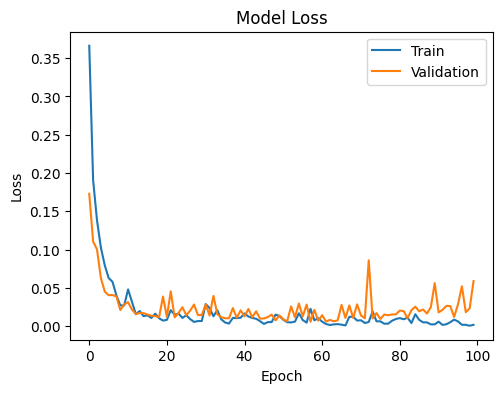

In [22]:
#Plot training & Validation loss values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

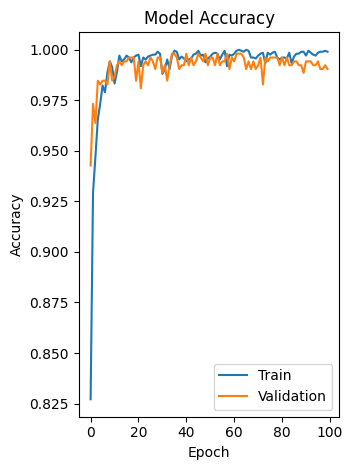

In [23]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [24]:
#Required Metric Evaluation
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Save only the weights of the model
model.save_weights('/content/drive/MyDrive/ML_WCE_BleedGen/CNN2d.h5')

# Load your model and saved weights
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_array)), activation='softmax')
])

model.load_weights('/content/drive/MyDrive/ML_WCE_BleedGen/CNN2d.h5')
# Predict on the validation data
y_pred = model.predict(X_val)
y_pred.shape


17/17 [==============================] - 0s 10ms/step


(524, 2)

In [25]:
# Convert predicted probabilities to class labels (0 or 1)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)
y_pred_labels
y_true_labels.shape

(524,)

In [26]:
# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_labels, y_pred_labels)
recall = recall_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels)
# Calculate the confusion matrix
confusion = confusion_matrix(y_true_labels, y_pred_labels)
# Calculate ROC-AUC score and plot ROC curve
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)
fpr, tpr, thresholds = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)
# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion)
print(f"ROC AUC Score: {roc_auc:.4f}")

Accuracy: 0.9905
Precision: 1.0000
Recall (Sensitivity): 0.9810
F1 Score: 0.9904
Confusion Matrix:
[[261   0]
 [  5 258]]
ROC AUC Score: 0.9905


17/17 [==============================] - 0s 9ms/step


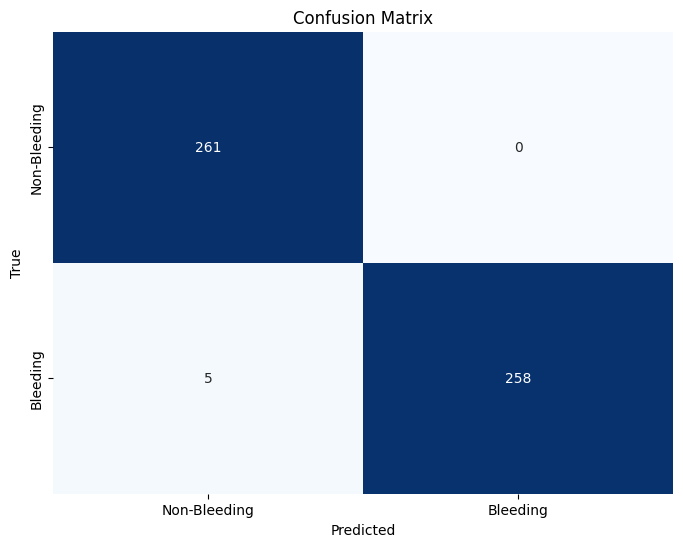

In [27]:
#Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the validation data
y_pred = model.predict(X_val)

# Convert predicted probabilities to class labels (0 or 1)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Non-Bleeding", "Bleeding"],
            yticklabels=["Non-Bleeding", "Bleeding"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

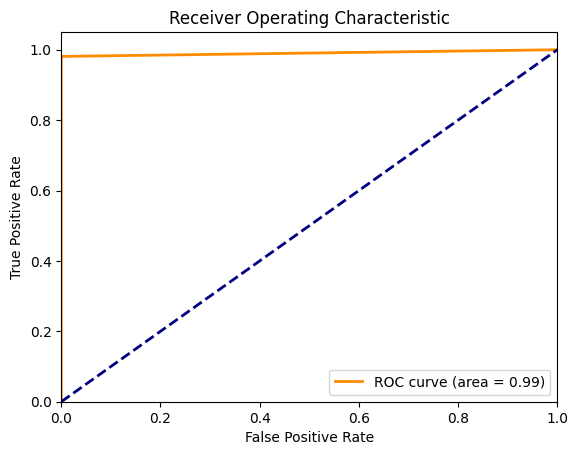

In [28]:
#ROC AOC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
#Kappa Score
from sklearn.metrics import cohen_kappa_score
# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_true_labels, y_pred_labels)

# Print the Kappa score
print(f"Cohen's Kappa Score: {kappa:.4f}")


Cohen's Kappa Score: 0.9809


In [30]:
#Specificity
TN, FP, FN, TP = confusion.ravel()

# Calculate Specificity
specificity = TN / (TN + FP)

# Print the Specificity
print(f"Specificity: {specificity:.4f}")


Specificity: 1.0000


In [31]:
#Model Saved
model.save('/content/drive/MyDrive/ML_WCE_BleedGen/CNNWithWeights2d.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
#Using the saved model (CNN2d.h5), accurately predicting the image's label of Test Dataset 1 and saving it to the test_dataset_1_Predictions.xlsx
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd

# Load the saved model
model = load_model('/content/drive/MyDrive/ML_WCE_BleedGen/CNNWithWeights2d.h5')


In [33]:
# Define the path to your test dataset directory
test_dataset_dir = '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/Test Dataset for Auto-WCEBleedGen Challenge version 2/Test Dataset 1'

# List all image files in the test dataset directory
test_image_files = [f for f in os.listdir(test_dataset_dir) if f.endswith('.png')]

# Initialize lists to store image names and predicted labels
image_names = []
predicted_labels = []

# Iterate over the test images, convert to grayscale, resize, make predictions, and store results
for image_file in test_image_files:
    # Load and preprocess the test image
    image_path = os.path.join(test_dataset_dir, image_file)
    img = cv2.imread(image_path)

    if img is not None:
        # Convert the image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize the image to 32x32 pixels
        img_gray = cv2.resize(img_gray, (32, 32))

        # Reshape to (32, 32, 1)
        img_gray = img_gray.reshape(32, 32, 1)

        # Make a prediction using the loaded model
        prediction = model.predict(np.expand_dims(img_gray, axis=0))

        # Determine the predicted label by selecting the class with the highest probability
        predicted_label = np.argmax(prediction, axis=1)

        # Map the class index to the corresponding label (e.g., 0 for non-bleeding, 1 for bleeding)
        if predicted_label == 0:
            label = "non-bleeding"
        else:
            label = "bleeding"

        # Append image name and predicted label to the lists
        image_names.append(image_file)
        predicted_labels.append(label)
    else:
        print(f"Image: {image_file}, Shape: Unable to read the image")

# Create a DataFrame to store the results
df = pd.DataFrame({'Image Name': image_names, 'Predicted Label': predicted_labels})

# Save the DataFrame to an Excel file
df.to_excel('/content/drive/MyDrive/ML_WCE_BleedGen/Predictions/predictions.xlsx', index=False)

print("Predictions saved to predictions.xlsx")

Predictions saved to predictions.xlsx


In [34]:
#Using the saved model (CNNWithWeights2d.h5), accurately predicting the image's label of Validation dataset and saving it to the Predicted_images
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model('/content/drive/MyDrive/ML_WCE_BleedGen/CNNWithWeights2d.h5')

# Define the image directories
image_directory = '/content/drive/MyDrive/ML_WCE_BleedGen'

# Lists to store the file paths of predicted images, true labels, and predicted labels
predicted_images = []
true_labels = []
predicted_labels = []

# Process both bleeding and non-bleeding images
bleeding_directory = os.path.join(image_directory, '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/bleeding')
non_bleeding_directory = os.path.join(image_directory, '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/non-bleeding')

# Create a folder to save the predicted images
output_folder = '/content/drive/MyDrive/ML_WCE_BleedGen/Predictions/predicted_images'
os.makedirs(output_folder, exist_ok=True)

# Function to make predictions on an image and get the label
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(32, 32), color_mode="grayscale")  # Load as grayscale
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_label = np.argmax(prediction)
    label = "Bleeding" if predicted_label == 1 else "Non-Bleeding"

    return label

# Process images and make predictions
for image_name in os.listdir(bleeding_directory):
    if image_name.endswith('.png'):
        image_path = os.path.join(bleeding_directory, image_name)
        predicted_images.append(image_path)
        true_labels.append("Bleeding")
        predicted_labels.append(predict_image(image_path))

for image_name in os.listdir(non_bleeding_directory):
    if image_name.endswith('.png'):
        image_path = os.path.join(non_bleeding_directory, image_name)
        predicted_images.append(image_path)
        true_labels.append("Non-Bleeding")
        predicted_labels.append(predict_image(image_path))

# Combine images, true labels, and predicted labels
predictions = list(zip(predicted_images, true_labels, predicted_labels))

# Sort by prediction confidence
predictions.sort(key=lambda x: x[2] == "Bleeding", reverse=True)

# Save the 10 best-predicted images with labels to the output folder
for i, (image_path, true_label, predicted_label) in enumerate(predictions[:10]):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    text = f"True Label: {true_label}, Predicted Label: {predicted_label}"

    # Add the text to the image
    img = cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    output_path = os.path.join(output_folder, f'predicted_{i+1}.png')
    cv2.imwrite(output_path, img)

print("Predicted images with labels saved to the output folder.")

1/1 [==============================] - 0s 22ms/step
Predicted images with labels saved to the output folder.


In [35]:
#Using the saved model (CNNWithWeights2d.h5), accurately predicting the image's label of Test Dataset 1  and saving it to the Predicted_test images
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/ML_WCE_BleedGen/CNNWithWeights2d.h5')  # Replace with the path to your saved model

test_dataset_path = '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/Test Dataset for Auto-WCEBleedGen Challenge version 2/Test Dataset 1/'

image_paths = [f for f in os.listdir(test_dataset_path) if f.endswith('.png')]

output_folder = '/content/drive/MyDrive/ML_WCE_BleedGen/Predictions/predicted_test_images'
os.makedirs(output_folder, exist_ok=True)

for i, image_path in enumerate(image_paths):
    # Load and preprocess the test image
    test_image_path = os.path.join(test_dataset_path, image_path)
    test_image = cv2.imread(test_image_path)
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convert to RGB format for display

    # Make predictions using the model
    grayscale_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    grayscale_image = cv2.resize(grayscale_image, (32, 32))  # Resize to model's input size
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  # Add batch dimension
    prediction = model.predict(grayscale_image)
    predicted_label = "Bleeding" if np.argmax(prediction) == 1 else "Non-Bleeding"

    # Save the predicted images in the output folder
    output_path = os.path.join(output_folder, f'predicted_{i+1}.png')
    cv2.imwrite(output_path, cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2BGR))
print("Predicted images saved to the output folder.")


Predicted images saved to the output folder.


In [36]:
#Using the saved model (CNNWithWeights2d.h5), accurately predicting the image's label of Test Dataset 2  and saving it to the Predicted_test 2_images
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/ML_WCE_BleedGen/CNNWithWeights2d.h5')  # Replace with the path to your saved model

test_dataset_path = '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/Test Dataset for Auto-WCEBleedGen Challenge version 2/Test Dataset 2/'

image_paths = [f for f in os.listdir(test_dataset_path) if f.endswith('.png')]

output_folder = '/content/drive/MyDrive/ML_WCE_BleedGen/Predictions/predicted_test_2_images'
os.makedirs(output_folder, exist_ok=True)

for i, image_path in enumerate(image_paths):
    # Load and preprocess the test image
    test_image_path = os.path.join(test_dataset_path, image_path)
    test_image = cv2.imread(test_image_path)
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convert to RGB format for display

    # Make predictions using the model
    grayscale_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    grayscale_image = cv2.resize(grayscale_image, (32, 32))  # Resize to model's input size
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  # Add batch dimension
    prediction = model.predict(grayscale_image)
    predicted_label = "Bleeding" if np.argmax(prediction) == 1 else "Non-Bleeding"

    # Save the predicted images in the output folder
    output_path = os.path.join(output_folder, f'predicted_{i+1}.png')
    cv2.imwrite(output_path, cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2BGR))
print("Predicted images saved to the output folder.")


Predicted images saved to the output folder.


1/1 [==============================] - 3s 3s/step


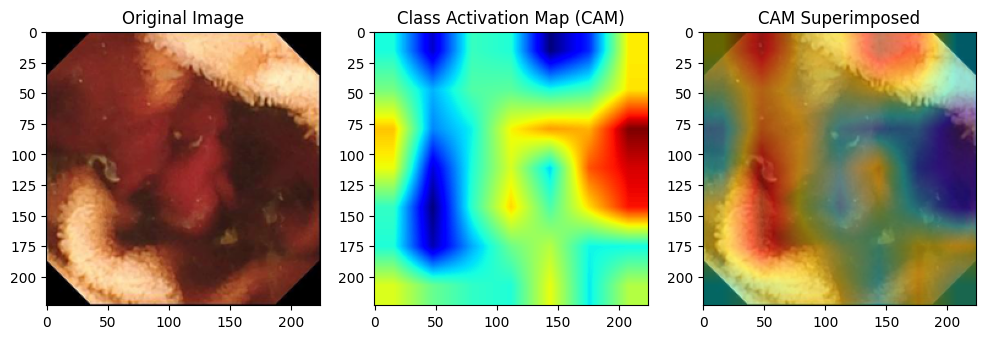

1/1 [==============================] - 2s 2s/step


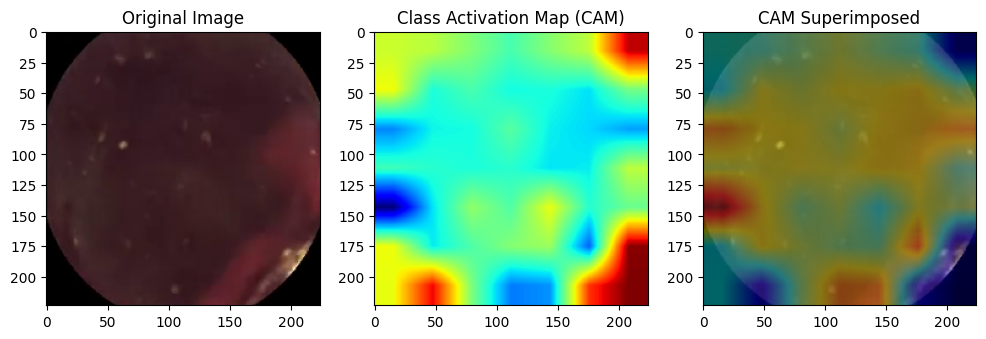

1/1 [==============================] - 2s 2s/step


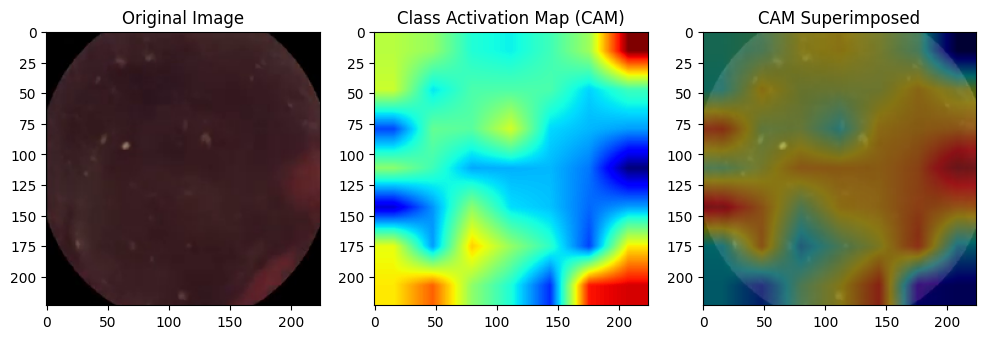

1/1 [==============================] - 3s 3s/step


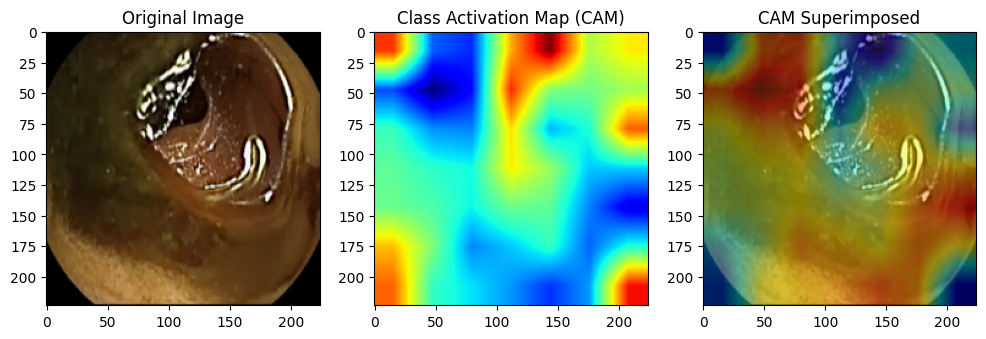

1/1 [==============================] - 2s 2s/step


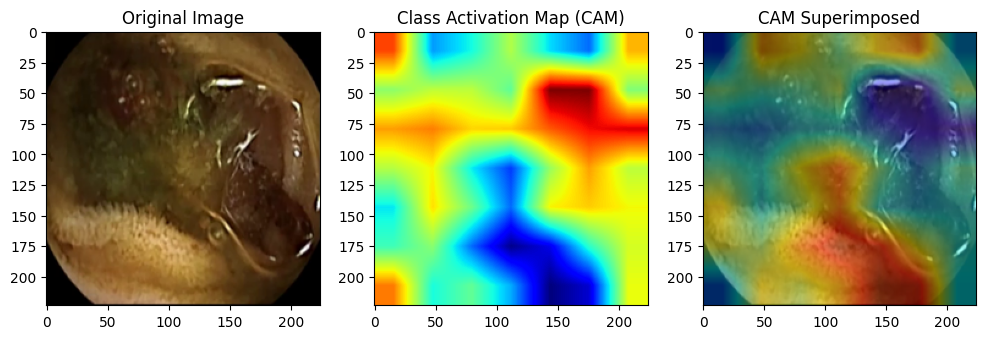

1/1 [==============================] - 2s 2s/step


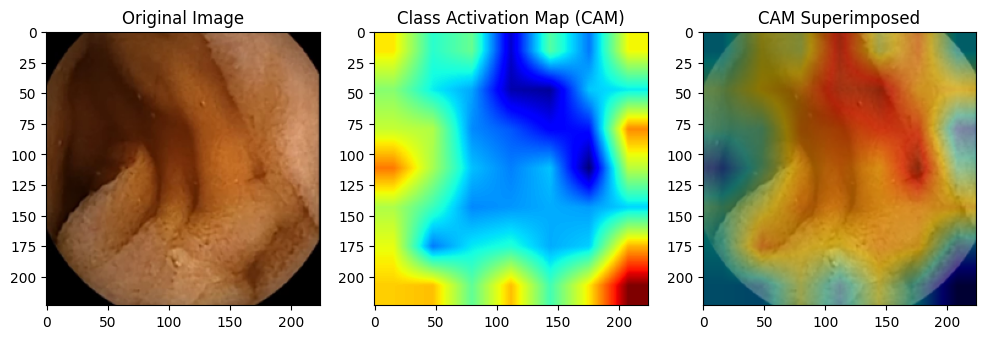

1/1 [==============================] - 2s 2s/step


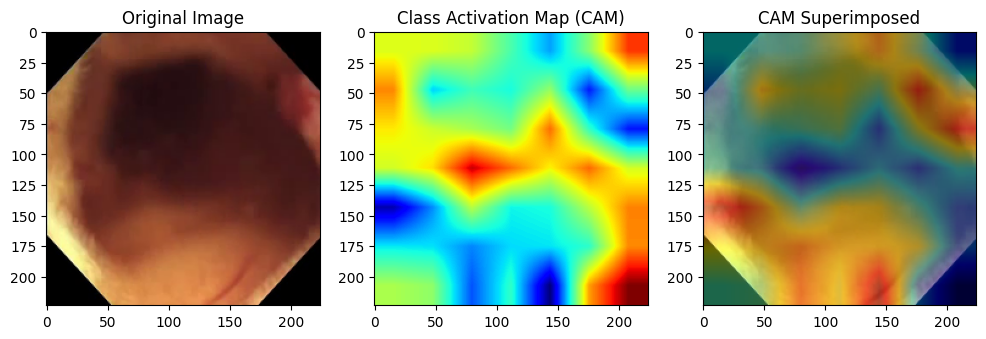

1/1 [==============================] - 3s 3s/step


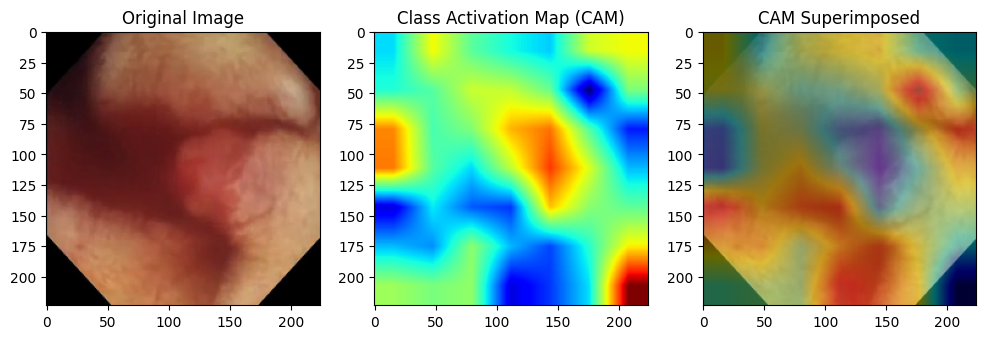

1/1 [==============================] - 4s 4s/step


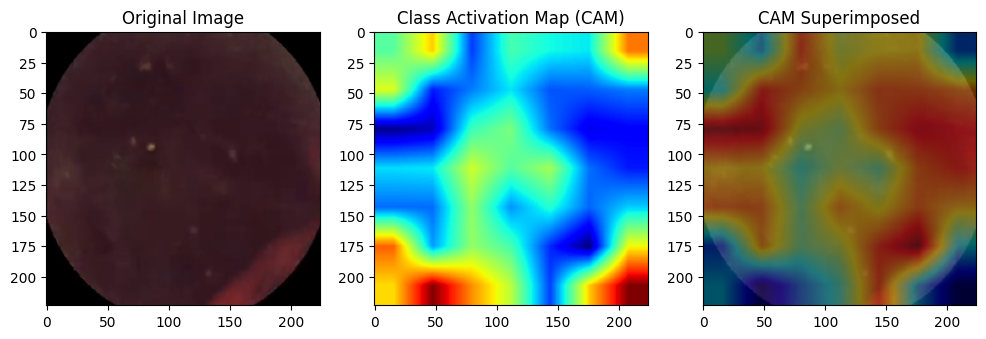

1/1 [==============================] - 2s 2s/step


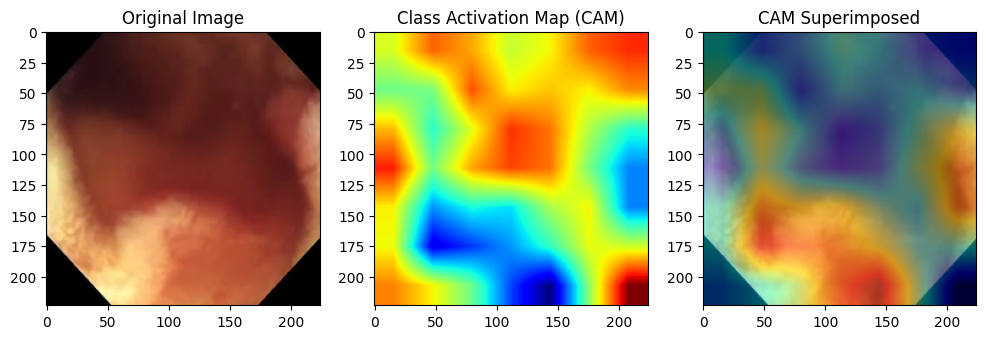

In [37]:
#CAM plots for Validation and Test Dataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121

# Load the DenseNet-121 model with pre-trained weights (excluding top classification layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to compute CAM for a specific class index
def compute_CAM(model, image_path, class_idx):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Get the output of the final convolutional layer and the prediction
    final_conv_layer = model.get_layer('conv5_block16_concat')
    final_output_layer = model.get_layer('relu')

    # Create a model that extracts both the feature maps and predictions
    cam_model = Model(inputs=model.input, outputs=[final_conv_layer.output, final_output_layer.output])

    # Get feature maps and predictions
    features, preds = cam_model.predict(x)

    # Get the feature map for the class index
    class_activation_map = features[0, :, :, class_idx]

    # Normalize CAM
    cam = class_activation_map - np.min(class_activation_map)
    cam /= np.max(cam)

    # Resize CAM to match the image size
    cam = cv2.resize(cam, (224, 224))

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the original image, CAM, and superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(132)
    plt.imshow(cam, cmap='jet')
    plt.title('Class Activation Map (CAM)')

    plt.subplot(133)
    plt.imshow(superimposed_img)
    plt.title('CAM Superimposed')
    plt.show()

# Directory with bleeding images
bleeding_image_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/classification_dataset/bleeding'

# Choose 5 random images
import random
random.seed(42)  # Set seed for reproducibility
selected_images = random.sample(os.listdir(bleeding_image_directory), 10)

# Compute and display CAM for the selected images
for image_name in selected_images:
    image_path = os.path.join(bleeding_image_directory, image_name)
    compute_CAM(base_model, image_path, class_idx=1)

1/1 [==============================] - 2s 2s/step


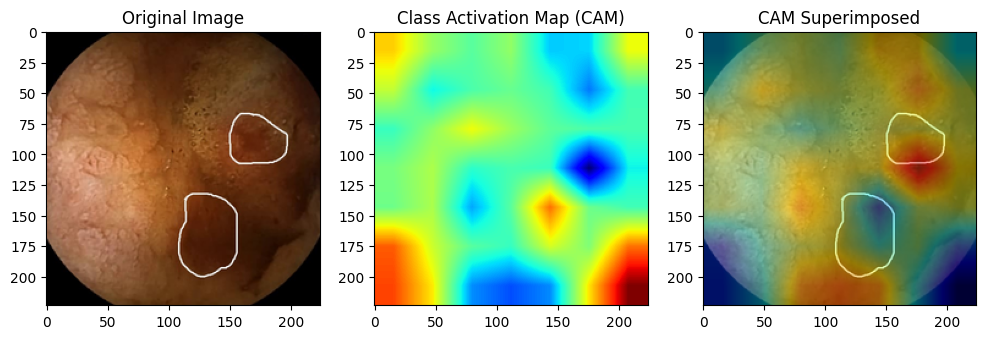

1/1 [==============================] - 2s 2s/step


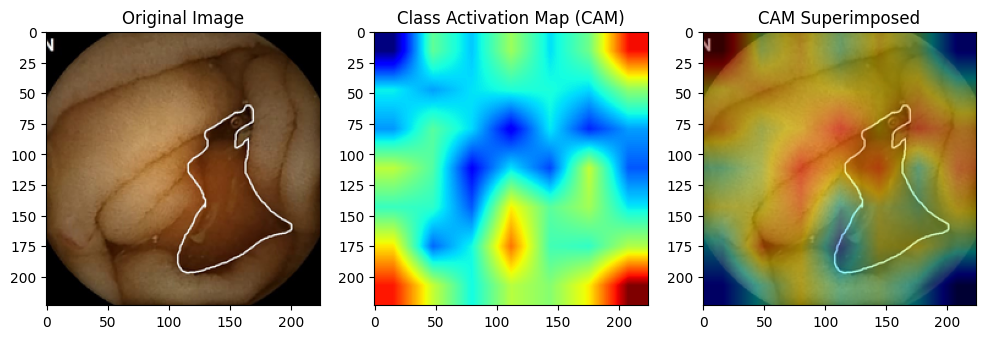

1/1 [==============================] - 2s 2s/step


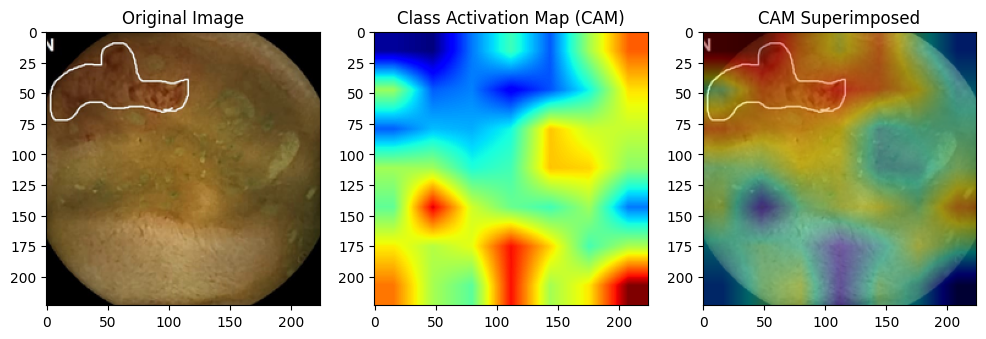

1/1 [==============================] - 3s 3s/step


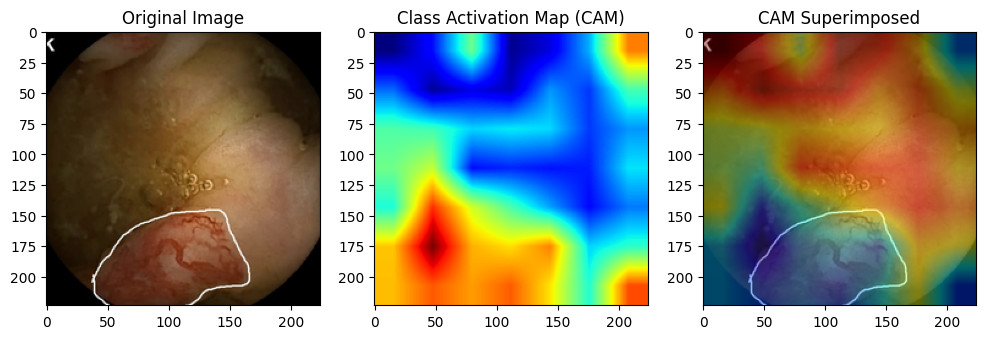

1/1 [==============================] - 2s 2s/step


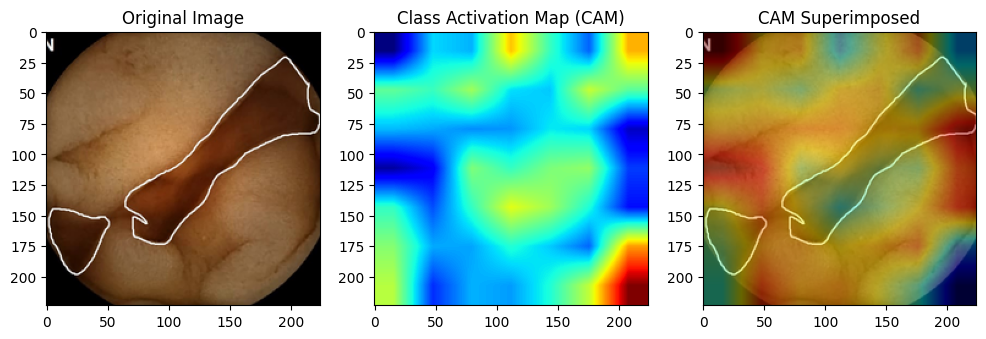

In [38]:
#marked images Test Dataset 1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121

# Load the DenseNet-121 model with pre-trained weights (excluding top classification layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to compute CAM for a specific class index
def compute_CAM(model, image_path, class_idx):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Get the output of the final convolutional layer and the prediction
    final_conv_layer = model.get_layer('conv5_block16_concat')
    final_output_layer = model.get_layer('relu')

    # Create a model that extracts both the feature maps and predictions
    cam_model = Model(inputs=model.input, outputs=[final_conv_layer.output, final_output_layer.output])

    # Get feature maps and predictions
    features, preds = cam_model.predict(x)

    # Get the feature map for the class index
    class_activation_map = features[0, :, :, class_idx]

    # Normalize CAM
    cam = class_activation_map - np.min(class_activation_map)
    cam /= np.max(cam)

    # Resize CAM to match the image size
    cam = cv2.resize(cam, (224, 224))

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the original image, CAM, and superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(132)
    plt.imshow(cam, cmap='jet')
    plt.title('Class Activation Map (CAM)')

    plt.subplot(133)
    plt.imshow(superimposed_img)
    plt.title('CAM Superimposed')
    plt.show()

# Directory with bleeding images
bleeding_image_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/Test Dataset for Auto-WCEBleedGen Challenge version 2/Test Dataset 1/Marked Images'

# Choose 5 random images
import random
random.seed(42)  # Set seed for reproducibility
selected_images = random.sample(os.listdir(bleeding_image_directory), 5)

# Compute and display CAM for the selected images
for image_name in selected_images:
    image_path = os.path.join(bleeding_image_directory, image_name)
    compute_CAM(base_model, image_path, class_idx=1)

1/1 [==============================] - 5s 5s/step


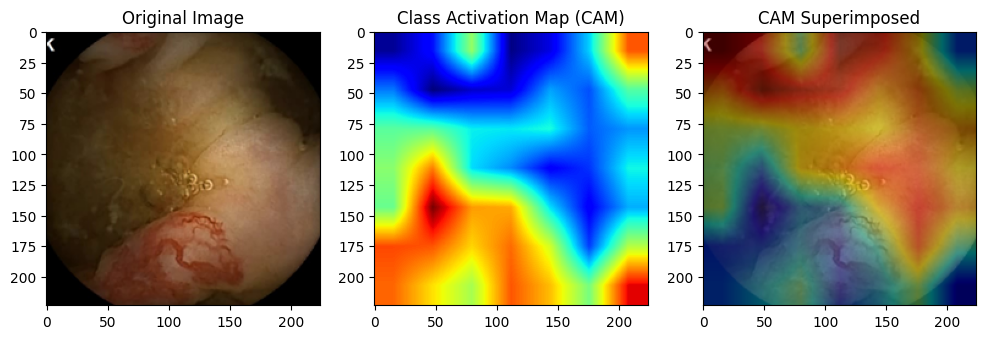

1/1 [==============================] - 2s 2s/step


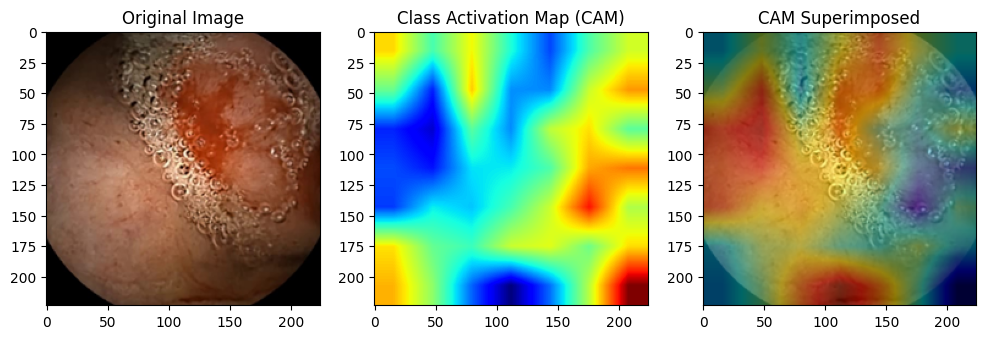

1/1 [==============================] - 2s 2s/step


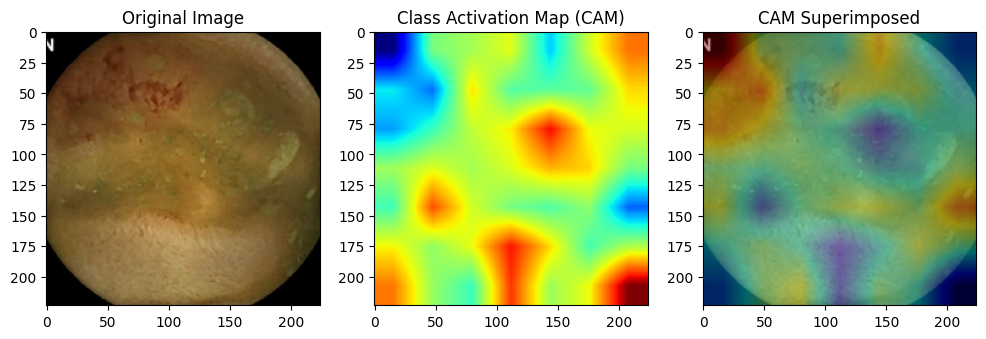

1/1 [==============================] - 3s 3s/step


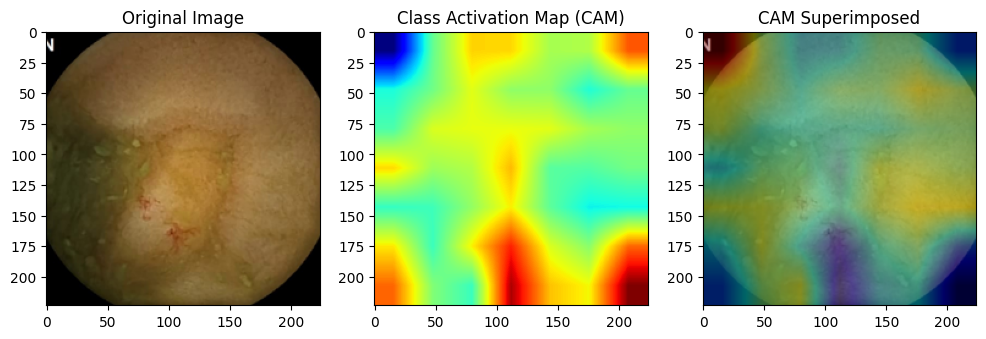

1/1 [==============================] - 2s 2s/step


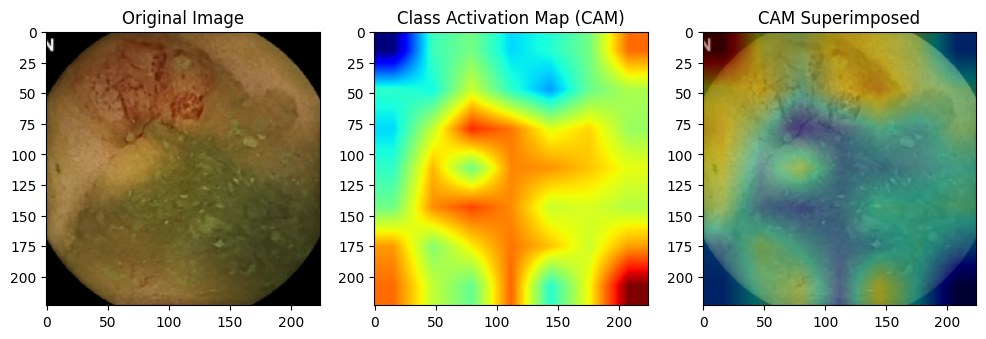

In [39]:
#Unmarked images Test Dataset 1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121

# Load the DenseNet-121 model with pre-trained weights (excluding top classification layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to compute CAM for a specific class index
def compute_CAM(model, image_path, class_idx):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Get the output of the final convolutional layer and the prediction
    final_conv_layer = model.get_layer('conv5_block16_concat')
    final_output_layer = model.get_layer('relu')

    # Create a model that extracts both the feature maps and predictions
    cam_model = Model(inputs=model.input, outputs=[final_conv_layer.output, final_output_layer.output])

    # Get feature maps and predictions
    features, preds = cam_model.predict(x)

    # Get the feature map for the class index
    class_activation_map = features[0, :, :, class_idx]

    # Normalize CAM
    cam = class_activation_map - np.min(class_activation_map)
    cam /= np.max(cam)

    # Resize CAM to match the image size
    cam = cv2.resize(cam, (224, 224))

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the original image, CAM, and superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(132)
    plt.imshow(cam, cmap='jet')
    plt.title('Class Activation Map (CAM)')

    plt.subplot(133)
    plt.imshow(superimposed_img)
    plt.title('CAM Superimposed')
    plt.show()

# Directory with bleeding images
bleeding_image_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/Test Dataset for Auto-WCEBleedGen Challenge version 2/Test Dataset 1/Unmarked Images'

# Choose 5 random images
import random
random.seed(42)  # Set seed for reproducibility
selected_images = random.sample(os.listdir(bleeding_image_directory), 5)

# Compute and display CAM for the selected images
for image_name in selected_images:
    image_path = os.path.join(bleeding_image_directory, image_name)
    compute_CAM(base_model, image_path, class_idx=1)

1/1 [==============================] - 2s 2s/step


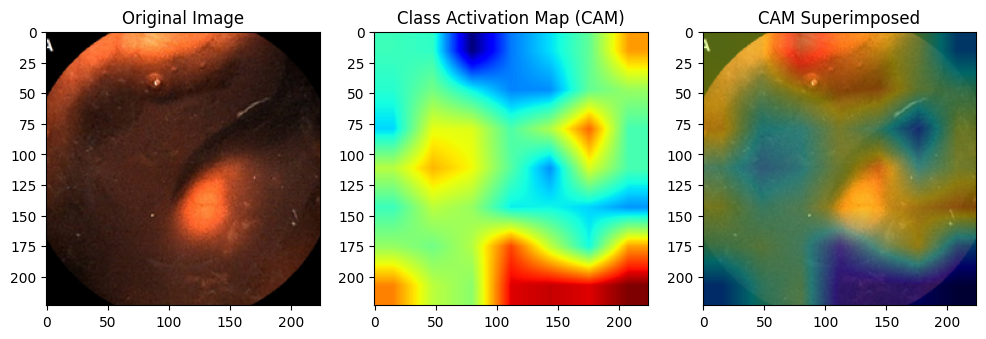

1/1 [==============================] - 3s 3s/step


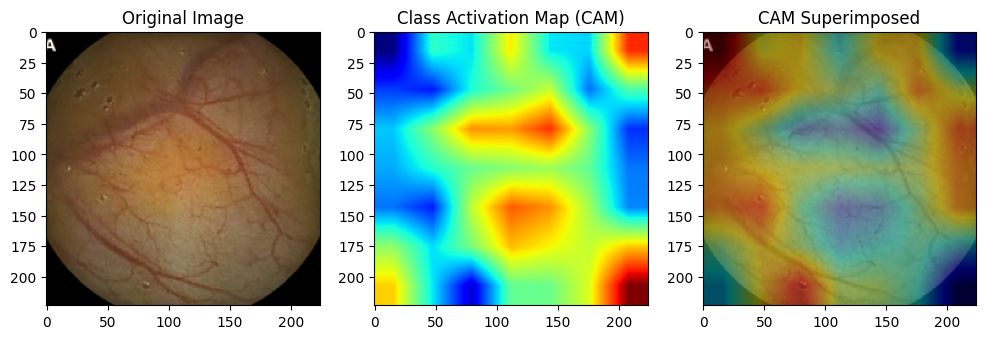

1/1 [==============================] - 2s 2s/step


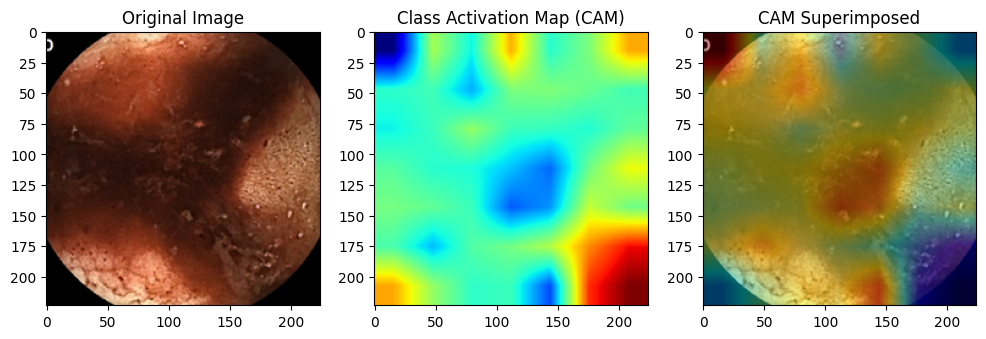

1/1 [==============================] - 4s 4s/step


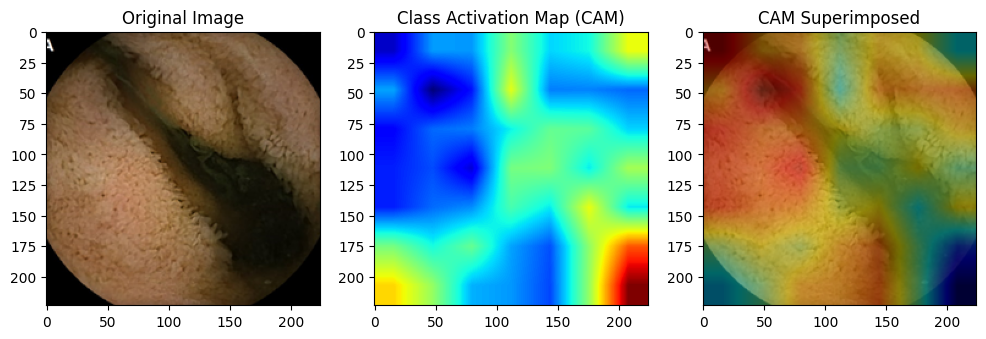

1/1 [==============================] - 3s 3s/step


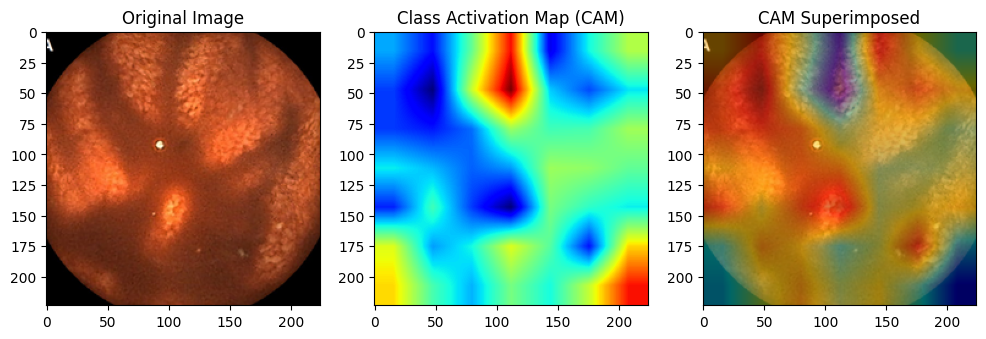

Predicted images with labels saved to the output folder.


In [40]:
#CAM plots for Validation and Test Dataset_2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121

# Load the DenseNet-121 model with pre-trained weights (excluding top classification layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to compute CAM for a specific class index
def compute_CAM(model, image_path, class_idx):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Get the output of the final convolutional layer and the prediction
    final_conv_layer = model.get_layer('conv5_block16_concat')
    final_output_layer = model.get_layer('relu')

    # Create a model that extracts both the feature maps and predictions
    cam_model = Model(inputs=model.input, outputs=[final_conv_layer.output, final_output_layer.output])

    # Get feature maps and predictions
    features, preds = cam_model.predict(x)

    # Get the feature map for the class index
    class_activation_map = features[0, :, :, class_idx]

    # Normalize CAM
    cam = class_activation_map - np.min(class_activation_map)
    cam /= np.max(cam)

    # Resize CAM to match the image size
    cam = cv2.resize(cam, (224, 224))

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the original image, CAM, and superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(132)
    plt.imshow(cam, cmap='jet')
    plt.title('Class Activation Map (CAM)')

    plt.subplot(133)
    plt.imshow(superimposed_img)
    plt.title('CAM Superimposed')
    plt.show()

# Directory with bleeding images
bleeding_image_directory = '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/Test Dataset for Auto-WCEBleedGen Challenge version 2/Test Dataset 2/Images'

# Choose 5 random images
import random
random.seed(42)  # Set seed for reproducibility
selected_images = random.sample(os.listdir(bleeding_image_directory), 5)

# Compute and display CAM for the selected images
for image_name in selected_images:
    image_path = os.path.join(bleeding_image_directory, image_name)
    compute_CAM(base_model, image_path, class_idx=1)
print("Predicted images with labels saved to the output folder.")



#بِسْمِ اللهِ الرَّحْمٰنِ الرَّحِيْمِ

##Semantic Segmentation

In [41]:
import glob
import random
import os
import shutil

PATH = '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/'
img_path = glob.glob(PATH + 'Images/*.png')
labels = glob.glob(PATH + 'Bounding boxes/YOLO_TXT/*.txt')
print("Image Paths:")
print(img_path)
print("Label Paths:")
print(labels)
print("Number of Images:", len(img_path))
print("Number of Labels:", len(labels))


def move(paths, folder):
    for p in paths:
        shutil.move(p, folder)

def split_dataset_yolo(img_path: str, labels: str, ratio: float = 0.8):
    """
    Splits the dataset into training and testing
    :param img_path: Path to the images
    :param labels: Path to the labels
    :param ratio: Ratio of training to validation
    :return: None
    """
    if not img_path:
        print("Error: img_path list is empty")
        return
    if not labels:
        print("Error: labels list is empty")
        return
    if len(img_path) != len(labels):
        print("Error: img_path and labels lists have different lengths")
        return

    # Calculate number of files for training and validation
    data_size = len(img_path)
    train_size = int(data_size * ratio)

    # Shuffle two lists
    img_labels = list(zip(img_path, labels))
    random.seed(43)
    random.shuffle(img_labels)
    img_paths, txt_paths = zip(*img_labels)

    # Define folder paths
    train_folder = '/content/drive/MyDrive/ML_WCE_BleedGen/segmentation/dataset/train'
    valid_folder = '/content/drive/MyDrive/ML_WCE_BleedGen/segmentation/dataset/valid'

    # Create the folder structure if it does not exist
    for folder in [train_folder, valid_folder]:
        for subfolder in ['images', 'labels']:
            os.makedirs(os.path.join(folder, subfolder), exist_ok=True)

    # Splitting
    train_img_paths = img_paths[:train_size]
    train_txt_paths = txt_paths[:train_size]

    valid_img_paths = img_paths[train_size:]
    valid_txt_paths = txt_paths[train_size:]

    # Move images and labels to the respective folders
    for src, dst in zip(train_img_paths, train_txt_paths):
        move(src, os.path.join(train_folder, 'images'))
        move(dst, os.path.join(train_folder, 'labels'))

    for src, dst in zip(valid_img_paths, valid_txt_paths):
        move(src, os.path.join(valid_folder, 'images'))
        move(dst, os.path.join(valid_folder, 'labels'))

if __name__ == '__main__':
    split_dataset_yolo(img_path, labels)


Image Paths:
['/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1283).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1291).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1274).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1292).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1304).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1302).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1297).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1309).png', '/content/drive/MyDrive/ML_WCE_BleedGen/datasets/WCEBleedGen (updated)/bleeding/Images/img- (1303).png', '/content/drive/MyDrive/ML_WCE_BleedGen/d

Error: Destination path '/content/drive/MyDrive/ML_WCE_BleedGen/segmentation/dataset/train/images/' already exists

In [ ]:
def find_and_delete_extra_label(img_path, labels):
    if len(img_path) > len(labels):
        print("Extra image found. Deleting the extra image...")
        extra_img_index = len(img_path) - 1  # Adjust index to access the last element
        extra_img_path = img_path[extra_img_index]
        os.remove(extra_img_path)
        print("Extra image deleted successfully.")
    elif len(labels) > len(img_path):
        print("Extra label found. Deleting the extra label...")
        extra_label_index = len(labels) - 1  # Adjust index to access the last element
        extra_label_path = labels[extra_label_index]
        os.remove(extra_label_path)
        print("Extra label deleted successfully.")
    else:
        print("No extra labels or images found.")

# Call the function to find and delete the extra label or image
find_and_delete_extra_label(img_path, labels)



In [ ]:
from ultralytics import YOLO
import argparse

In [ ]:
def train_model(config_path: str = '/content/drive/MyDrive/ML_WCE_BleedGen/config.yaml', epochs: int = 5, imgsz: int = 224):
    model = YOLO('yolov8n.pt')
    results = model.train(data=config_path, epochs=epochs, imgsz=imgsz)
    return results


parser = argparse.ArgumentParser(description="Training Script for YOLO")
parser.add_argument('--config_path')
parser.add_argument('--epochs')
parser.add_argument('--imgsz')

args = parser.parse_args()
config_path = args.config_path
epochs = int(args.epochs)
image_size = int(args.imgsz)

results = train_model(config_path, epochs, image_size)
print(results)